# panel testing
Julian Hsu
17 feb 2023


Generate figures and statistics using the `panelib` package. 
1. Distribution of placebo results;
2. Sample results.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


import os as os 

import matplotlib.pyplot as plt
%matplotlib inline  

import scipy.stats 
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm


Create a fake panel dataset. To make it look more real, plot a few outlier trends.

In [2]:

N = 10
T = 17
ttime = 4
atet = 1
initial = np.random.uniform(0,1, N)
initial[-1] = 2
initial[-2] = 1.5
df = pd.DataFrame(data={'y':initial,
                  'unit_id':np.arange(N),
                       'time':np.ones(N).astype(int)})
for t in range(T):
    entry = df.loc[df['time']==t+1]
    entry['y'] = entry['y']*0.80 + np.random.uniform(-1,1,N)*0.20 
    entry['y'] += np.sin(entry['unit_id'] % 3)*np.random.uniform(-0.5,0.5,N)
    entry['y'] += np.random.normal(0,1,N)
    ## Always randomly pick two units that get a shift up the treatment size    
    entry.iloc[np.random.choice(N,2, replace=False)]['y'] +=atet*2
    
    ## Pick two more units that get a shift down the treatment size
    entry.iloc[np.random.choice(N,2, replace=False)]['y'] -= atet*2
            
    entry.loc[[True]*N,'time'] = t+2
    
    df = pd.concat([df,entry])
df['treated']        = df['unit_id'].isin([0,1])
df['post'] = (df['time'] > (T-ttime+2) )
df['W'] =     df['treated']*    df['post']
df['unit_id'] = df['unit_id'].apply(str)
df.loc[df['W']==True, 'y'] += atet

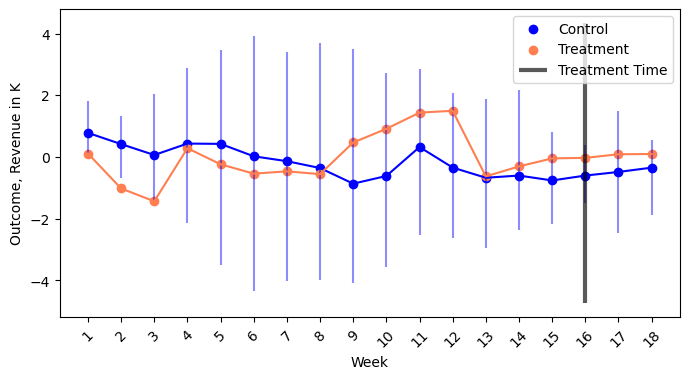

In [3]:


## Plot trend
c_plot = df.loc[df['treated']==0].groupby('time')['y']
t_plot = df.loc[df['treated']==1].groupby('time')['y']
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8,4))
a=ax.scatter( c_plot.mean().index, c_plot.mean(), label='Control' , color='blue')
ax.plot( c_plot.mean().index, c_plot.mean(), color='blue')
ax.vlines( c_plot.mean().index, ymin=c_plot.quantile(q=0.05), ymax=c_plot.quantile(q=0.95), color='blue', alpha=0.45)


b=ax.scatter( t_plot.mean().index, t_plot.mean(), label='Treatment' , color='coral')
ax.plot( t_plot.mean().index, t_plot.mean(), color='coral')
ax.vlines(x=df.loc[df['post']==1].groupby('time')['y'].mean().index.min(),
          ymin=ax.get_ylim()[0], 
          ymax=ax.get_ylim()[1],
          linewidth=3, color='black',alpha=0.65, label='Treatment Time')
ax.legend()
ax.set_xticks(t_plot.mean().index )
ax.set_xticklabels(t_plot.mean().index, rotation=45 )
ax.set_ylabel('Outcome, Revenue in K')
ax.set_xlabel('Week')
plt.show()


Now we go through a placebo test, where we pretend none of these units are treated in the past, and estimate a placebo impact.

In [4]:
import importlib
try:
    importlib.reload(plb)
except:
    import panelib as plb
    


Text(0.5, 0, '')

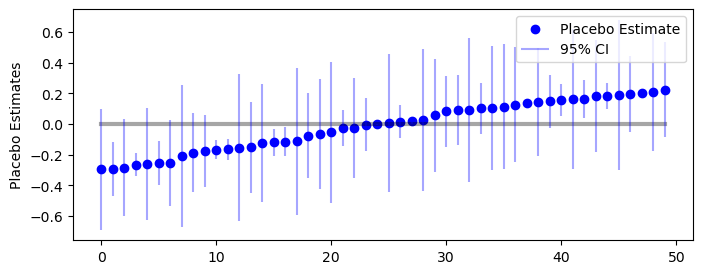

In [5]:
N=50
placebo_est = np.random.uniform(-0.31,0.23,N)
placebo_se = np.random.uniform(0, 0.25, N)
placebo_results = pd.DataFrame(index=np.arange(len(placebo_est)), 
                               data={'atet':placebo_est, 'se':placebo_se})
placebo_results.sort_values(by='atet',inplace=True)
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8,3))
ax.plot(np.arange( len(placebo_results) ), np.zeros(len(placebo_results)), color='black',linewidth=3 , alpha=0.35)

ax.scatter( np.arange( len(placebo_results) ), placebo_results['atet'], color='blue', label='Placebo Estimate')
ax.vlines( x=np.arange( len(placebo_results) ), 
          ymin=placebo_results['atet']-1.96*placebo_results['se'],
         ymax=placebo_results['atet']+1.96*placebo_results['se'], color='blue',alpha=0.35, label='95% CI')
ax.legend()
ax.set_ylabel('Placebo Estimates')
ax.set_xlabel('')

In [6]:
df_pl = df.loc[df['time'] <= int(0.75*T) ]
df_pl['post'] = (df_pl['time'] >= int(0.75*T) - (ttime) )

sim_df = pd.DataFrame()
## Iterate over each unit and calculate the placebo impact.
for r in range(N):
    df_pl['treated'] = (df_pl['unit_id']==str(r)).astype(float)
    df_pl['W'] =     df_pl['treated']*    df_pl['post']
    f3 = plb.sc.sc_model(model_name='cl',
            data=df_pl,
            data_dict={'treatment': 'treated',
                      'date':'time',
                      'post':'post',
                      'unitid':'unit_id',
                      'outcome':'y'},
            pre_process_data=None,
            aggregate_pst_periods=True,
            pre_train_test_lengths=None,
            inference={'alpha':0.05, 'theta_grid':np.arange(-10,10,0.015) })
    sim_df = pd.concat([sim_df, f3['results_df'][['atet','ci_lower','ci_upper']] ])
#     display( f3['results_df'] )



Using CL
-10.0 0.08333333333333337
-9.99985 0.08333333333333337
-9.9997 0.08333333333333337
-9.999550000000001 0.08333333333333337
-9.999400000000001 0.08333333333333337
-9.999250000000002 0.08333333333333337
-9.999100000000002 0.08333333333333337
-9.998950000000002 0.08333333333333337
-9.998800000000003 0.08333333333333337
-9.998650000000003 0.08333333333333337
-9.998500000000003 0.08333333333333337
-9.998350000000004 0.08333333333333337
-9.998200000000004 0.08333333333333337
-9.998050000000005 0.08333333333333337
-9.997900000000005 0.08333333333333337
-9.997750000000005 0.08333333333333337
-9.997600000000006 0.08333333333333337
-9.997450000000006 0.08333333333333337
-9.997300000000006 0.08333333333333337
-9.997150000000007 0.08333333333333337
-9.997000000000007 0.08333333333333337
-9.996850000000007 0.08333333333333337
-9.996700000000008 0.08333333333333337
-9.996550000000008 0.08333333333333337
-9.996400000000008 0.08333333333333337
-9.996250000000009 0.08333333333333337
-9.99610000

-9.901750000000229 0.08333333333333337
-9.90160000000023 0.08333333333333337
-9.90145000000023 0.08333333333333337
-9.90130000000023 0.08333333333333337
-9.90115000000023 0.08333333333333337
-9.90100000000023 0.08333333333333337
-9.900850000000231 0.08333333333333337
-9.900700000000231 0.08333333333333337
-9.900550000000232 0.08333333333333337
-9.900400000000232 0.08333333333333337
-9.900250000000232 0.08333333333333337
-9.900100000000233 0.08333333333333337
-9.899950000000233 0.08333333333333337
-9.899800000000234 0.08333333333333337
-9.899650000000234 0.08333333333333337
-9.899500000000234 0.08333333333333337
-9.899350000000235 0.08333333333333337
-9.899200000000235 0.08333333333333337
-9.899050000000235 0.08333333333333337
-9.898900000000236 0.08333333333333337
-9.898750000000236 0.08333333333333337
-9.898600000000236 0.08333333333333337
-9.898450000000237 0.08333333333333337
-9.898300000000237 0.08333333333333337
-9.898150000000237 0.08333333333333337
-9.898000000000238 0.083333333

-9.821350000000416 0.08333333333333337
-9.821200000000417 0.08333333333333337
-9.821050000000417 0.08333333333333337
-9.820900000000417 0.08333333333333337
-9.820750000000418 0.08333333333333337
-9.820600000000418 0.08333333333333337
-9.820450000000418 0.08333333333333337
-9.820300000000419 0.08333333333333337
-9.82015000000042 0.08333333333333337
-9.82000000000042 0.08333333333333337
-9.81985000000042 0.08333333333333337
-9.81970000000042 0.08333333333333337
-9.81955000000042 0.08333333333333337
-9.819400000000421 0.08333333333333337
-9.819250000000421 0.08333333333333337
-9.819100000000422 0.08333333333333337
-9.818950000000422 0.08333333333333337
-9.818800000000422 0.08333333333333337
-9.818650000000423 0.08333333333333337
-9.818500000000423 0.08333333333333337
-9.818350000000423 0.08333333333333337
-9.818200000000424 0.08333333333333337
-9.818050000000424 0.08333333333333337
-9.817900000000424 0.08333333333333337
-9.817750000000425 0.08333333333333337
-9.817600000000425 0.083333333

-9.736150000000615 0.08333333333333337
-9.736000000000615 0.08333333333333337
-9.735850000000616 0.08333333333333337
-9.735700000000616 0.08333333333333337
-9.735550000000616 0.08333333333333337
-9.735400000000617 0.08333333333333337
-9.735250000000617 0.08333333333333337
-9.735100000000617 0.08333333333333337
-9.734950000000618 0.08333333333333337
-9.734800000000618 0.08333333333333337
-9.734650000000618 0.08333333333333337
-9.734500000000619 0.08333333333333337
-9.73435000000062 0.08333333333333337
-9.73420000000062 0.08333333333333337
-9.73405000000062 0.08333333333333337
-9.73390000000062 0.08333333333333337
-9.73375000000062 0.08333333333333337
-9.73360000000062 0.08333333333333337
-9.733450000000621 0.08333333333333337
-9.733300000000622 0.08333333333333337
-9.733150000000622 0.08333333333333337
-9.733000000000622 0.08333333333333337
-9.732850000000623 0.08333333333333337
-9.732700000000623 0.08333333333333337
-9.732550000000623 0.08333333333333337
-9.732400000000624 0.0833333333

-9.67390000000076 0.08333333333333337
-9.67375000000076 0.08333333333333337
-9.67360000000076 0.08333333333333337
-9.673450000000761 0.08333333333333337
-9.673300000000761 0.08333333333333337
-9.673150000000762 0.08333333333333337
-9.673000000000762 0.08333333333333337
-9.672850000000762 0.08333333333333337
-9.672700000000763 0.08333333333333337
-9.672550000000763 0.08333333333333337
-9.672400000000763 0.08333333333333337
-9.672250000000764 0.08333333333333337
-9.672100000000764 0.08333333333333337
-9.671950000000765 0.08333333333333337
-9.671800000000765 0.08333333333333337
-9.671650000000765 0.08333333333333337
-9.671500000000766 0.08333333333333337
-9.671350000000766 0.08333333333333337
-9.671200000000766 0.08333333333333337
-9.671050000000767 0.08333333333333337
-9.670900000000767 0.08333333333333337
-9.670750000000767 0.08333333333333337
-9.670600000000768 0.08333333333333337
-9.670450000000768 0.08333333333333337
-9.670300000000768 0.08333333333333337
-9.670150000000769 0.0833333

-9.601600000000929 0.08333333333333337
-9.601450000000929 0.08333333333333337
-9.60130000000093 0.08333333333333337
-9.60115000000093 0.08333333333333337
-9.60100000000093 0.08333333333333337
-9.60085000000093 0.08333333333333337
-9.60070000000093 0.08333333333333337
-9.600550000000931 0.08333333333333337
-9.600400000000931 0.08333333333333337
-9.600250000000932 0.08333333333333337
-9.600100000000932 0.08333333333333337
-9.599950000000932 0.08333333333333337
-9.599800000000933 0.08333333333333337
-9.599650000000933 0.08333333333333337
-9.599500000000933 0.08333333333333337
-9.599350000000934 0.08333333333333337
-9.599200000000934 0.08333333333333337
-9.599050000000934 0.08333333333333337
-9.598900000000935 0.08333333333333337
-9.598750000000935 0.08333333333333337
-9.598600000000935 0.08333333333333337
-9.598450000000936 0.08333333333333337
-9.598300000000936 0.08333333333333337
-9.598150000000937 0.08333333333333337
-9.598000000000937 0.08333333333333337
-9.597850000000937 0.083333333

-9.522100000001114 0.08333333333333337
-9.521950000001114 0.08333333333333337
-9.521800000001114 0.08333333333333337
-9.521650000001115 0.08333333333333337
-9.521500000001115 0.08333333333333337
-9.521350000001116 0.08333333333333337
-9.521200000001116 0.08333333333333337
-9.521050000001116 0.08333333333333337
-9.520900000001117 0.08333333333333337
-9.520750000001117 0.08333333333333337
-9.520600000001117 0.08333333333333337
-9.520450000001118 0.08333333333333337
-9.520300000001118 0.08333333333333337
-9.520150000001118 0.08333333333333337
-9.520000000001119 0.08333333333333337
-9.519850000001119 0.08333333333333337
-9.51970000000112 0.08333333333333337
-9.51955000000112 0.08333333333333337
-9.51940000000112 0.08333333333333337
-9.51925000000112 0.08333333333333337
-9.51910000000112 0.08333333333333337
-9.518950000001121 0.08333333333333337
-9.518800000001121 0.08333333333333337
-9.518650000001122 0.08333333333333337
-9.518500000001122 0.08333333333333337
-9.518350000001123 0.083333333

-9.446950000001289 0.08333333333333337
-9.44680000000129 0.08333333333333337
-9.44665000000129 0.08333333333333337
-9.44650000000129 0.08333333333333337
-9.44635000000129 0.08333333333333337
-9.44620000000129 0.08333333333333337
-9.446050000001291 0.08333333333333337
-9.445900000001291 0.08333333333333337
-9.445750000001292 0.08333333333333337
-9.445600000001292 0.08333333333333337
-9.445450000001292 0.08333333333333337
-9.445300000001293 0.08333333333333337
-9.445150000001293 0.08333333333333337
-9.445000000001293 0.08333333333333337
-9.444850000001294 0.08333333333333337
-9.444700000001294 0.08333333333333337
-9.444550000001295 0.08333333333333337
-9.444400000001295 0.08333333333333337
-9.444250000001295 0.08333333333333337
-9.444100000001296 0.08333333333333337
-9.443950000001296 0.08333333333333337
-9.443800000001296 0.08333333333333337
-9.443650000001297 0.08333333333333337
-9.443500000001297 0.08333333333333337
-9.443350000001297 0.08333333333333337
-9.443200000001298 0.083333333

-9.374950000001457 0.08333333333333337
-9.374800000001457 0.08333333333333337
-9.374650000001457 0.08333333333333337
-9.374500000001458 0.08333333333333337
-9.374350000001458 0.08333333333333337
-9.374200000001458 0.08333333333333337
-9.374050000001459 0.08333333333333337
-9.37390000000146 0.08333333333333337
-9.37375000000146 0.08333333333333337
-9.37360000000146 0.08333333333333337
-9.37345000000146 0.08333333333333337
-9.37330000000146 0.08333333333333337
-9.373150000001461 0.08333333333333337
-9.373000000001461 0.08333333333333337
-9.372850000001462 0.08333333333333337
-9.372700000001462 0.08333333333333337
-9.372550000001462 0.08333333333333337
-9.372400000001463 0.08333333333333337
-9.372250000001463 0.08333333333333337
-9.372100000001463 0.08333333333333337
-9.371950000001464 0.08333333333333337
-9.371800000001464 0.08333333333333337
-9.371650000001464 0.08333333333333337
-9.371500000001465 0.08333333333333337
-9.371350000001465 0.08333333333333337
-9.371200000001465 0.083333333

-9.303400000001623 0.08333333333333337
-9.303250000001624 0.08333333333333337
-9.303100000001624 0.08333333333333337
-9.302950000001625 0.08333333333333337
-9.302800000001625 0.08333333333333337
-9.302650000001625 0.08333333333333337
-9.302500000001626 0.08333333333333337
-9.302350000001626 0.08333333333333337
-9.302200000001626 0.08333333333333337
-9.302050000001627 0.08333333333333337
-9.301900000001627 0.08333333333333337
-9.301750000001627 0.08333333333333337
-9.301600000001628 0.08333333333333337
-9.301450000001628 0.08333333333333337
-9.301300000001628 0.08333333333333337
-9.301150000001629 0.08333333333333337
-9.301000000001629 0.08333333333333337
-9.30085000000163 0.08333333333333337
-9.30070000000163 0.08333333333333337
-9.30055000000163 0.08333333333333337
-9.30040000000163 0.08333333333333337
-9.30025000000163 0.08333333333333337
-9.300100000001631 0.08333333333333337
-9.299950000001632 0.08333333333333337
-9.299800000001632 0.08333333333333337
-9.299650000001632 0.083333333

-9.229600000001795 0.08333333333333337
-9.229450000001796 0.08333333333333337
-9.229300000001796 0.08333333333333337
-9.229150000001797 0.08333333333333337
-9.229000000001797 0.08333333333333337
-9.228850000001797 0.08333333333333337
-9.228700000001798 0.08333333333333337
-9.228550000001798 0.08333333333333337
-9.228400000001798 0.08333333333333337
-9.228250000001799 0.08333333333333337
-9.228100000001799 0.08333333333333337
-9.2279500000018 0.08333333333333337
-9.2278000000018 0.08333333333333337
-9.2276500000018 0.08333333333333337
-9.2275000000018 0.08333333333333337
-9.2273500000018 0.08333333333333337
-9.227200000001801 0.08333333333333337
-9.227050000001801 0.08333333333333337
-9.226900000001802 0.08333333333333337
-9.226750000001802 0.08333333333333337
-9.226600000001802 0.08333333333333337
-9.226450000001803 0.08333333333333337
-9.226300000001803 0.08333333333333337
-9.226150000001804 0.08333333333333337
-9.226000000001804 0.08333333333333337
-9.225850000001804 0.08333333333333

-9.15010000000198 0.08333333333333337
-9.149950000001981 0.08333333333333337
-9.149800000001981 0.08333333333333337
-9.149650000001982 0.08333333333333337
-9.149500000001982 0.08333333333333337
-9.149350000001983 0.08333333333333337
-9.149200000001983 0.08333333333333337
-9.149050000001983 0.08333333333333337
-9.148900000001984 0.08333333333333337
-9.148750000001984 0.08333333333333337
-9.148600000001984 0.08333333333333337
-9.148450000001985 0.08333333333333337
-9.148300000001985 0.08333333333333337
-9.148150000001985 0.08333333333333337
-9.148000000001986 0.08333333333333337
-9.147850000001986 0.08333333333333337
-9.147700000001986 0.08333333333333337
-9.147550000001987 0.08333333333333337
-9.147400000001987 0.08333333333333337
-9.147250000001987 0.08333333333333337
-9.147100000001988 0.08333333333333337
-9.146950000001988 0.08333333333333337
-9.146800000001988 0.08333333333333337
-9.146650000001989 0.08333333333333337
-9.14650000000199 0.08333333333333337
-9.14635000000199 0.0833333

-9.076600000002152 0.08333333333333337
-9.076450000002152 0.08333333333333337
-9.076300000002153 0.08333333333333337
-9.076150000002153 0.08333333333333337
-9.076000000002153 0.08333333333333337
-9.075850000002154 0.08333333333333337
-9.075700000002154 0.08333333333333337
-9.075550000002155 0.08333333333333337
-9.075400000002155 0.08333333333333337
-9.075250000002155 0.08333333333333337
-9.075100000002156 0.08333333333333337
-9.074950000002156 0.08333333333333337
-9.074800000002156 0.08333333333333337
-9.074650000002157 0.08333333333333337
-9.074500000002157 0.08333333333333337
-9.074350000002157 0.08333333333333337
-9.074200000002158 0.08333333333333337
-9.074050000002158 0.08333333333333337
-9.073900000002158 0.08333333333333337
-9.073750000002159 0.08333333333333337
-9.073600000002159 0.08333333333333337
-9.07345000000216 0.08333333333333337
-9.07330000000216 0.08333333333333337
-9.07315000000216 0.08333333333333337
-9.07300000000216 0.08333333333333337
-9.07285000000216 0.083333333

-8.995300000002342 0.08333333333333337
-8.995150000002342 0.08333333333333337
-8.995000000002342 0.08333333333333337
-8.994850000002343 0.08333333333333337
-8.994700000002343 0.08333333333333337
-8.994550000002343 0.08333333333333337
-8.994400000002344 0.08333333333333337
-8.994250000002344 0.08333333333333337
-8.994100000002344 0.08333333333333337
-8.993950000002345 0.08333333333333337
-8.993800000002345 0.08333333333333337
-8.993650000002345 0.08333333333333337
-8.993500000002346 0.08333333333333337
-8.993350000002346 0.08333333333333337
-8.993200000002346 0.08333333333333337
-8.993050000002347 0.08333333333333337
-8.992900000002347 0.08333333333333337
-8.992750000002347 0.08333333333333337
-8.992600000002348 0.08333333333333337
-8.992450000002348 0.08333333333333337
-8.992300000002349 0.08333333333333337
-8.992150000002349 0.08333333333333337
-8.99200000000235 0.08333333333333337
-8.99185000000235 0.08333333333333337
-8.99170000000235 0.08333333333333337
-8.99155000000235 0.08333333

-8.912950000002533 0.08333333333333337
-8.912800000002534 0.08333333333333337
-8.912650000002534 0.08333333333333337
-8.912500000002535 0.08333333333333337
-8.912350000002535 0.08333333333333337
-8.912200000002535 0.08333333333333337
-8.912050000002536 0.08333333333333337
-8.911900000002536 0.08333333333333337
-8.911750000002536 0.08333333333333337
-8.911600000002537 0.08333333333333337
-8.911450000002537 0.08333333333333337
-8.911300000002537 0.08333333333333337
-8.911150000002538 0.08333333333333337
-8.911000000002538 0.08333333333333337
-8.910850000002538 0.08333333333333337
-8.910700000002539 0.08333333333333337
-8.910550000002539 0.08333333333333337
-8.91040000000254 0.08333333333333337
-8.91025000000254 0.08333333333333337
-8.91010000000254 0.08333333333333337
-8.90995000000254 0.08333333333333337
-8.90980000000254 0.08333333333333337
-8.909650000002541 0.08333333333333337
-8.909500000002541 0.08333333333333337
-8.909350000002542 0.08333333333333337
-8.909200000002542 0.083333333

-8.839450000002705 0.08333333333333337
-8.839300000002705 0.08333333333333337
-8.839150000002705 0.08333333333333337
-8.839000000002706 0.08333333333333337
-8.838850000002706 0.08333333333333337
-8.838700000002707 0.08333333333333337
-8.838550000002707 0.08333333333333337
-8.838400000002707 0.08333333333333337
-8.838250000002708 0.08333333333333337
-8.838100000002708 0.08333333333333337
-8.837950000002708 0.08333333333333337
-8.837800000002709 0.08333333333333337
-8.837650000002709 0.08333333333333337
-8.83750000000271 0.08333333333333337
-8.83735000000271 0.08333333333333337
-8.83720000000271 0.08333333333333337
-8.83705000000271 0.08333333333333337
-8.83690000000271 0.08333333333333337
-8.836750000002711 0.08333333333333337
-8.836600000002711 0.08333333333333337
-8.836450000002712 0.08333333333333337
-8.836300000002712 0.08333333333333337
-8.836150000002712 0.08333333333333337
-8.836000000002713 0.08333333333333337
-8.835850000002713 0.08333333333333337
-8.835700000002713 0.083333333

-8.767300000002873 0.08333333333333337
-8.767150000002873 0.08333333333333337
-8.767000000002874 0.08333333333333337
-8.766850000002874 0.08333333333333337
-8.766700000002874 0.08333333333333337
-8.766550000002875 0.08333333333333337
-8.766400000002875 0.08333333333333337
-8.766250000002875 0.08333333333333337
-8.766100000002876 0.08333333333333337
-8.765950000002876 0.08333333333333337
-8.765800000002876 0.08333333333333337
-8.765650000002877 0.08333333333333337
-8.765500000002877 0.08333333333333337
-8.765350000002877 0.08333333333333337
-8.765200000002878 0.08333333333333337
-8.765050000002878 0.08333333333333337
-8.764900000002878 0.08333333333333337
-8.764750000002879 0.08333333333333337
-8.76460000000288 0.08333333333333337
-8.76445000000288 0.08333333333333337
-8.76430000000288 0.08333333333333337
-8.76415000000288 0.08333333333333337
-8.76400000000288 0.08333333333333337
-8.763850000002881 0.08333333333333337
-8.763700000002881 0.08333333333333337
-8.763550000002882 0.083333333

-8.696200000003039 0.08333333333333337
-8.696050000003039 0.08333333333333337
-8.69590000000304 0.08333333333333337
-8.69575000000304 0.08333333333333337
-8.69560000000304 0.08333333333333337
-8.69545000000304 0.08333333333333337
-8.69530000000304 0.08333333333333337
-8.695150000003041 0.08333333333333337
-8.695000000003041 0.08333333333333337
-8.694850000003042 0.08333333333333337
-8.694700000003042 0.08333333333333337
-8.694550000003042 0.08333333333333337
-8.694400000003043 0.08333333333333337
-8.694250000003043 0.08333333333333337
-8.694100000003044 0.08333333333333337
-8.693950000003044 0.08333333333333337
-8.693800000003044 0.08333333333333337
-8.693650000003045 0.08333333333333337
-8.693500000003045 0.08333333333333337
-8.693350000003045 0.08333333333333337
-8.693200000003046 0.08333333333333337
-8.693050000003046 0.08333333333333337
-8.692900000003046 0.08333333333333337
-8.692750000003047 0.08333333333333337
-8.692600000003047 0.08333333333333337
-8.692450000003047 0.083333333

-8.62285000000321 0.08333333333333337
-8.62270000000321 0.08333333333333337
-8.62255000000321 0.08333333333333337
-8.62240000000321 0.08333333333333337
-8.622250000003211 0.08333333333333337
-8.622100000003211 0.08333333333333337
-8.621950000003212 0.08333333333333337
-8.621800000003212 0.08333333333333337
-8.621650000003212 0.08333333333333337
-8.621500000003213 0.08333333333333337
-8.621350000003213 0.08333333333333337
-8.621200000003213 0.08333333333333337
-8.621050000003214 0.08333333333333337
-8.620900000003214 0.08333333333333337
-8.620750000003214 0.08333333333333337
-8.620600000003215 0.08333333333333337
-8.620450000003215 0.08333333333333337
-8.620300000003216 0.08333333333333337
-8.620150000003216 0.08333333333333337
-8.620000000003216 0.08333333333333337
-8.619850000003217 0.08333333333333337
-8.619700000003217 0.08333333333333337
-8.619550000003217 0.08333333333333337
-8.619400000003218 0.08333333333333337
-8.619250000003218 0.08333333333333337
-8.619100000003218 0.08333333

-8.544400000003392 0.08333333333333337
-8.544250000003393 0.08333333333333337
-8.544100000003393 0.08333333333333337
-8.543950000003393 0.08333333333333337
-8.543800000003394 0.08333333333333337
-8.543650000003394 0.08333333333333337
-8.543500000003394 0.08333333333333337
-8.543350000003395 0.08333333333333337
-8.543200000003395 0.08333333333333337
-8.543050000003396 0.08333333333333337
-8.542900000003396 0.08333333333333337
-8.542750000003396 0.08333333333333337
-8.542600000003397 0.08333333333333337
-8.542450000003397 0.08333333333333337
-8.542300000003397 0.08333333333333337
-8.542150000003398 0.08333333333333337
-8.542000000003398 0.08333333333333337
-8.541850000003398 0.08333333333333337
-8.541700000003399 0.08333333333333337
-8.541550000003399 0.08333333333333337
-8.5414000000034 0.08333333333333337
-8.5412500000034 0.08333333333333337
-8.5411000000034 0.08333333333333337
-8.5409500000034 0.08333333333333337
-8.5408000000034 0.08333333333333337
-8.540650000003401 0.08333333333333

-8.47240000000356 0.08333333333333337
-8.47225000000356 0.08333333333333337
-8.472100000003561 0.08333333333333337
-8.471950000003561 0.08333333333333337
-8.471800000003562 0.08333333333333337
-8.471650000003562 0.08333333333333337
-8.471500000003562 0.08333333333333337
-8.471350000003563 0.08333333333333337
-8.471200000003563 0.08333333333333337
-8.471050000003563 0.08333333333333337
-8.470900000003564 0.08333333333333337
-8.470750000003564 0.08333333333333337
-8.470600000003564 0.08333333333333337
-8.470450000003565 0.08333333333333337
-8.470300000003565 0.08333333333333337
-8.470150000003565 0.08333333333333337
-8.470000000003566 0.08333333333333337
-8.469850000003566 0.08333333333333337
-8.469700000003566 0.08333333333333337
-8.469550000003567 0.08333333333333337
-8.469400000003567 0.08333333333333337
-8.469250000003568 0.08333333333333337
-8.469100000003568 0.08333333333333337
-8.468950000003568 0.08333333333333337
-8.468800000003569 0.08333333333333337
-8.468650000003569 0.083333

-8.40400000000372 0.08333333333333337
-8.40385000000372 0.08333333333333337
-8.40370000000372 0.08333333333333337
-8.40355000000372 0.08333333333333337
-8.403400000003721 0.08333333333333337
-8.403250000003721 0.08333333333333337
-8.403100000003722 0.08333333333333337
-8.402950000003722 0.08333333333333337
-8.402800000003722 0.08333333333333337
-8.402650000003723 0.08333333333333337
-8.402500000003723 0.08333333333333337
-8.402350000003723 0.08333333333333337
-8.402200000003724 0.08333333333333337
-8.402050000003724 0.08333333333333337
-8.401900000003725 0.08333333333333337
-8.401750000003725 0.08333333333333337
-8.401600000003725 0.08333333333333337
-8.401450000003726 0.08333333333333337
-8.401300000003726 0.08333333333333337
-8.401150000003726 0.08333333333333337
-8.401000000003727 0.08333333333333337
-8.400850000003727 0.08333333333333337
-8.400700000003727 0.08333333333333337
-8.400550000003728 0.08333333333333337
-8.400400000003728 0.08333333333333337
-8.400250000003728 0.08333333

-8.316550000003923 0.08333333333333337
-8.316400000003924 0.08333333333333337
-8.316250000003924 0.08333333333333337
-8.316100000003924 0.08333333333333337
-8.315950000003925 0.08333333333333337
-8.315800000003925 0.08333333333333337
-8.315650000003926 0.08333333333333337
-8.315500000003926 0.08333333333333337
-8.315350000003926 0.08333333333333337
-8.315200000003927 0.08333333333333337
-8.315050000003927 0.08333333333333337
-8.314900000003927 0.08333333333333337
-8.314750000003928 0.08333333333333337
-8.314600000003928 0.08333333333333337
-8.314450000003928 0.08333333333333337
-8.314300000003929 0.08333333333333337
-8.314150000003929 0.08333333333333337
-8.31400000000393 0.08333333333333337
-8.31385000000393 0.08333333333333337
-8.31370000000393 0.08333333333333337
-8.31355000000393 0.08333333333333337
-8.31340000000393 0.08333333333333337
-8.313250000003931 0.08333333333333337
-8.313100000003931 0.08333333333333337
-8.312950000003932 0.08333333333333337
-8.312800000003932 0.083333333

-8.237350000004108 0.08333333333333337
-8.237200000004108 0.08333333333333337
-8.237050000004109 0.08333333333333337
-8.236900000004109 0.08333333333333337
-8.23675000000411 0.08333333333333337
-8.23660000000411 0.08333333333333337
-8.23645000000411 0.08333333333333337
-8.23630000000411 0.08333333333333337
-8.23615000000411 0.08333333333333337
-8.236000000004111 0.08333333333333337
-8.235850000004111 0.08333333333333337
-8.235700000004112 0.08333333333333337
-8.235550000004112 0.08333333333333337
-8.235400000004113 0.08333333333333337
-8.235250000004113 0.08333333333333337
-8.235100000004113 0.08333333333333337
-8.234950000004114 0.08333333333333337
-8.234800000004114 0.08333333333333337
-8.234650000004114 0.08333333333333337
-8.234500000004115 0.08333333333333337
-8.234350000004115 0.08333333333333337
-8.234200000004115 0.08333333333333337
-8.234050000004116 0.08333333333333337
-8.233900000004116 0.08333333333333337
-8.233750000004116 0.08333333333333337
-8.233600000004117 0.083333333

-8.165350000004276 0.08333333333333337
-8.165200000004276 0.08333333333333337
-8.165050000004276 0.08333333333333337
-8.164900000004277 0.08333333333333337
-8.164750000004277 0.08333333333333337
-8.164600000004278 0.08333333333333337
-8.164450000004278 0.08333333333333337
-8.164300000004278 0.08333333333333337
-8.164150000004279 0.08333333333333337
-8.164000000004279 0.08333333333333337
-8.16385000000428 0.08333333333333337
-8.16370000000428 0.08333333333333337
-8.16355000000428 0.08333333333333337
-8.16340000000428 0.08333333333333337
-8.16325000000428 0.08333333333333337
-8.163100000004281 0.08333333333333337
-8.162950000004281 0.08333333333333337
-8.162800000004282 0.08333333333333337
-8.162650000004282 0.08333333333333337
-8.162500000004282 0.08333333333333337
-8.162350000004283 0.08333333333333337
-8.162200000004283 0.08333333333333337
-8.162050000004283 0.08333333333333337
-8.161900000004284 0.08333333333333337
-8.161750000004284 0.08333333333333337
-8.161600000004285 0.083333333

-8.08195000000447 0.08333333333333337
-8.08180000000447 0.08333333333333337
-8.08165000000447 0.08333333333333337
-8.081500000004471 0.08333333333333337
-8.081350000004472 0.08333333333333337
-8.081200000004472 0.08333333333333337
-8.081050000004472 0.08333333333333337
-8.080900000004473 0.08333333333333337
-8.080750000004473 0.08333333333333337
-8.080600000004473 0.08333333333333337
-8.080450000004474 0.08333333333333337
-8.080300000004474 0.08333333333333337
-8.080150000004474 0.08333333333333337
-8.080000000004475 0.08333333333333337
-8.079850000004475 0.08333333333333337
-8.079700000004475 0.08333333333333337
-8.079550000004476 0.08333333333333337
-8.079400000004476 0.08333333333333337
-8.079250000004476 0.08333333333333337
-8.079100000004477 0.08333333333333337
-8.078950000004477 0.08333333333333337
-8.078800000004478 0.08333333333333337
-8.078650000004478 0.08333333333333337
-8.078500000004478 0.08333333333333337
-8.078350000004479 0.08333333333333337
-8.078200000004479 0.0833333

-7.995400000004672 0.08333333333333337
-7.995250000004672 0.08333333333333337
-7.995100000004673 0.08333333333333337
-7.994950000004673 0.08333333333333337
-7.994800000004673 0.08333333333333337
-7.994650000004674 0.08333333333333337
-7.994500000004674 0.08333333333333337
-7.994350000004674 0.08333333333333337
-7.994200000004675 0.08333333333333337
-7.994050000004675 0.08333333333333337
-7.993900000004675 0.08333333333333337
-7.993750000004676 0.08333333333333337
-7.993600000004676 0.08333333333333337
-7.993450000004676 0.08333333333333337
-7.993300000004677 0.08333333333333337
-7.993150000004677 0.08333333333333337
-7.9930000000046775 0.08333333333333337
-7.992850000004678 0.08333333333333337
-7.992700000004678 0.08333333333333337
-7.9925500000046785 0.08333333333333337
-7.992400000004679 0.08333333333333337
-7.992250000004679 0.08333333333333337
-7.99210000000468 0.08333333333333337
-7.99195000000468 0.08333333333333337
-7.99180000000468 0.08333333333333337
-7.991650000004681 0.08333

-7.9187500000048505 0.08333333333333337
-7.918600000004851 0.08333333333333337
-7.918450000004851 0.08333333333333337
-7.918300000004852 0.08333333333333337
-7.918150000004852 0.08333333333333337
-7.918000000004852 0.08333333333333337
-7.917850000004853 0.08333333333333337
-7.917700000004853 0.08333333333333337
-7.917550000004853 0.08333333333333337
-7.917400000004854 0.08333333333333337
-7.917250000004854 0.08333333333333337
-7.917100000004854 0.08333333333333337
-7.916950000004855 0.08333333333333337
-7.916800000004855 0.08333333333333337
-7.916650000004855 0.08333333333333337
-7.916500000004856 0.08333333333333337
-7.916350000004856 0.08333333333333337
-7.9162000000048565 0.08333333333333337
-7.916050000004857 0.08333333333333337
-7.915900000004857 0.08333333333333337
-7.9157500000048575 0.08333333333333337
-7.915600000004858 0.08333333333333337
-7.915450000004858 0.08333333333333337
-7.915300000004859 0.08333333333333337
-7.915150000004859 0.08333333333333337
-7.915000000004859 0.0

-7.841050000005032 0.08333333333333337
-7.840900000005032 0.08333333333333337
-7.840750000005032 0.08333333333333337
-7.840600000005033 0.08333333333333337
-7.840450000005033 0.08333333333333337
-7.840300000005033 0.08333333333333337
-7.840150000005034 0.08333333333333337
-7.840000000005034 0.08333333333333337
-7.839850000005034 0.08333333333333337
-7.839700000005035 0.08333333333333337
-7.839550000005035 0.08333333333333337
-7.8394000000050355 0.08333333333333337
-7.839250000005036 0.08333333333333337
-7.839100000005036 0.08333333333333337
-7.8389500000050365 0.08333333333333337
-7.838800000005037 0.08333333333333337
-7.838650000005037 0.08333333333333337
-7.8385000000050375 0.08333333333333337
-7.838350000005038 0.08333333333333337
-7.838200000005038 0.08333333333333337
-7.838050000005039 0.08333333333333337
-7.837900000005039 0.08333333333333337
-7.837750000005039 0.08333333333333337
-7.83760000000504 0.08333333333333337
-7.83745000000504 0.08333333333333337
-7.83730000000504 0.0833

-7.774750000005186 0.08333333333333337
-7.7746000000051865 0.08333333333333337
-7.774450000005187 0.08333333333333337
-7.774300000005187 0.08333333333333337
-7.7741500000051875 0.08333333333333337
-7.774000000005188 0.08333333333333337
-7.773850000005188 0.08333333333333337
-7.773700000005189 0.08333333333333337
-7.773550000005189 0.08333333333333337
-7.773400000005189 0.08333333333333337
-7.77325000000519 0.08333333333333337
-7.77310000000519 0.08333333333333337
-7.77295000000519 0.08333333333333337
-7.772800000005191 0.08333333333333337
-7.772650000005191 0.08333333333333337
-7.772500000005191 0.08333333333333337
-7.772350000005192 0.08333333333333337
-7.772200000005192 0.08333333333333337
-7.772050000005192 0.08333333333333337
-7.771900000005193 0.08333333333333337
-7.771750000005193 0.08333333333333337
-7.7716000000051935 0.08333333333333337
-7.771450000005194 0.08333333333333337
-7.771300000005194 0.08333333333333337
-7.7711500000051945 0.08333333333333337
-7.771000000005195 0.083

-7.7033500000053525 0.08333333333333337
-7.703200000005353 0.08333333333333337
-7.703050000005353 0.08333333333333337
-7.702900000005354 0.08333333333333337
-7.702750000005354 0.08333333333333337
-7.702600000005354 0.08333333333333337
-7.702450000005355 0.08333333333333337
-7.702300000005355 0.08333333333333337
-7.702150000005355 0.08333333333333337
-7.702000000005356 0.08333333333333337
-7.701850000005356 0.08333333333333337
-7.701700000005356 0.08333333333333337
-7.701550000005357 0.08333333333333337
-7.701400000005357 0.08333333333333337
-7.701250000005357 0.08333333333333337
-7.701100000005358 0.08333333333333337
-7.700950000005358 0.08333333333333337
-7.7008000000053585 0.08333333333333337
-7.700650000005359 0.08333333333333337
-7.700500000005359 0.08333333333333337
-7.7003500000053595 0.08333333333333337
-7.70020000000536 0.08333333333333337
-7.70005000000536 0.08333333333333337
-7.699900000005361 0.08333333333333337
-7.699750000005361 0.08333333333333337
-7.699600000005361 0.083

-7.630300000005523 0.08333333333333337
-7.630150000005523 0.08333333333333337
-7.6300000000055235 0.08333333333333337
-7.629850000005524 0.08333333333333337
-7.629700000005524 0.08333333333333337
-7.6295500000055245 0.08333333333333337
-7.629400000005525 0.08333333333333337
-7.629250000005525 0.08333333333333337
-7.629100000005526 0.08333333333333337
-7.628950000005526 0.08333333333333337
-7.628800000005526 0.08333333333333337
-7.628650000005527 0.08333333333333337
-7.628500000005527 0.08333333333333337
-7.628350000005527 0.08333333333333337
-7.628200000005528 0.08333333333333337
-7.628050000005528 0.08333333333333337
-7.627900000005528 0.08333333333333337
-7.627750000005529 0.08333333333333337
-7.627600000005529 0.08333333333333337
-7.627450000005529 0.08333333333333337
-7.62730000000553 0.08333333333333337
-7.62715000000553 0.08333333333333337
-7.6270000000055305 0.08333333333333337
-7.626850000005531 0.08333333333333337
-7.626700000005531 0.08333333333333337
-7.6265500000055315 0.08

-7.543000000005726 0.08333333333333337
-7.542850000005727 0.08333333333333337
-7.542700000005727 0.08333333333333337
-7.542550000005727 0.08333333333333337
-7.542400000005728 0.08333333333333337
-7.542250000005728 0.08333333333333337
-7.542100000005728 0.08333333333333337
-7.541950000005729 0.08333333333333337
-7.541800000005729 0.08333333333333337
-7.541650000005729 0.08333333333333337
-7.54150000000573 0.08333333333333337
-7.54135000000573 0.08333333333333337
-7.54120000000573 0.08333333333333337
-7.541050000005731 0.08333333333333337
-7.540900000005731 0.08333333333333337
-7.5407500000057315 0.08333333333333337
-7.540600000005732 0.08333333333333337
-7.540450000005732 0.08333333333333337
-7.5403000000057325 0.08333333333333337
-7.540150000005733 0.08333333333333337
-7.540000000005733 0.08333333333333337
-7.539850000005734 0.08333333333333337
-7.539700000005734 0.08333333333333337
-7.539550000005734 0.08333333333333337
-7.539400000005735 0.08333333333333337
-7.539250000005735 0.08333

-7.473250000005889 0.08333333333333337
-7.473100000005889 0.08333333333333337
-7.4729500000058895 0.08333333333333337
-7.47280000000589 0.08333333333333337
-7.47265000000589 0.08333333333333337
-7.4725000000058905 0.08333333333333337
-7.472350000005891 0.08333333333333337
-7.472200000005891 0.08333333333333337
-7.472050000005892 0.08333333333333337
-7.471900000005892 0.08333333333333337
-7.471750000005892 0.08333333333333337
-7.471600000005893 0.08333333333333337
-7.471450000005893 0.08333333333333337
-7.471300000005893 0.08333333333333337
-7.471150000005894 0.08333333333333337
-7.471000000005894 0.08333333333333337
-7.470850000005894 0.08333333333333337
-7.470700000005895 0.08333333333333337
-7.470550000005895 0.08333333333333337
-7.470400000005895 0.08333333333333337
-7.470250000005896 0.08333333333333337
-7.470100000005896 0.08333333333333337
-7.4699500000058965 0.08333333333333337
-7.469800000005897 0.08333333333333337
-7.469650000005897 0.08333333333333337
-7.4695000000058975 0.08

-7.399450000006061 0.08333333333333337
-7.399300000006061 0.08333333333333337
-7.3991500000060615 0.08333333333333337
-7.399000000006062 0.08333333333333337
-7.398850000006062 0.08333333333333337
-7.3987000000060625 0.08333333333333337
-7.398550000006063 0.08333333333333337
-7.398400000006063 0.08333333333333337
-7.398250000006064 0.08333333333333337
-7.398100000006064 0.08333333333333337
-7.397950000006064 0.08333333333333337
-7.397800000006065 0.08333333333333337
-7.397650000006065 0.08333333333333337
-7.397500000006065 0.08333333333333337
-7.397350000006066 0.08333333333333337
-7.397200000006066 0.08333333333333337
-7.397050000006066 0.08333333333333337
-7.396900000006067 0.08333333333333337
-7.396750000006067 0.08333333333333337
-7.396600000006067 0.08333333333333337
-7.396450000006068 0.08333333333333337
-7.396300000006068 0.08333333333333337
-7.3961500000060685 0.08333333333333337
-7.396000000006069 0.08333333333333337
-7.395850000006069 0.08333333333333337
-7.3957000000060695 0.

-7.334050000006213 0.08333333333333337
-7.333900000006214 0.08333333333333337
-7.333750000006214 0.08333333333333337
-7.333600000006214 0.08333333333333337
-7.333450000006215 0.08333333333333337
-7.333300000006215 0.08333333333333337
-7.333150000006215 0.08333333333333337
-7.333000000006216 0.08333333333333337
-7.332850000006216 0.08333333333333337
-7.332700000006216 0.08333333333333337
-7.332550000006217 0.08333333333333337
-7.332400000006217 0.08333333333333337
-7.332250000006217 0.08333333333333337
-7.332100000006218 0.08333333333333337
-7.331950000006218 0.08333333333333337
-7.3318000000062185 0.08333333333333337
-7.331650000006219 0.08333333333333337
-7.331500000006219 0.08333333333333337
-7.3313500000062195 0.08333333333333337
-7.33120000000622 0.08333333333333337
-7.33105000000622 0.08333333333333337
-7.3309000000062206 0.08333333333333337
-7.330750000006221 0.08333333333333337
-7.330600000006221 0.08333333333333337
-7.330450000006222 0.08333333333333337
-7.330300000006222 0.083

-7.256650000006394 0.08333333333333337
-7.256500000006394 0.08333333333333337
-7.256350000006394 0.08333333333333337
-7.256200000006395 0.08333333333333337
-7.256050000006395 0.08333333333333337
-7.255900000006395 0.08333333333333337
-7.255750000006396 0.08333333333333337
-7.255600000006396 0.08333333333333337
-7.255450000006396 0.08333333333333337
-7.255300000006397 0.08333333333333337
-7.255150000006397 0.08333333333333337
-7.255000000006397 0.08333333333333337
-7.254850000006398 0.08333333333333337
-7.254700000006398 0.08333333333333337
-7.2545500000063985 0.08333333333333337
-7.254400000006399 0.08333333333333337
-7.254250000006399 0.08333333333333337
-7.2541000000063995 0.08333333333333337
-7.2539500000064 0.08333333333333337
-7.2538000000064 0.08333333333333337
-7.253650000006401 0.08333333333333337
-7.253500000006401 0.08333333333333337
-7.253350000006401 0.08333333333333337
-7.253200000006402 0.08333333333333337
-7.253050000006402 0.08333333333333337
-7.252900000006402 0.083333

-7.179100000006574 0.08333333333333337
-7.178950000006575 0.08333333333333337
-7.178800000006575 0.08333333333333337
-7.178650000006575 0.08333333333333337
-7.178500000006576 0.08333333333333337
-7.178350000006576 0.08333333333333337
-7.178200000006576 0.08333333333333337
-7.178050000006577 0.08333333333333337
-7.177900000006577 0.08333333333333337
-7.1777500000065775 0.08333333333333337
-7.177600000006578 0.08333333333333337
-7.177450000006578 0.08333333333333337
-7.1773000000065785 0.08333333333333337
-7.177150000006579 0.08333333333333337
-7.177000000006579 0.08333333333333337
-7.17685000000658 0.08333333333333337
-7.17670000000658 0.08333333333333337
-7.17655000000658 0.08333333333333337
-7.176400000006581 0.08333333333333337
-7.176250000006581 0.08333333333333337
-7.176100000006581 0.08333333333333337
-7.175950000006582 0.08333333333333337
-7.175800000006582 0.08333333333333337
-7.175650000006582 0.08333333333333337
-7.175500000006583 0.08333333333333337
-7.175350000006583 0.08333

-7.10815000000674 0.08333333333333337
-7.10800000000674 0.08333333333333337
-7.10785000000674 0.08333333333333337
-7.107700000006741 0.08333333333333337
-7.107550000006741 0.08333333333333337
-7.107400000006741 0.08333333333333337
-7.107250000006742 0.08333333333333337
-7.107100000006742 0.08333333333333337
-7.1069500000067425 0.08333333333333337
-7.106800000006743 0.08333333333333337
-7.106650000006743 0.08333333333333337
-7.1065000000067435 0.08333333333333337
-7.106350000006744 0.08333333333333337
-7.106200000006744 0.08333333333333337
-7.106050000006745 0.08333333333333337
-7.105900000006745 0.08333333333333337
-7.105750000006745 0.08333333333333337
-7.105600000006746 0.08333333333333337
-7.105450000006746 0.08333333333333337
-7.105300000006746 0.08333333333333337
-7.105150000006747 0.08333333333333337
-7.105000000006747 0.08333333333333337
-7.104850000006747 0.08333333333333337
-7.104700000006748 0.08333333333333337
-7.104550000006748 0.08333333333333337
-7.104400000006748 0.08333

-7.025200000006933 0.08333333333333337
-7.025050000006933 0.08333333333333337
-7.024900000006934 0.08333333333333337
-7.024750000006934 0.08333333333333337
-7.024600000006934 0.08333333333333337
-7.024450000006935 0.08333333333333337
-7.024300000006935 0.08333333333333337
-7.0241500000069355 0.08333333333333337
-7.024000000006936 0.08333333333333337
-7.023850000006936 0.08333333333333337
-7.0237000000069365 0.08333333333333337
-7.023550000006937 0.08333333333333337
-7.023400000006937 0.08333333333333337
-7.0232500000069376 0.08333333333333337
-7.023100000006938 0.08333333333333337
-7.022950000006938 0.08333333333333337
-7.022800000006939 0.08333333333333337
-7.022650000006939 0.08333333333333337
-7.022500000006939 0.08333333333333337
-7.02235000000694 0.08333333333333337
-7.02220000000694 0.08333333333333337
-7.02205000000694 0.08333333333333337
-7.021900000006941 0.08333333333333337
-7.021750000006941 0.08333333333333337
-7.021600000006941 0.08333333333333337
-7.021450000006942 0.0833

-6.9469000000071155 0.08333333333333337
-6.946750000007116 0.08333333333333337
-6.946600000007116 0.08333333333333337
-6.9464500000071165 0.08333333333333337
-6.946300000007117 0.08333333333333337
-6.946150000007117 0.08333333333333337
-6.946000000007118 0.08333333333333337
-6.945850000007118 0.08333333333333337
-6.945700000007118 0.08333333333333337
-6.945550000007119 0.08333333333333337
-6.945400000007119 0.08333333333333337
-6.945250000007119 0.08333333333333337
-6.94510000000712 0.08333333333333337
-6.94495000000712 0.08333333333333337
-6.94480000000712 0.08333333333333337
-6.944650000007121 0.08333333333333337
-6.944500000007121 0.08333333333333337
-6.944350000007121 0.08333333333333337
-6.944200000007122 0.08333333333333337
-6.944050000007122 0.08333333333333337
-6.9439000000071225 0.08333333333333337
-6.943750000007123 0.08333333333333337
-6.943600000007123 0.08333333333333337
-6.9434500000071235 0.08333333333333337
-6.943300000007124 0.08333333333333337
-6.943150000007124 0.083

-6.8726500000072885 0.08333333333333337
-6.872500000007289 0.08333333333333337
-6.872350000007289 0.08333333333333337
-6.87220000000729 0.08333333333333337
-6.87205000000729 0.08333333333333337
-6.87190000000729 0.08333333333333337
-6.871750000007291 0.08333333333333337
-6.871600000007291 0.08333333333333337
-6.871450000007291 0.08333333333333337
-6.871300000007292 0.08333333333333337
-6.871150000007292 0.08333333333333337
-6.871000000007292 0.08333333333333337
-6.870850000007293 0.08333333333333337
-6.870700000007293 0.08333333333333337
-6.870550000007293 0.08333333333333337
-6.870400000007294 0.08333333333333337
-6.870250000007294 0.08333333333333337
-6.8701000000072945 0.08333333333333337
-6.869950000007295 0.08333333333333337
-6.869800000007295 0.08333333333333337
-6.8696500000072955 0.08333333333333337
-6.869500000007296 0.08333333333333337
-6.869350000007296 0.08333333333333337
-6.869200000007297 0.08333333333333337
-6.869050000007297 0.08333333333333337
-6.868900000007297 0.0833

-6.7864000000074896 0.08333333333333337
-6.78625000000749 0.08333333333333337
-6.78610000000749 0.08333333333333337
-6.785950000007491 0.08333333333333337
-6.785800000007491 0.08333333333333337
-6.785650000007491 0.08333333333333337
-6.785500000007492 0.08333333333333337
-6.785350000007492 0.08333333333333337
-6.785200000007492 0.08333333333333337
-6.785050000007493 0.08333333333333337
-6.784900000007493 0.08333333333333337
-6.784750000007493 0.08333333333333337
-6.784600000007494 0.08333333333333337
-6.784450000007494 0.08333333333333337
-6.7843000000074944 0.08333333333333337
-6.784150000007495 0.08333333333333337
-6.784000000007495 0.08333333333333337
-6.7838500000074955 0.08333333333333337
-6.783700000007496 0.08333333333333337
-6.783550000007496 0.08333333333333337
-6.7834000000074965 0.08333333333333337
-6.783250000007497 0.08333333333333337
-6.783100000007497 0.08333333333333337
-6.782950000007498 0.08333333333333337
-6.782800000007498 0.08333333333333337
-6.782650000007498 0.08

-6.716950000007651 0.08333333333333337
-6.716800000007652 0.08333333333333337
-6.716650000007652 0.08333333333333337
-6.7165000000076525 0.08333333333333337
-6.716350000007653 0.08333333333333337
-6.716200000007653 0.08333333333333337
-6.7160500000076535 0.08333333333333337
-6.715900000007654 0.08333333333333337
-6.715750000007654 0.08333333333333337
-6.715600000007655 0.08333333333333337
-6.715450000007655 0.08333333333333337
-6.715300000007655 0.08333333333333337
-6.715150000007656 0.08333333333333337
-6.715000000007656 0.08333333333333337
-6.714850000007656 0.08333333333333337
-6.714700000007657 0.08333333333333337
-6.714550000007657 0.08333333333333337
-6.714400000007657 0.08333333333333337
-6.714250000007658 0.08333333333333337
-6.714100000007658 0.08333333333333337
-6.713950000007658 0.08333333333333337
-6.713800000007659 0.08333333333333337
-6.713650000007659 0.08333333333333337
-6.7135000000076595 0.08333333333333337
-6.71335000000766 0.08333333333333337
-6.71320000000766 0.083

-6.646600000007815 0.08333333333333337
-6.646450000007816 0.08333333333333337
-6.646300000007816 0.08333333333333337
-6.646150000007816 0.08333333333333337
-6.646000000007817 0.08333333333333337
-6.645850000007817 0.08333333333333337
-6.6457000000078175 0.08333333333333337
-6.645550000007818 0.08333333333333337
-6.645400000007818 0.08333333333333337
-6.6452500000078185 0.08333333333333337
-6.645100000007819 0.08333333333333337
-6.644950000007819 0.08333333333333337
-6.64480000000782 0.08333333333333337
-6.64465000000782 0.08333333333333337
-6.64450000000782 0.08333333333333337
-6.644350000007821 0.08333333333333337
-6.644200000007821 0.08333333333333337
-6.644050000007821 0.08333333333333337
-6.643900000007822 0.08333333333333337
-6.643750000007822 0.08333333333333337
-6.643600000007822 0.08333333333333337
-6.643450000007823 0.08333333333333337
-6.643300000007823 0.08333333333333337
-6.643150000007823 0.08333333333333337
-6.643000000007824 0.08333333333333337
-6.642850000007824 0.08333

-6.569350000007995 0.08333333333333337
-6.569200000007996 0.08333333333333337
-6.569050000007996 0.08333333333333337
-6.5689000000079965 0.08333333333333337
-6.568750000007997 0.08333333333333337
-6.568600000007997 0.08333333333333337
-6.5684500000079975 0.08333333333333337
-6.568300000007998 0.08333333333333337
-6.568150000007998 0.08333333333333337
-6.5680000000079986 0.08333333333333337
-6.567850000007999 0.08333333333333337
-6.567700000007999 0.08333333333333337
-6.567550000008 0.08333333333333337
-6.567400000008 0.08333333333333337
-6.567250000008 0.08333333333333337
-6.567100000008001 0.08333333333333337
-6.566950000008001 0.08333333333333337
-6.566800000008001 0.08333333333333337
-6.566650000008002 0.08333333333333337
-6.566500000008002 0.08333333333333337
-6.566350000008002 0.08333333333333337
-6.566200000008003 0.08333333333333337
-6.566050000008003 0.08333333333333337
-6.5659000000080034 0.08333333333333337
-6.565750000008004 0.08333333333333337
-6.565600000008004 0.083333333

-6.4946500000081695 0.08333333333333337
-6.49450000000817 0.08333333333333337
-6.49435000000817 0.08333333333333337
-6.4942000000081705 0.08333333333333337
-6.494050000008171 0.08333333333333337
-6.493900000008171 0.08333333333333337
-6.493750000008172 0.08333333333333337
-6.493600000008172 0.08333333333333337
-6.493450000008172 0.08333333333333337
-6.493300000008173 0.08333333333333337
-6.493150000008173 0.08333333333333337
-6.493000000008173 0.08333333333333337
-6.492850000008174 0.08333333333333337
-6.492700000008174 0.08333333333333337
-6.492550000008174 0.08333333333333337
-6.492400000008175 0.08333333333333337
-6.492250000008175 0.08333333333333337
-6.492100000008175 0.08333333333333337
-6.491950000008176 0.08333333333333337
-6.491800000008176 0.08333333333333337
-6.4916500000081765 0.08333333333333337
-6.491500000008177 0.08333333333333337
-6.491350000008177 0.08333333333333337
-6.4912000000081775 0.08333333333333337
-6.491050000008178 0.08333333333333337
-6.490900000008178 0.08

-6.425200000008331 0.08333333333333337
-6.425050000008332 0.08333333333333337
-6.424900000008332 0.08333333333333337
-6.424750000008332 0.08333333333333337
-6.424600000008333 0.08333333333333337
-6.424450000008333 0.08333333333333337
-6.4243000000083335 0.08333333333333337
-6.424150000008334 0.08333333333333337
-6.424000000008334 0.08333333333333337
-6.4238500000083345 0.08333333333333337
-6.423700000008335 0.08333333333333337
-6.423550000008335 0.08333333333333337
-6.4234000000083356 0.08333333333333337
-6.423250000008336 0.08333333333333337
-6.423100000008336 0.08333333333333337
-6.422950000008337 0.08333333333333337
-6.422800000008337 0.08333333333333337
-6.422650000008337 0.08333333333333337
-6.422500000008338 0.08333333333333337
-6.422350000008338 0.08333333333333337
-6.422200000008338 0.08333333333333337
-6.422050000008339 0.08333333333333337
-6.421900000008339 0.08333333333333337
-6.421750000008339 0.08333333333333337
-6.42160000000834 0.08333333333333337
-6.42145000000834 0.083

-6.356350000008492 0.08333333333333337
-6.356200000008492 0.08333333333333337
-6.3560500000084925 0.08333333333333337
-6.355900000008493 0.08333333333333337
-6.355750000008493 0.08333333333333337
-6.355600000008494 0.08333333333333337
-6.355450000008494 0.08333333333333337
-6.355300000008494 0.08333333333333337
-6.355150000008495 0.08333333333333337
-6.355000000008495 0.08333333333333337
-6.354850000008495 0.08333333333333337
-6.354700000008496 0.08333333333333337
-6.354550000008496 0.08333333333333337
-6.354400000008496 0.08333333333333337
-6.354250000008497 0.08333333333333337
-6.354100000008497 0.08333333333333337
-6.353950000008497 0.08333333333333337
-6.353800000008498 0.08333333333333337
-6.353650000008498 0.08333333333333337
-6.3535000000084985 0.08333333333333337
-6.353350000008499 0.08333333333333337
-6.353200000008499 0.08333333333333337
-6.3530500000084995 0.08333333333333337
-6.3529000000085 0.08333333333333337
-6.3527500000085 0.08333333333333337
-6.352600000008501 0.08333

-6.277000000008677 0.08333333333333337
-6.276850000008677 0.08333333333333337
-6.2767000000086774 0.08333333333333337
-6.276550000008678 0.08333333333333337
-6.276400000008678 0.08333333333333337
-6.2762500000086785 0.08333333333333337
-6.276100000008679 0.08333333333333337
-6.275950000008679 0.08333333333333337
-6.2758000000086795 0.08333333333333337
-6.27565000000868 0.08333333333333337
-6.27550000000868 0.08333333333333337
-6.275350000008681 0.08333333333333337
-6.275200000008681 0.08333333333333337
-6.275050000008681 0.08333333333333337
-6.274900000008682 0.08333333333333337
-6.274750000008682 0.08333333333333337
-6.274600000008682 0.08333333333333337
-6.274450000008683 0.08333333333333337
-6.274300000008683 0.08333333333333337
-6.274150000008683 0.08333333333333337
-6.274000000008684 0.08333333333333337
-6.273850000008684 0.08333333333333337
-6.273700000008684 0.08333333333333337
-6.273550000008685 0.08333333333333337
-6.273400000008685 0.08333333333333337
-6.2732500000086855 0.08

-6.2059000000088425 0.08333333333333337
-6.205750000008843 0.08333333333333337
-6.205600000008843 0.08333333333333337
-6.2054500000088435 0.08333333333333337
-6.205300000008844 0.08333333333333337
-6.205150000008844 0.08333333333333337
-6.2050000000088446 0.08333333333333337
-6.204850000008845 0.08333333333333337
-6.204700000008845 0.08333333333333337
-6.204550000008846 0.08333333333333337
-6.204400000008846 0.08333333333333337
-6.204250000008846 0.08333333333333337
-6.204100000008847 0.08333333333333337
-6.203950000008847 0.08333333333333337
-6.203800000008847 0.08333333333333337
-6.203650000008848 0.08333333333333337
-6.203500000008848 0.08333333333333337
-6.203350000008848 0.08333333333333337
-6.203200000008849 0.08333333333333337
-6.203050000008849 0.08333333333333337
-6.2029000000088494 0.08333333333333337
-6.20275000000885 0.08333333333333337
-6.20260000000885 0.08333333333333337
-6.2024500000088505 0.08333333333333337
-6.202300000008851 0.08333333333333337
-6.202150000008851 0.0

-6.131500000009016 0.08333333333333337
-6.131350000009016 0.08333333333333337
-6.1312000000090165 0.08333333333333337
-6.131050000009017 0.08333333333333337
-6.130900000009017 0.08333333333333337
-6.130750000009018 0.08333333333333337
-6.130600000009018 0.08333333333333337
-6.130450000009018 0.08333333333333337
-6.130300000009019 0.08333333333333337
-6.130150000009019 0.08333333333333337
-6.130000000009019 0.08333333333333337
-6.12985000000902 0.08333333333333337
-6.12970000000902 0.08333333333333337
-6.12955000000902 0.08333333333333337
-6.129400000009021 0.08333333333333337
-6.129250000009021 0.08333333333333337
-6.129100000009021 0.08333333333333337
-6.128950000009022 0.08333333333333337
-6.128800000009022 0.08333333333333337
-6.1286500000090225 0.08333333333333337
-6.128500000009023 0.08333333333333337
-6.128350000009023 0.08333333333333337
-6.1282000000090235 0.08333333333333337
-6.128050000009024 0.08333333333333337
-6.127900000009024 0.08333333333333337
-6.127750000009025 0.0833

-6.040150000009229 0.08333333333333337
-6.040000000009229 0.08333333333333337
-6.0398500000092294 0.08333333333333337
-6.03970000000923 0.08333333333333337
-6.03955000000923 0.08333333333333337
-6.0394000000092305 0.08333333333333337
-6.039250000009231 0.08333333333333337
-6.039100000009231 0.08333333333333337
-6.0389500000092315 0.08333333333333337
-6.038800000009232 0.08333333333333337
-6.038650000009232 0.08333333333333337
-6.038500000009233 0.08333333333333337
-6.038350000009233 0.08333333333333337
-6.038200000009233 0.08333333333333337
-6.038050000009234 0.08333333333333337
-6.037900000009234 0.08333333333333337
-6.037750000009234 0.08333333333333337
-6.037600000009235 0.08333333333333337
-6.037450000009235 0.08333333333333337
-6.037300000009235 0.08333333333333337
-6.037150000009236 0.08333333333333337
-6.037000000009236 0.08333333333333337
-6.036850000009236 0.08333333333333337
-6.036700000009237 0.08333333333333337
-6.036550000009237 0.08333333333333337
-6.0364000000092375 0.08

-5.967250000009399 0.08333333333333337
-5.967100000009399 0.08333333333333337
-5.966950000009399 0.08333333333333337
-5.9668000000094 0.08333333333333337
-5.9666500000094 0.08333333333333337
-5.9665000000094 0.08333333333333337
-5.966350000009401 0.08333333333333337
-5.966200000009401 0.08333333333333337
-5.966050000009401 0.08333333333333337
-5.965900000009402 0.08333333333333337
-5.965750000009402 0.08333333333333337
-5.9656000000094025 0.08333333333333337
-5.965450000009403 0.08333333333333337
-5.965300000009403 0.08333333333333337
-5.9651500000094035 0.08333333333333337
-5.965000000009404 0.08333333333333337
-5.964850000009404 0.08333333333333337
-5.964700000009405 0.08333333333333337
-5.964550000009405 0.08333333333333337
-5.964400000009405 0.08333333333333337
-5.964250000009406 0.08333333333333337
-5.964100000009406 0.08333333333333337
-5.963950000009406 0.08333333333333337
-5.963800000009407 0.08333333333333337
-5.963650000009407 0.08333333333333337
-5.963500000009407 0.08333333

-5.892100000009574 0.08333333333333337
-5.891950000009574 0.08333333333333337
-5.8918000000095745 0.08333333333333337
-5.891650000009575 0.08333333333333337
-5.891500000009575 0.08333333333333337
-5.8913500000095755 0.08333333333333337
-5.891200000009576 0.08333333333333337
-5.891050000009576 0.08333333333333337
-5.890900000009577 0.08333333333333337
-5.890750000009577 0.08333333333333337
-5.890600000009577 0.08333333333333337
-5.890450000009578 0.08333333333333337
-5.890300000009578 0.08333333333333337
-5.890150000009578 0.08333333333333337
-5.890000000009579 0.08333333333333337
-5.889850000009579 0.08333333333333337
-5.889700000009579 0.08333333333333337
-5.88955000000958 0.08333333333333337
-5.88940000000958 0.08333333333333337
-5.88925000000958 0.08333333333333337
-5.889100000009581 0.08333333333333337
-5.888950000009581 0.08333333333333337
-5.8888000000095815 0.08333333333333337
-5.888650000009582 0.08333333333333337
-5.888500000009582 0.08333333333333337
-5.8883500000095825 0.083

-5.801350000009785 0.08333333333333337
-5.801200000009786 0.08333333333333337
-5.801050000009786 0.08333333333333337
-5.800900000009786 0.08333333333333337
-5.800750000009787 0.08333333333333337
-5.800600000009787 0.08333333333333337
-5.800450000009787 0.08333333333333337
-5.800300000009788 0.08333333333333337
-5.800150000009788 0.08333333333333337
-5.800000000009788 0.08333333333333337
-5.799850000009789 0.08333333333333337
-5.799700000009789 0.08333333333333337
-5.7995500000097895 0.08333333333333337
-5.79940000000979 0.08333333333333337
-5.79925000000979 0.08333333333333337
-5.7991000000097905 0.08333333333333337
-5.798950000009791 0.08333333333333337
-5.798800000009791 0.08333333333333337
-5.798650000009792 0.08333333333333337
-5.798500000009792 0.08333333333333337
-5.798350000009792 0.08333333333333337
-5.798200000009793 0.08333333333333337
-5.798050000009793 0.08333333333333337
-5.797900000009793 0.08333333333333337
-5.797750000009794 0.08333333333333337
-5.797600000009794 0.0833

-5.716150000009984 0.08333333333333337
-5.716000000009984 0.08333333333333337
-5.7158500000099846 0.08333333333333337
-5.715700000009985 0.08333333333333337
-5.715550000009985 0.08333333333333337
-5.715400000009986 0.08333333333333337
-5.715250000009986 0.08333333333333337
-5.715100000009986 0.08333333333333337
-5.714950000009987 0.08333333333333337
-5.714800000009987 0.08333333333333337
-5.714650000009987 0.08333333333333337
-5.714500000009988 0.08333333333333337
-5.714350000009988 0.08333333333333337
-5.714200000009988 0.08333333333333337
-5.714050000009989 0.08333333333333337
-5.713900000009989 0.08333333333333337
-5.7137500000099894 0.08333333333333337
-5.71360000000999 0.08333333333333337
-5.71345000000999 0.08333333333333337
-5.7133000000099905 0.08333333333333337
-5.713150000009991 0.08333333333333337
-5.713000000009991 0.08333333333333337
-5.7128500000099915 0.08333333333333337
-5.712700000009992 0.08333333333333337
-5.712550000009992 0.08333333333333337
-5.712400000009993 0.08

-5.642350000010156 0.08333333333333337
-5.642200000010156 0.08333333333333337
-5.6420500000101566 0.08333333333333337
-5.641900000010157 0.08333333333333337
-5.641750000010157 0.08333333333333337
-5.641600000010158 0.08333333333333337
-5.641450000010158 0.08333333333333337
-5.641300000010158 0.08333333333333337
-5.641150000010159 0.08333333333333337
-5.641000000010159 0.08333333333333337
-5.640850000010159 0.08333333333333337
-5.64070000001016 0.08333333333333337
-5.64055000001016 0.08333333333333337
-5.64040000001016 0.08333333333333337
-5.640250000010161 0.08333333333333337
-5.640100000010161 0.08333333333333337
-5.6399500000101614 0.08333333333333337
-5.639800000010162 0.08333333333333337
-5.639650000010162 0.08333333333333337
-5.6395000000101625 0.08333333333333337
-5.639350000010163 0.08333333333333337
-5.639200000010163 0.08333333333333337
-5.6390500000101635 0.08333333333333337
-5.638900000010164 0.08333333333333337
-5.638750000010164 0.08333333333333337
-5.638600000010165 0.083

-5.569000000010327 0.08333333333333337
-5.568850000010327 0.08333333333333337
-5.5687000000103275 0.08333333333333337
-5.568550000010328 0.08333333333333337
-5.568400000010328 0.08333333333333337
-5.5682500000103285 0.08333333333333337
-5.568100000010329 0.08333333333333337
-5.567950000010329 0.08333333333333337
-5.56780000001033 0.08333333333333337
-5.56765000001033 0.08333333333333337
-5.56750000001033 0.08333333333333337
-5.567350000010331 0.08333333333333337
-5.567200000010331 0.08333333333333337
-5.567050000010331 0.08333333333333337
-5.566900000010332 0.08333333333333337
-5.566750000010332 0.08333333333333337
-5.566600000010332 0.08333333333333337
-5.566450000010333 0.08333333333333337
-5.566300000010333 0.08333333333333337
-5.566150000010333 0.08333333333333337
-5.566000000010334 0.08333333333333337
-5.565850000010334 0.08333333333333337
-5.5657000000103345 0.08333333333333337
-5.565550000010335 0.08333333333333337
-5.565400000010335 0.08333333333333337
-5.5652500000103355 0.083

-5.497750000010493 0.08333333333333337
-5.497600000010493 0.08333333333333337
-5.4974500000104936 0.08333333333333337
-5.497300000010494 0.08333333333333337
-5.497150000010494 0.08333333333333337
-5.497000000010495 0.08333333333333337
-5.496850000010495 0.08333333333333337
-5.496700000010495 0.08333333333333337
-5.496550000010496 0.08333333333333337
-5.496400000010496 0.08333333333333337
-5.496250000010496 0.08333333333333337
-5.496100000010497 0.08333333333333337
-5.495950000010497 0.08333333333333337
-5.495800000010497 0.08333333333333337
-5.495650000010498 0.08333333333333337
-5.495500000010498 0.08333333333333337
-5.4953500000104984 0.08333333333333337
-5.495200000010499 0.08333333333333337
-5.495050000010499 0.08333333333333337
-5.4949000000104995 0.08333333333333337
-5.4947500000105 0.08333333333333337
-5.4946000000105 0.08333333333333337
-5.4944500000105005 0.08333333333333337
-5.494300000010501 0.08333333333333337
-5.494150000010501 0.08333333333333337
-5.494000000010502 0.0833

-5.4181000000106785 0.08333333333333337
-5.417950000010679 0.08333333333333337
-5.417800000010679 0.08333333333333337
-5.4176500000106795 0.08333333333333337
-5.41750000001068 0.08333333333333337
-5.41735000001068 0.08333333333333337
-5.417200000010681 0.08333333333333337
-5.417050000010681 0.08333333333333337
-5.416900000010681 0.08333333333333337
-5.416750000010682 0.08333333333333337
-5.416600000010682 0.08333333333333337
-5.416450000010682 0.08333333333333337
-5.416300000010683 0.08333333333333337
-5.416150000010683 0.08333333333333337
-5.416000000010683 0.08333333333333337
-5.415850000010684 0.08333333333333337
-5.415700000010684 0.08333333333333337
-5.415550000010684 0.08333333333333337
-5.415400000010685 0.08333333333333337
-5.415250000010685 0.08333333333333337
-5.4151000000106855 0.08333333333333337
-5.414950000010686 0.08333333333333337
-5.414800000010686 0.08333333333333337
-5.4146500000106865 0.08333333333333337
-5.414500000010687 0.08333333333333337
-5.414350000010687 0.08

-5.336800000010868 0.08333333333333337
-5.336650000010868 0.08333333333333337
-5.336500000010869 0.08333333333333337
-5.336350000010869 0.08333333333333337
-5.336200000010869 0.08333333333333337
-5.33605000001087 0.08333333333333337
-5.33590000001087 0.08333333333333337
-5.33575000001087 0.08333333333333337
-5.335600000010871 0.08333333333333337
-5.335450000010871 0.08333333333333337
-5.3353000000108715 0.08333333333333337
-5.335150000010872 0.08333333333333337
-5.335000000010872 0.08333333333333337
-5.3348500000108725 0.08333333333333337
-5.334700000010873 0.08333333333333337
-5.334550000010873 0.08333333333333337
-5.3344000000108736 0.08333333333333337
-5.334250000010874 0.08333333333333337
-5.334100000010874 0.08333333333333337
-5.333950000010875 0.08333333333333337
-5.333800000010875 0.08333333333333337
-5.333650000010875 0.08333333333333337
-5.333500000010876 0.08333333333333337
-5.333350000010876 0.08333333333333337
-5.333200000010876 0.08333333333333337
-5.333050000010877 0.0833

-5.270350000011023 0.08333333333333337
-5.270200000011023 0.08333333333333337
-5.2700500000110235 0.08333333333333337
-5.269900000011024 0.08333333333333337
-5.269750000011024 0.08333333333333337
-5.269600000011025 0.08333333333333337
-5.269450000011025 0.08333333333333337
-5.269300000011025 0.08333333333333337
-5.269150000011026 0.08333333333333337
-5.269000000011026 0.08333333333333337
-5.268850000011026 0.08333333333333337
-5.268700000011027 0.08333333333333337
-5.268550000011027 0.08333333333333337
-5.268400000011027 0.08333333333333337
-5.268250000011028 0.08333333333333337
-5.268100000011028 0.08333333333333337
-5.267950000011028 0.08333333333333337
-5.267800000011029 0.08333333333333337
-5.267650000011029 0.08333333333333337
-5.2675000000110295 0.08333333333333337
-5.26735000001103 0.08333333333333337
-5.26720000001103 0.08333333333333337
-5.2670500000110305 0.08333333333333337
-5.266900000011031 0.08333333333333337
-5.266750000011031 0.08333333333333337
-5.266600000011032 0.083

-5.206600000011171 0.08333333333333337
-5.206450000011172 0.08333333333333337
-5.206300000011172 0.08333333333333337
-5.2061500000111725 0.08333333333333337
-5.206000000011173 0.08333333333333337
-5.205850000011173 0.08333333333333337
-5.2057000000111735 0.08333333333333337
-5.205550000011174 0.08333333333333337
-5.205400000011174 0.08333333333333337
-5.2052500000111745 0.08333333333333337
-5.205100000011175 0.08333333333333337
-5.204950000011175 0.08333333333333337
-5.204800000011176 0.08333333333333337
-5.204650000011176 0.08333333333333337
-5.204500000011176 0.08333333333333337
-5.204350000011177 0.08333333333333337
-5.204200000011177 0.08333333333333337
-5.204050000011177 0.08333333333333337
-5.203900000011178 0.08333333333333337
-5.203750000011178 0.08333333333333337
-5.203600000011178 0.08333333333333337
-5.203450000011179 0.08333333333333337
-5.203300000011179 0.08333333333333337
-5.203150000011179 0.08333333333333337
-5.20300000001118 0.08333333333333337
-5.20285000001118 0.083

-5.144800000011315 0.08333333333333337
-5.144650000011316 0.08333333333333337
-5.144500000011316 0.08333333333333337
-5.1443500000113165 0.08333333333333337
-5.144200000011317 0.08333333333333337
-5.144050000011317 0.08333333333333337
-5.1439000000113175 0.08333333333333337
-5.143750000011318 0.08333333333333337
-5.143600000011318 0.08333333333333337
-5.143450000011319 0.08333333333333337
-5.143300000011319 0.08333333333333337
-5.143150000011319 0.08333333333333337
-5.14300000001132 0.08333333333333337
-5.14285000001132 0.08333333333333337
-5.14270000001132 0.08333333333333337
-5.142550000011321 0.08333333333333337
-5.142400000011321 0.08333333333333337
-5.142250000011321 0.08333333333333337
-5.142100000011322 0.08333333333333337
-5.141950000011322 0.08333333333333337
-5.141800000011322 0.08333333333333337
-5.141650000011323 0.08333333333333337
-5.141500000011323 0.08333333333333337
-5.1413500000113235 0.08333333333333337
-5.141200000011324 0.08333333333333337
-5.141050000011324 0.0833

-5.0551000000115245 0.08333333333333337
-5.054950000011525 0.08333333333333337
-5.054800000011525 0.08333333333333337
-5.0546500000115255 0.08333333333333337
-5.054500000011526 0.08333333333333337
-5.054350000011526 0.08333333333333337
-5.054200000011527 0.08333333333333337
-5.054050000011527 0.08333333333333337
-5.053900000011527 0.08333333333333337
-5.053750000011528 0.08333333333333337
-5.053600000011528 0.08333333333333337
-5.053450000011528 0.08333333333333337
-5.053300000011529 0.08333333333333337
-5.053150000011529 0.08333333333333337
-5.053000000011529 0.08333333333333337
-5.05285000001153 0.08333333333333337
-5.05270000001153 0.08333333333333337
-5.05255000001153 0.08333333333333337
-5.052400000011531 0.08333333333333337
-5.052250000011531 0.08333333333333337
-5.0521000000115315 0.08333333333333337
-5.051950000011532 0.08333333333333337
-5.051800000011532 0.08333333333333337
-5.0516500000115325 0.08333333333333337
-5.051500000011533 0.08333333333333337
-5.051350000011533 0.083

-4.982500000011694 0.08333333333333337
-4.982350000011694 0.08333333333333337
-4.982200000011694 0.08333333333333337
-4.982050000011695 0.08333333333333337
-4.981900000011695 0.08333333333333337
-4.981750000011695 0.08333333333333337
-4.981600000011696 0.08333333333333337
-4.981450000011696 0.08333333333333337
-4.9813000000116965 0.08333333333333337
-4.981150000011697 0.08333333333333337
-4.981000000011697 0.08333333333333337
-4.9808500000116975 0.08333333333333337
-4.980700000011698 0.08333333333333337
-4.980550000011698 0.08333333333333337
-4.980400000011699 0.08333333333333337
-4.980250000011699 0.08333333333333337
-4.980100000011699 0.08333333333333337
-4.9799500000117 0.08333333333333337
-4.9798000000117 0.08333333333333337
-4.9796500000117 0.08333333333333337
-4.979500000011701 0.08333333333333337
-4.979350000011701 0.08333333333333337
-4.979200000011701 0.08333333333333337
-4.979050000011702 0.08333333333333337
-4.978900000011702 0.08333333333333337
-4.978750000011702 0.08333333

-4.909750000011863 0.08333333333333337
-4.909600000011864 0.08333333333333337
-4.909450000011864 0.08333333333333337
-4.909300000011864 0.08333333333333337
-4.909150000011865 0.08333333333333337
-4.909000000011865 0.08333333333333337
-4.908850000011865 0.08333333333333337
-4.908700000011866 0.08333333333333337
-4.908550000011866 0.08333333333333337
-4.908400000011866 0.08333333333333337
-4.908250000011867 0.08333333333333337
-4.908100000011867 0.08333333333333337
-4.907950000011867 0.08333333333333337
-4.907800000011868 0.08333333333333337
-4.907650000011868 0.08333333333333337
-4.9075000000118685 0.08333333333333337
-4.907350000011869 0.08333333333333337
-4.907200000011869 0.08333333333333337
-4.9070500000118695 0.08333333333333337
-4.90690000001187 0.08333333333333337
-4.90675000001187 0.08333333333333337
-4.906600000011871 0.08333333333333337
-4.906450000011871 0.08333333333333337
-4.906300000011871 0.08333333333333337
-4.906150000011872 0.08333333333333337
-4.906000000011872 0.0833

-4.854550000011992 0.08333333333333337
-4.854400000011992 0.08333333333333337
-4.854250000011993 0.08333333333333337
-4.854100000011993 0.08333333333333337
-4.853950000011993 0.08333333333333337
-4.853800000011994 0.08333333333333337
-4.853650000011994 0.08333333333333337
-4.853500000011994 0.08333333333333337
-4.853350000011995 0.08333333333333337
-4.853200000011995 0.08333333333333337
-4.853050000011995 0.08333333333333337
-4.852900000011996 0.08333333333333337
-4.852750000011996 0.08333333333333337
-4.852600000011996 0.08333333333333337
-4.852450000011997 0.08333333333333337
-4.852300000011997 0.08333333333333337
-4.8521500000119975 0.08333333333333337
-4.852000000011998 0.08333333333333337
-4.851850000011998 0.08333333333333337
-4.8517000000119985 0.08333333333333337
-4.851550000011999 0.08333333333333337
-4.851400000011999 0.08333333333333337
-4.851250000012 0.08333333333333337
-4.851100000012 0.08333333333333337
-4.850950000012 0.08333333333333337
-4.850800000012001 0.08333333333

-4.788400000012146 0.08333333333333337
-4.788250000012146 0.08333333333333337
-4.788100000012147 0.08333333333333337
-4.787950000012147 0.08333333333333337
-4.7878000000121474 0.08333333333333337
-4.787650000012148 0.08333333333333337
-4.787500000012148 0.08333333333333337
-4.7873500000121485 0.08333333333333337
-4.787200000012149 0.08333333333333337
-4.787050000012149 0.08333333333333337
-4.7869000000121495 0.08333333333333337
-4.78675000001215 0.08333333333333337
-4.78660000001215 0.08333333333333337
-4.786450000012151 0.08333333333333337
-4.786300000012151 0.08333333333333337
-4.786150000012151 0.08333333333333337
-4.786000000012152 0.08333333333333337
-4.785850000012152 0.08333333333333337
-4.785700000012152 0.08333333333333337
-4.785550000012153 0.08333333333333337
-4.785400000012153 0.08333333333333337
-4.785250000012153 0.08333333333333337
-4.785100000012154 0.08333333333333337
-4.784950000012154 0.08333333333333337
-4.784800000012154 0.08333333333333337
-4.784650000012155 0.083

-4.714450000012318 0.08333333333333337
-4.714300000012319 0.08333333333333337
-4.714150000012319 0.08333333333333337
-4.7140000000123194 0.08333333333333337
-4.71385000001232 0.08333333333333337
-4.71370000001232 0.08333333333333337
-4.7135500000123205 0.08333333333333337
-4.713400000012321 0.08333333333333337
-4.713250000012321 0.08333333333333337
-4.7131000000123215 0.08333333333333337
-4.712950000012322 0.08333333333333337
-4.712800000012322 0.08333333333333337
-4.712650000012323 0.08333333333333337
-4.712500000012323 0.08333333333333337
-4.712350000012323 0.08333333333333337
-4.712200000012324 0.08333333333333337
-4.712050000012324 0.08333333333333337
-4.711900000012324 0.08333333333333337
-4.711750000012325 0.08333333333333337
-4.711600000012325 0.08333333333333337
-4.711450000012325 0.08333333333333337
-4.711300000012326 0.08333333333333337
-4.711150000012326 0.08333333333333337
-4.711000000012326 0.08333333333333337
-4.710850000012327 0.08333333333333337
-4.710700000012327 0.083

-4.644250000012482 0.08333333333333337
-4.644100000012482 0.08333333333333337
-4.643950000012483 0.08333333333333337
-4.643800000012483 0.08333333333333337
-4.643650000012483 0.08333333333333337
-4.643500000012484 0.08333333333333337
-4.643350000012484 0.08333333333333337
-4.6432000000124845 0.08333333333333337
-4.643050000012485 0.08333333333333337
-4.642900000012485 0.08333333333333337
-4.6427500000124855 0.08333333333333337
-4.642600000012486 0.08333333333333337
-4.642450000012486 0.08333333333333337
-4.6423000000124865 0.08333333333333337
-4.642150000012487 0.08333333333333337
-4.642000000012487 0.08333333333333337
-4.641850000012488 0.08333333333333337
-4.641700000012488 0.08333333333333337
-4.641550000012488 0.08333333333333337
-4.641400000012489 0.08333333333333337
-4.641250000012489 0.08333333333333337
-4.641100000012489 0.08333333333333337
-4.64095000001249 0.08333333333333337
-4.64080000001249 0.08333333333333337
-4.64065000001249 0.08333333333333337
-4.640500000012491 0.0833

-4.5869500000126155 0.08333333333333337
-4.586800000012616 0.08333333333333337
-4.586650000012616 0.08333333333333337
-4.586500000012617 0.08333333333333337
-4.586350000012617 0.08333333333333337
-4.586200000012617 0.08333333333333337
-4.586050000012618 0.08333333333333337
-4.585900000012618 0.08333333333333337
-4.585750000012618 0.08333333333333337
-4.585600000012619 0.08333333333333337
-4.585450000012619 0.08333333333333337
-4.585300000012619 0.08333333333333337
-4.58515000001262 0.08333333333333337
-4.58500000001262 0.08333333333333337
-4.58485000001262 0.08333333333333337
-4.584700000012621 0.08333333333333337
-4.584550000012621 0.08333333333333337
-4.5844000000126215 0.08333333333333337
-4.584250000012622 0.08333333333333337
-4.584100000012622 0.08333333333333337
-4.5839500000126225 0.08333333333333337
-4.583800000012623 0.08333333333333337
-4.583650000012623 0.08333333333333337
-4.583500000012624 0.08333333333333337
-4.583350000012624 0.08333333333333337
-4.583200000012624 0.0833

-4.52050000001277 0.08333333333333337
-4.520350000012771 0.08333333333333337
-4.520200000012771 0.08333333333333337
-4.5200500000127715 0.08333333333333337
-4.519900000012772 0.08333333333333337
-4.519750000012772 0.08333333333333337
-4.5196000000127725 0.08333333333333337
-4.519450000012773 0.08333333333333337
-4.519300000012773 0.08333333333333337
-4.519150000012774 0.08333333333333337
-4.519000000012774 0.08333333333333337
-4.518850000012774 0.08333333333333337
-4.518700000012775 0.08333333333333337
-4.518550000012775 0.08333333333333337
-4.518400000012775 0.08333333333333337
-4.518250000012776 0.08333333333333337
-4.518100000012776 0.08333333333333337
-4.517950000012776 0.08333333333333337
-4.517800000012777 0.08333333333333337
-4.517650000012777 0.08333333333333337
-4.517500000012777 0.08333333333333337
-4.517350000012778 0.08333333333333337
-4.517200000012778 0.08333333333333337
-4.5170500000127785 0.08333333333333337
-4.516900000012779 0.08333333333333337
-4.516750000012779 0.08

-4.449550000012936 0.08333333333333337
-4.449400000012936 0.08333333333333337
-4.4492500000129365 0.08333333333333337
-4.449100000012937 0.08333333333333337
-4.448950000012937 0.08333333333333337
-4.4488000000129375 0.08333333333333337
-4.448650000012938 0.08333333333333337
-4.448500000012938 0.08333333333333337
-4.448350000012939 0.08333333333333337
-4.448200000012939 0.08333333333333337
-4.448050000012939 0.08333333333333337
-4.44790000001294 0.08333333333333337
-4.44775000001294 0.08333333333333337
-4.44760000001294 0.08333333333333337
-4.447450000012941 0.08333333333333337
-4.447300000012941 0.08333333333333337
-4.447150000012941 0.08333333333333337
-4.447000000012942 0.08333333333333337
-4.446850000012942 0.08333333333333337
-4.446700000012942 0.08333333333333337
-4.446550000012943 0.08333333333333337
-4.446400000012943 0.08333333333333337
-4.4462500000129435 0.08333333333333337
-4.446100000012944 0.08333333333333337
-4.445950000012944 0.08333333333333337
-4.4458000000129445 0.083

-4.380400000013097 0.08333333333333337
-4.380250000013097 0.08333333333333337
-4.380100000013098 0.08333333333333337
-4.379950000013098 0.08333333333333337
-4.379800000013098 0.08333333333333337
-4.379650000013099 0.08333333333333337
-4.379500000013099 0.08333333333333337
-4.379350000013099 0.08333333333333337
-4.3792000000131 0.08333333333333337
-4.3790500000131 0.08333333333333337
-4.3789000000131 0.08333333333333337
-4.378750000013101 0.08333333333333337
-4.378600000013101 0.08333333333333337
-4.3784500000131015 0.08333333333333337
-4.378300000013102 0.08333333333333337
-4.378150000013102 0.08333333333333337
-4.3780000000131025 0.08333333333333337
-4.377850000013103 0.08333333333333337
-4.377700000013103 0.08333333333333337
-4.377550000013104 0.08333333333333337
-4.377400000013104 0.08333333333333337
-4.377250000013104 0.08333333333333337
-4.377100000013105 0.08333333333333337
-4.376950000013105 0.08333333333333337
-4.376800000013105 0.08333333333333337
-4.376650000013106 0.08333333

-4.3046500000132735 0.08333333333333337
-4.304500000013274 0.08333333333333337
-4.304350000013274 0.08333333333333337
-4.3042000000132745 0.08333333333333337
-4.304050000013275 0.08333333333333337
-4.303900000013275 0.08333333333333337
-4.303750000013276 0.08333333333333337
-4.303600000013276 0.08333333333333337
-4.303450000013276 0.08333333333333337
-4.303300000013277 0.08333333333333337
-4.303150000013277 0.08333333333333337
-4.303000000013277 0.08333333333333337
-4.302850000013278 0.08333333333333337
-4.302700000013278 0.08333333333333337
-4.302550000013278 0.08333333333333337
-4.302400000013279 0.08333333333333337
-4.302250000013279 0.08333333333333337
-4.302100000013279 0.08333333333333337
-4.30195000001328 0.08333333333333337
-4.30180000001328 0.08333333333333337
-4.3016500000132805 0.08333333333333337
-4.301500000013281 0.08333333333333337
-4.301350000013281 0.08333333333333337
-4.3012000000132815 0.08333333333333337
-4.301050000013282 0.08333333333333337
-4.300900000013282 0.08

-4.2364000000134325 0.08333333333333337
-4.236250000013433 0.08333333333333337
-4.236100000013433 0.08333333333333337
-4.235950000013434 0.08333333333333337
-4.235800000013434 0.08333333333333337
-4.235650000013434 0.08333333333333337
-4.235500000013435 0.08333333333333337
-4.235350000013435 0.08333333333333337
-4.235200000013435 0.08333333333333337
-4.235050000013436 0.08333333333333337
-4.234900000013436 0.08333333333333337
-4.234750000013436 0.08333333333333337
-4.234600000013437 0.08333333333333337
-4.234450000013437 0.08333333333333337
-4.234300000013437 0.08333333333333337
-4.234150000013438 0.08333333333333337
-4.234000000013438 0.08333333333333337
-4.2338500000134385 0.08333333333333337
-4.233700000013439 0.08333333333333337
-4.233550000013439 0.08333333333333337
-4.2334000000134395 0.08333333333333337
-4.23325000001344 0.08333333333333337
-4.23310000001344 0.08333333333333337
-4.232950000013441 0.08333333333333337
-4.232800000013441 0.08333333333333337
-4.232650000013441 0.083

-4.173400000013579 0.08333333333333337
-4.17325000001358 0.08333333333333337
-4.17310000001358 0.08333333333333337
-4.17295000001358 0.08333333333333337
-4.172800000013581 0.08333333333333337
-4.172650000013581 0.08333333333333337
-4.1725000000135815 0.08333333333333337
-4.172350000013582 0.08333333333333337
-4.172200000013582 0.08333333333333337
-4.1720500000135825 0.08333333333333337
-4.171900000013583 0.08333333333333337
-4.171750000013583 0.08333333333333337
-4.1716000000135836 0.08333333333333337
-4.171450000013584 0.08333333333333337
-4.171300000013584 0.08333333333333337
-4.171150000013585 0.08333333333333337
-4.171000000013585 0.08333333333333337
-4.170850000013585 0.08333333333333337
-4.170700000013586 0.08333333333333337
-4.170550000013586 0.08333333333333337
-4.170400000013586 0.08333333333333337
-4.170250000013587 0.08333333333333337
-4.170100000013587 0.08333333333333337
-4.169950000013587 0.08333333333333337
-4.169800000013588 0.08333333333333337
-4.169650000013588 0.0833

-4.121200000013701 0.08333333333333337
-4.121050000013701 0.08333333333333337
-4.120900000013702 0.08333333333333337
-4.120750000013702 0.08333333333333337
-4.120600000013702 0.08333333333333337
-4.120450000013703 0.08333333333333337
-4.120300000013703 0.08333333333333337
-4.1201500000137035 0.08333333333333337
-4.120000000013704 0.08333333333333337
-4.119850000013704 0.08333333333333337
-4.1197000000137045 0.08333333333333337
-4.119550000013705 0.08333333333333337
-4.119400000013705 0.08333333333333337
-4.119250000013706 0.08333333333333337
-4.119100000013706 0.08333333333333337
-4.118950000013706 0.08333333333333337
-4.118800000013707 0.08333333333333337
-4.118650000013707 0.08333333333333337
-4.118500000013707 0.08333333333333337
-4.118350000013708 0.08333333333333337
-4.118200000013708 0.08333333333333337
-4.118050000013708 0.08333333333333337
-4.117900000013709 0.08333333333333337
-4.117750000013709 0.08333333333333337
-4.117600000013709 0.08333333333333337
-4.11745000001371 0.083

-4.041100000013888 0.08333333333333337
-4.040950000013888 0.08333333333333337
-4.040800000013888 0.08333333333333337
-4.040650000013889 0.08333333333333337
-4.040500000013889 0.08333333333333337
-4.040350000013889 0.08333333333333337
-4.04020000001389 0.08333333333333337
-4.04005000001389 0.08333333333333337
-4.0399000000138905 0.08333333333333337
-4.039750000013891 0.08333333333333337
-4.039600000013891 0.08333333333333337
-4.0394500000138915 0.08333333333333337
-4.039300000013892 0.08333333333333337
-4.039150000013892 0.08333333333333337
-4.039000000013893 0.08333333333333337
-4.038850000013893 0.08333333333333337
-4.038700000013893 0.08333333333333337
-4.038550000013894 0.08333333333333337
-4.038400000013894 0.08333333333333337
-4.038250000013894 0.08333333333333337
-4.038100000013895 0.08333333333333337
-4.037950000013895 0.08333333333333337
-4.037800000013895 0.08333333333333337
-4.037650000013896 0.08333333333333337
-4.037500000013896 0.08333333333333337
-4.037350000013896 0.0833

-3.98425000001402 0.08333333333333337
-3.9841000000140205 0.08333333333333337
-3.983950000014021 0.08333333333333337
-3.9838000000140212 0.08333333333333337
-3.9836500000140216 0.08333333333333337
-3.983500000014022 0.08333333333333337
-3.9833500000140223 0.08333333333333337
-3.9832000000140226 0.08333333333333337
-3.983050000014023 0.08333333333333337
-3.9829000000140233 0.08333333333333337
-3.9827500000140237 0.08333333333333337
-3.982600000014024 0.08333333333333337
-3.9824500000140244 0.08333333333333337
-3.9823000000140247 0.08333333333333337
-3.982150000014025 0.08333333333333337
-3.9820000000140254 0.08333333333333337
-3.981850000014026 0.08333333333333337
-3.981700000014026 0.08333333333333337
-3.9815500000140265 0.08333333333333337
-3.981400000014027 0.08333333333333337
-3.981250000014027 0.08333333333333337
-3.9811000000140275 0.08333333333333337
-3.980950000014028 0.08333333333333337
-3.9808000000140282 0.08333333333333337
-3.9806500000140286 0.08333333333333337
-3.980500000

-3.915250000014181 0.08333333333333337
-3.9151000000141813 0.08333333333333337
-3.9149500000141817 0.08333333333333337
-3.914800000014182 0.08333333333333337
-3.9146500000141824 0.08333333333333337
-3.9145000000141827 0.08333333333333337
-3.914350000014183 0.08333333333333337
-3.9142000000141834 0.08333333333333337
-3.914050000014184 0.08333333333333337
-3.913900000014184 0.08333333333333337
-3.9137500000141845 0.08333333333333337
-3.913600000014185 0.08333333333333337
-3.913450000014185 0.08333333333333337
-3.9133000000141855 0.08333333333333337
-3.913150000014186 0.08333333333333337
-3.9130000000141862 0.08333333333333337
-3.9128500000141866 0.08333333333333337
-3.912700000014187 0.08333333333333337
-3.9125500000141873 0.08333333333333337
-3.9124000000141876 0.08333333333333337
-3.912250000014188 0.08333333333333337
-3.9121000000141883 0.08333333333333337
-3.9119500000141887 0.08333333333333337
-3.911800000014189 0.08333333333333337
-3.9116500000141894 0.08333333333333337
-3.91150000

-3.85555000001432 0.08333333333333337
-3.8554000000143205 0.08333333333333337
-3.855250000014321 0.08333333333333337
-3.855100000014321 0.08333333333333337
-3.8549500000143215 0.08333333333333337
-3.854800000014322 0.08333333333333337
-3.8546500000143222 0.08333333333333337
-3.8545000000143226 0.08333333333333337
-3.854350000014323 0.08333333333333337
-3.8542000000143233 0.08333333333333337
-3.8540500000143236 0.08333333333333337
-3.853900000014324 0.08333333333333337
-3.8537500000143243 0.08333333333333337
-3.8536000000143247 0.08333333333333337
-3.853450000014325 0.08333333333333337
-3.8533000000143254 0.08333333333333337
-3.8531500000143257 0.08333333333333337
-3.853000000014326 0.08333333333333337
-3.8528500000143264 0.08333333333333337
-3.8527000000143268 0.08333333333333337
-3.852550000014327 0.08333333333333337
-3.8524000000143275 0.08333333333333337
-3.852250000014328 0.08333333333333337
-3.852100000014328 0.08333333333333337
-3.8519500000143285 0.08333333333333337
-3.851800000

-3.7789000000144988 0.08333333333333337
-3.778750000014499 0.08333333333333337
-3.7786000000144995 0.08333333333333337
-3.7784500000145 0.08333333333333337
-3.7783000000145 0.08333333333333337
-3.7781500000145005 0.08333333333333337
-3.778000000014501 0.08333333333333337
-3.777850000014501 0.08333333333333337
-3.7777000000145016 0.08333333333333337
-3.777550000014502 0.08333333333333337
-3.7774000000145023 0.08333333333333337
-3.7772500000145026 0.08333333333333337
-3.777100000014503 0.08333333333333337
-3.7769500000145033 0.08333333333333337
-3.7768000000145037 0.08333333333333337
-3.776650000014504 0.08333333333333337
-3.7765000000145044 0.08333333333333337
-3.7763500000145047 0.08333333333333337
-3.776200000014505 0.08333333333333337
-3.7760500000145054 0.08333333333333337
-3.7759000000145058 0.08333333333333337
-3.775750000014506 0.08333333333333337
-3.7756000000145065 0.08333333333333337
-3.775450000014507 0.08333333333333337
-3.775300000014507 0.08333333333333337
-3.7751500000145

-3.705850000014669 0.08333333333333337
-3.7057000000146694 0.08333333333333337
-3.7055500000146697 0.08333333333333337
-3.70540000001467 0.08333333333333337
-3.7052500000146704 0.08333333333333337
-3.7051000000146708 0.08333333333333337
-3.704950000014671 0.08333333333333337
-3.7048000000146715 0.08333333333333337
-3.704650000014672 0.08333333333333337
-3.704500000014672 0.08333333333333337
-3.7043500000146725 0.08333333333333337
-3.704200000014673 0.08333333333333337
-3.704050000014673 0.08333333333333337
-3.7039000000146736 0.08333333333333337
-3.703750000014674 0.08333333333333337
-3.7036000000146743 0.08333333333333337
-3.7034500000146746 0.08333333333333337
-3.703300000014675 0.08333333333333337
-3.7031500000146753 0.08333333333333337
-3.7030000000146757 0.08333333333333337
-3.702850000014676 0.08333333333333337
-3.7027000000146764 0.08333333333333337
-3.7025500000146767 0.08333333333333337
-3.702400000014677 0.08333333333333337
-3.7022500000146774 0.08333333333333337
-3.702100000

-3.631600000014842 0.08333333333333337
-3.6314500000148424 0.08333333333333337
-3.6313000000148428 0.08333333333333337
-3.631150000014843 0.08333333333333337
-3.6310000000148435 0.08333333333333337
-3.630850000014844 0.08333333333333337
-3.630700000014844 0.08333333333333337
-3.6305500000148445 0.08333333333333337
-3.630400000014845 0.08333333333333337
-3.630250000014845 0.08333333333333337
-3.6301000000148456 0.08333333333333337
-3.629950000014846 0.08333333333333337
-3.6298000000148463 0.08333333333333337
-3.6296500000148466 0.08333333333333337
-3.629500000014847 0.08333333333333337
-3.6293500000148473 0.08333333333333337
-3.6292000000148477 0.08333333333333337
-3.629050000014848 0.08333333333333337
-3.6289000000148484 0.08333333333333337
-3.6287500000148487 0.08333333333333337
-3.628600000014849 0.08333333333333337
-3.6284500000148494 0.08333333333333337
-3.6283000000148498 0.08333333333333337
-3.62815000001485 0.08333333333333337
-3.6280000000148505 0.08333333333333337
-3.627850000

-3.5899000000149393 0.08333333333333337
-3.5897500000149396 0.08333333333333337
-3.58960000001494 0.08333333333333337
-3.5894500000149403 0.08333333333333337
-3.5893000000149407 0.08333333333333337
-3.589150000014941 0.08333333333333337
-3.5890000000149413 0.08333333333333337
-3.5888500000149417 0.08333333333333337
-3.588700000014942 0.08333333333333337
-3.5885500000149424 0.08333333333333337
-3.5884000000149427 0.08333333333333337
-3.588250000014943 0.08333333333333337
-3.5881000000149434 0.08333333333333337
-3.587950000014944 0.08333333333333337
-3.587800000014944 0.08333333333333337
-3.5876500000149445 0.08333333333333337
-3.587500000014945 0.08333333333333337
-3.587350000014945 0.08333333333333337
-3.5872000000149455 0.08333333333333337
-3.587050000014946 0.08333333333333337
-3.5869000000149462 0.08333333333333337
-3.5867500000149466 0.08333333333333337
-3.586600000014947 0.08333333333333337
-3.5864500000149473 0.08333333333333337
-3.5863000000149476 0.08333333333333337
-3.58615000

-3.516250000015111 0.08333333333333337
-3.5161000000151112 0.08333333333333337
-3.5159500000151116 0.08333333333333337
-3.515800000015112 0.08333333333333337
-3.5156500000151123 0.08333333333333337
-3.5155000000151126 0.08333333333333337
-3.515350000015113 0.08333333333333337
-3.5152000000151133 0.08333333333333337
-3.5150500000151137 0.08333333333333337
-3.514900000015114 0.08333333333333337
-3.5147500000151144 0.08333333333333337
-3.5146000000151147 0.08333333333333337
-3.514450000015115 0.08333333333333337
-3.5143000000151154 0.08333333333333337
-3.514150000015116 0.08333333333333337
-3.514000000015116 0.08333333333333337
-3.5138500000151165 0.08333333333333337
-3.513700000015117 0.08333333333333337
-3.513550000015117 0.08333333333333337
-3.5134000000151175 0.08333333333333337
-3.513250000015118 0.08333333333333337
-3.5131000000151182 0.08333333333333337
-3.5129500000151186 0.08333333333333337
-3.512800000015119 0.08333333333333337
-3.5126500000151193 0.08333333333333337
-3.51250000

-3.436000000015298 0.08333333333333337
-3.4358500000152983 0.08333333333333337
-3.4357000000152986 0.08333333333333337
-3.435550000015299 0.08333333333333337
-3.4354000000152993 0.08333333333333337
-3.4352500000152997 0.08333333333333337
-3.4351000000153 0.08333333333333337
-3.4349500000153004 0.08333333333333337
-3.4348000000153007 0.08333333333333337
-3.434650000015301 0.08333333333333337
-3.4345000000153014 0.08333333333333337
-3.4343500000153018 0.08333333333333337
-3.434200000015302 0.08333333333333337
-3.4340500000153025 0.08333333333333337
-3.433900000015303 0.08333333333333337
-3.433750000015303 0.08333333333333337
-3.4336000000153035 0.08333333333333337
-3.433450000015304 0.08333333333333337
-3.433300000015304 0.08333333333333337
-3.4331500000153046 0.08333333333333337
-3.433000000015305 0.08333333333333337
-3.4328500000153053 0.08333333333333337
-3.4327000000153056 0.08333333333333337
-3.432550000015306 0.08333333333333337
-3.4324000000153063 0.08333333333333337
-3.4322500000

-3.364750000015464 0.08333333333333337
-3.3646000000154643 0.08333333333333337
-3.3644500000154647 0.08333333333333337
-3.364300000015465 0.08333333333333337
-3.3641500000154654 0.08333333333333337
-3.3640000000154657 0.08333333333333337
-3.363850000015466 0.08333333333333337
-3.3637000000154664 0.08333333333333337
-3.363550000015467 0.08333333333333337
-3.363400000015467 0.08333333333333337
-3.3632500000154675 0.08333333333333337
-3.363100000015468 0.08333333333333337
-3.362950000015468 0.08333333333333337
-3.3628000000154685 0.08333333333333337
-3.362650000015469 0.08333333333333337
-3.3625000000154692 0.08333333333333337
-3.3623500000154696 0.08333333333333337
-3.36220000001547 0.08333333333333337
-3.3620500000154703 0.08333333333333337
-3.3619000000154706 0.08333333333333337
-3.361750000015471 0.08333333333333337
-3.3616000000154713 0.08333333333333337
-3.3614500000154717 0.08333333333333337
-3.361300000015472 0.08333333333333337
-3.3611500000154724 0.08333333333333337
-3.361000000

-3.279700000015662 0.08333333333333337
-3.2795500000156625 0.08333333333333337
-3.279400000015663 0.08333333333333337
-3.2792500000156632 0.08333333333333337
-3.2791000000156636 0.08333333333333337
-3.278950000015664 0.08333333333333337
-3.2788000000156643 0.08333333333333337
-3.2786500000156646 0.08333333333333337
-3.278500000015665 0.08333333333333337
-3.2783500000156653 0.08333333333333337
-3.2782000000156657 0.08333333333333337
-3.278050000015666 0.08333333333333337
-3.2779000000156664 0.08333333333333337
-3.2777500000156667 0.08333333333333337
-3.277600000015667 0.08333333333333337
-3.2774500000156674 0.08333333333333337
-3.277300000015668 0.08333333333333337
-3.277150000015668 0.08333333333333337
-3.2770000000156685 0.08333333333333337
-3.276850000015669 0.08333333333333337
-3.276700000015669 0.08333333333333337
-3.2765500000156695 0.08333333333333337
-3.27640000001567 0.08333333333333337
-3.2762500000156702 0.08333333333333337
-3.2761000000156706 0.08333333333333337
-3.275950000

-3.205600000015835 0.08333333333333337
-3.2054500000158352 0.08333333333333337
-3.2053000000158356 0.08333333333333337
-3.205150000015836 0.08333333333333337
-3.2050000000158363 0.08333333333333337
-3.2048500000158366 0.08333333333333337
-3.204700000015837 0.08333333333333337
-3.2045500000158373 0.08333333333333337
-3.2044000000158377 0.08333333333333337
-3.204250000015838 0.08333333333333337
-3.2041000000158384 0.08333333333333337
-3.2039500000158387 0.08333333333333337
-3.203800000015839 0.08333333333333337
-3.2036500000158394 0.08333333333333337
-3.20350000001584 0.08333333333333337
-3.20335000001584 0.08333333333333337
-3.2032000000158405 0.08333333333333337
-3.203050000015841 0.08333333333333337
-3.202900000015841 0.08333333333333337
-3.2027500000158415 0.08333333333333337
-3.202600000015842 0.08333333333333337
-3.2024500000158422 0.08333333333333337
-3.2023000000158426 0.08333333333333337
-3.202150000015843 0.08333333333333337
-3.2020000000158433 0.08333333333333337
-3.2018500000

-3.132250000016006 0.08333333333333337
-3.132100000016006 0.08333333333333337
-3.1319500000160065 0.08333333333333337
-3.131800000016007 0.08333333333333337
-3.1316500000160072 0.08333333333333337
-3.1315000000160076 0.08333333333333337
-3.131350000016008 0.08333333333333337
-3.1312000000160083 0.08333333333333337
-3.1310500000160086 0.08333333333333337
-3.130900000016009 0.08333333333333337
-3.1307500000160093 0.08333333333333337
-3.1306000000160097 0.08333333333333337
-3.13045000001601 0.08333333333333337
-3.1303000000160104 0.08333333333333337
-3.1301500000160107 0.08333333333333337
-3.130000000016011 0.08333333333333337
-3.1298500000160114 0.08333333333333337
-3.129700000016012 0.08333333333333337
-3.129550000016012 0.08333333333333337
-3.1294000000160125 0.08333333333333337
-3.129250000016013 0.08333333333333337
-3.129100000016013 0.08333333333333337
-3.1289500000160135 0.08333333333333337
-3.128800000016014 0.08333333333333337
-3.1286500000160142 0.08333333333333337
-3.1285000000

-3.06610000001616 0.08333333333333337
-3.0659500000161604 0.08333333333333337
-3.0658000000161607 0.08333333333333337
-3.065650000016161 0.08333333333333337
-3.0655000000161614 0.08333333333333337
-3.0653500000161618 0.08333333333333337
-3.065200000016162 0.08333333333333337
-3.0650500000161625 0.08333333333333337
-3.064900000016163 0.08333333333333337
-3.064750000016163 0.08333333333333337
-3.0646000000161635 0.08333333333333337
-3.064450000016164 0.08333333333333337
-3.064300000016164 0.08333333333333337
-3.0641500000161646 0.08333333333333337
-3.064000000016165 0.08333333333333337
-3.0638500000161653 0.08333333333333337
-3.0637000000161656 0.08333333333333337
-3.063550000016166 0.08333333333333337
-3.0634000000161663 0.08333333333333337
-3.0632500000161667 0.08333333333333337
-3.063100000016167 0.08333333333333337
-3.0629500000161674 0.08333333333333337
-3.0628000000161677 0.08333333333333337
-3.062650000016168 0.08333333333333337
-3.0625000000161684 0.08333333333333337
-3.062350000

-3.01030000001629 0.08333333333333337
-3.0101500000162904 0.08333333333333337
-3.0100000000162908 0.08333333333333337
-3.009850000016291 0.08333333333333337
-3.0097000000162915 0.08333333333333337
-3.009550000016292 0.08333333333333337
-3.009400000016292 0.08333333333333337
-3.0092500000162925 0.08333333333333337
-3.009100000016293 0.08333333333333337
-3.008950000016293 0.08333333333333337
-3.0088000000162936 0.08333333333333337
-3.008650000016294 0.08333333333333337
-3.0085000000162943 0.08333333333333337
-3.0083500000162946 0.08333333333333337
-3.008200000016295 0.08333333333333337
-3.0080500000162953 0.08333333333333337
-3.0079000000162956 0.08333333333333337
-3.007750000016296 0.08333333333333337
-3.0076000000162963 0.08333333333333337
-3.0074500000162967 0.08333333333333337
-3.007300000016297 0.08333333333333337
-3.0071500000162974 0.08333333333333337
-3.0070000000162977 0.08333333333333337
-3.006850000016298 0.08333333333333337
-3.0067000000162984 0.08333333333333337
-3.006550000

-2.939950000016454 0.08333333333333337
-2.9398000000164544 0.08333333333333337
-2.9396500000164547 0.08333333333333337
-2.939500000016455 0.08333333333333337
-2.9393500000164554 0.08333333333333337
-2.9392000000164558 0.08333333333333337
-2.939050000016456 0.08333333333333337
-2.9389000000164565 0.08333333333333337
-2.938750000016457 0.08333333333333337
-2.938600000016457 0.08333333333333337
-2.9384500000164575 0.08333333333333337
-2.938300000016458 0.08333333333333337
-2.938150000016458 0.08333333333333337
-2.9380000000164586 0.08333333333333337
-2.937850000016459 0.08333333333333337
-2.9377000000164593 0.08333333333333337
-2.9375500000164596 0.08333333333333337
-2.93740000001646 0.08333333333333337
-2.9372500000164603 0.08333333333333337
-2.9371000000164607 0.08333333333333337
-2.936950000016461 0.08333333333333337
-2.9368000000164614 0.08333333333333337
-2.9366500000164617 0.08333333333333337
-2.936500000016462 0.08333333333333337
-2.9363500000164624 0.08333333333333337
-2.936200000

-2.8727500000166106 0.08333333333333337
-2.872600000016611 0.08333333333333337
-2.8724500000166113 0.08333333333333337
-2.8723000000166117 0.08333333333333337
-2.872150000016612 0.08333333333333337
-2.8720000000166124 0.08333333333333337
-2.8718500000166127 0.08333333333333337
-2.871700000016613 0.08333333333333337
-2.8715500000166134 0.08333333333333337
-2.8714000000166138 0.08333333333333337
-2.871250000016614 0.08333333333333337
-2.8711000000166145 0.08333333333333337
-2.870950000016615 0.08333333333333337
-2.870800000016615 0.08333333333333337
-2.8706500000166155 0.08333333333333337
-2.870500000016616 0.08333333333333337
-2.870350000016616 0.08333333333333337
-2.8702000000166166 0.08333333333333337
-2.870050000016617 0.08333333333333337
-2.8699000000166173 0.08333333333333337
-2.8697500000166176 0.08333333333333337
-2.869600000016618 0.08333333333333337
-2.8694500000166183 0.08333333333333337
-2.8693000000166187 0.08333333333333337
-2.869150000016619 0.08333333333333337
-2.86900000

-2.798350000016784 0.08333333333333337
-2.7982000000167844 0.08333333333333337
-2.7980500000167847 0.08333333333333337
-2.797900000016785 0.08333333333333337
-2.7977500000167854 0.08333333333333337
-2.7976000000167858 0.08333333333333337
-2.797450000016786 0.08333333333333337
-2.7973000000167865 0.08333333333333337
-2.797150000016787 0.08333333333333337
-2.797000000016787 0.08333333333333337
-2.7968500000167875 0.08333333333333337
-2.796700000016788 0.08333333333333337
-2.796550000016788 0.08333333333333337
-2.7964000000167886 0.08333333333333337
-2.796250000016789 0.08333333333333337
-2.7961000000167893 0.08333333333333337
-2.7959500000167896 0.08333333333333337
-2.79580000001679 0.08333333333333337
-2.7956500000167903 0.08333333333333337
-2.7955000000167907 0.08333333333333337
-2.795350000016791 0.08333333333333337
-2.7952000000167914 0.08333333333333337
-2.7950500000167917 0.08333333333333337
-2.794900000016792 0.08333333333333337
-2.7947500000167924 0.08333333333333337
-2.794600000

-2.72710000001695 0.08333333333333337
-2.7269500000169504 0.08333333333333337
-2.7268000000169508 0.08333333333333337
-2.726650000016951 0.08333333333333337
-2.7265000000169515 0.08333333333333337
-2.726350000016952 0.08333333333333337
-2.726200000016952 0.08333333333333337
-2.7260500000169525 0.08333333333333337
-2.725900000016953 0.08333333333333337
-2.7257500000169532 0.08333333333333337
-2.7256000000169536 0.08333333333333337
-2.725450000016954 0.08333333333333337
-2.7253000000169543 0.08333333333333337
-2.7251500000169546 0.08333333333333337
-2.725000000016955 0.08333333333333337
-2.7248500000169553 0.08333333333333337
-2.7247000000169557 0.08333333333333337
-2.724550000016956 0.08333333333333337
-2.7244000000169564 0.08333333333333337
-2.7242500000169567 0.08333333333333337
-2.724100000016957 0.08333333333333337
-2.7239500000169574 0.08333333333333337
-2.7238000000169578 0.08333333333333337
-2.723650000016958 0.08333333333333337
-2.7235000000169585 0.08333333333333337
-2.72335000

-2.6557000000171165 0.08333333333333337
-2.655550000017117 0.08333333333333337
-2.655400000017117 0.08333333333333337
-2.6552500000171175 0.08333333333333337
-2.655100000017118 0.08333333333333337
-2.6549500000171182 0.08333333333333337
-2.6548000000171186 0.08333333333333337
-2.654650000017119 0.08333333333333337
-2.6545000000171193 0.08333333333333337
-2.6543500000171196 0.08333333333333337
-2.65420000001712 0.08333333333333337
-2.6540500000171203 0.08333333333333337
-2.6539000000171207 0.08333333333333337
-2.653750000017121 0.08333333333333337
-2.6536000000171214 0.08333333333333337
-2.6534500000171217 0.08333333333333337
-2.653300000017122 0.08333333333333337
-2.6531500000171224 0.08333333333333337
-2.6530000000171228 0.08333333333333337
-2.652850000017123 0.08333333333333337
-2.6527000000171235 0.08333333333333337
-2.652550000017124 0.08333333333333337
-2.652400000017124 0.08333333333333337
-2.6522500000171245 0.08333333333333337
-2.652100000017125 0.08333333333333337
-2.651950000

-2.5849000000172815 0.08333333333333337
-2.584750000017282 0.08333333333333337
-2.584600000017282 0.08333333333333337
-2.5844500000172825 0.08333333333333337
-2.584300000017283 0.08333333333333337
-2.5841500000172832 0.08333333333333337
-2.5840000000172836 0.08333333333333337
-2.583850000017284 0.08333333333333337
-2.5837000000172843 0.08333333333333337
-2.5835500000172846 0.08333333333333337
-2.583400000017285 0.08333333333333337
-2.5832500000172853 0.08333333333333337
-2.5831000000172857 0.08333333333333337
-2.582950000017286 0.08333333333333337
-2.5828000000172864 0.08333333333333337
-2.5826500000172867 0.08333333333333337
-2.582500000017287 0.08333333333333337
-2.5823500000172874 0.08333333333333337
-2.5822000000172878 0.08333333333333337
-2.582050000017288 0.08333333333333337
-2.5819000000172885 0.08333333333333337
-2.581750000017289 0.08333333333333337
-2.581600000017289 0.08333333333333337
-2.5814500000172895 0.08333333333333337
-2.58130000001729 0.08333333333333337
-2.581150000

-2.5192000000174346 0.08333333333333337
-2.519050000017435 0.08333333333333337
-2.5189000000174353 0.08333333333333337
-2.5187500000174357 0.08333333333333337
-2.518600000017436 0.08333333333333337
-2.5184500000174364 0.08333333333333337
-2.5183000000174367 0.08333333333333337
-2.518150000017437 0.08333333333333337
-2.5180000000174374 0.08333333333333337
-2.5178500000174378 0.08333333333333337
-2.517700000017438 0.08333333333333337
-2.5175500000174384 0.08333333333333337
-2.517400000017439 0.08333333333333337
-2.517250000017439 0.08333333333333337
-2.5171000000174395 0.08333333333333337
-2.51695000001744 0.08333333333333337
-2.51680000001744 0.08333333333333337
-2.5166500000174405 0.08333333333333337
-2.516500000017441 0.08333333333333337
-2.5163500000174412 0.08333333333333337
-2.5162000000174416 0.08333333333333337
-2.516050000017442 0.08333333333333337
-2.5159000000174423 0.08333333333333337
-2.5157500000174426 0.08333333333333337
-2.515600000017443 0.08333333333333337
-2.5154500000

-2.4398500000176195 0.08333333333333337
-2.43970000001762 0.08333333333333337
-2.4395500000176202 0.08333333333333337
-2.4394000000176206 0.08333333333333337
-2.439250000017621 0.08333333333333337
-2.4391000000176213 0.08333333333333337
-2.4389500000176216 0.08333333333333337
-2.438800000017622 0.08333333333333337
-2.4386500000176223 0.08333333333333337
-2.4385000000176227 0.08333333333333337
-2.438350000017623 0.08333333333333337
-2.4382000000176234 0.08333333333333337
-2.4380500000176237 0.08333333333333337
-2.437900000017624 0.08333333333333337
-2.4377500000176244 0.08333333333333337
-2.437600000017625 0.08333333333333337
-2.437450000017625 0.08333333333333337
-2.4373000000176255 0.08333333333333337
-2.437150000017626 0.08333333333333337
-2.437000000017626 0.08333333333333337
-2.4368500000176265 0.08333333333333337
-2.436700000017627 0.08333333333333337
-2.4365500000176272 0.08333333333333337
-2.4364000000176276 0.08333333333333337
-2.436250000017628 0.08333333333333337
-2.436100000

-2.3591500000178076 0.08333333333333337
-2.359000000017808 0.08333333333333337
-2.3588500000178083 0.08333333333333337
-2.3587000000178087 0.08333333333333337
-2.358550000017809 0.08333333333333337
-2.3584000000178094 0.08333333333333337
-2.3582500000178097 0.08333333333333337
-2.35810000001781 0.08333333333333337
-2.3579500000178104 0.08333333333333337
-2.3578000000178108 0.08333333333333337
-2.357650000017811 0.08333333333333337
-2.3575000000178115 0.08333333333333337
-2.357350000017812 0.08333333333333337
-2.357200000017812 0.08333333333333337
-2.3570500000178125 0.08333333333333337
-2.356900000017813 0.08333333333333337
-2.356750000017813 0.08333333333333337
-2.3566000000178136 0.08333333333333337
-2.356450000017814 0.08333333333333337
-2.3563000000178143 0.08333333333333337
-2.3561500000178146 0.08333333333333337
-2.356000000017815 0.08333333333333337
-2.3558500000178153 0.08333333333333337
-2.3557000000178157 0.08333333333333337
-2.355550000017816 0.08333333333333337
-2.355400000

-2.287300000017975 0.08333333333333337
-2.2871500000179754 0.08333333333333337
-2.2870000000179758 0.08333333333333337
-2.286850000017976 0.08333333333333337
-2.2867000000179765 0.08333333333333337
-2.286550000017977 0.08333333333333337
-2.286400000017977 0.08333333333333337
-2.2862500000179775 0.08333333333333337
-2.286100000017978 0.08333333333333337
-2.285950000017978 0.08333333333333337
-2.2858000000179786 0.08333333333333337
-2.285650000017979 0.08333333333333337
-2.2855000000179793 0.08333333333333337
-2.2853500000179796 0.08333333333333337
-2.28520000001798 0.08333333333333337
-2.2850500000179803 0.08333333333333337
-2.2849000000179807 0.08333333333333337
-2.284750000017981 0.08333333333333337
-2.2846000000179814 0.08333333333333337
-2.2844500000179817 0.08333333333333337
-2.284300000017982 0.08333333333333337
-2.2841500000179824 0.08333333333333337
-2.2840000000179828 0.08333333333333337
-2.283850000017983 0.08333333333333337
-2.2837000000179835 0.08333333333333337
-2.283550000

-2.213950000018146 0.08333333333333337
-2.2138000000181464 0.08333333333333337
-2.2136500000181467 0.08333333333333337
-2.213500000018147 0.08333333333333337
-2.2133500000181474 0.08333333333333337
-2.2132000000181478 0.08333333333333337
-2.213050000018148 0.08333333333333337
-2.2129000000181485 0.08333333333333337
-2.212750000018149 0.08333333333333337
-2.212600000018149 0.08333333333333337
-2.2124500000181495 0.08333333333333337
-2.21230000001815 0.08333333333333337
-2.21215000001815 0.08333333333333337
-2.2120000000181506 0.08333333333333337
-2.211850000018151 0.08333333333333337
-2.2117000000181513 0.08333333333333337
-2.2115500000181516 0.08333333333333337
-2.211400000018152 0.08333333333333337
-2.2112500000181523 0.08333333333333337
-2.2111000000181527 0.08333333333333337
-2.210950000018153 0.08333333333333337
-2.2108000000181534 0.08333333333333337
-2.2106500000181537 0.08333333333333337
-2.210500000018154 0.08333333333333337
-2.2103500000181544 0.08333333333333337
-2.2102000000

-2.1700000000182484 0.08333333333333337
-2.169850000018249 0.08333333333333337
-2.169700000018249 0.08333333333333337
-2.1695500000182495 0.08333333333333337
-2.16940000001825 0.08333333333333337
-2.16925000001825 0.08333333333333337
-2.1691000000182505 0.08333333333333337
-2.168950000018251 0.08333333333333337
-2.1688000000182512 0.08333333333333337
-2.1686500000182516 0.08333333333333337
-2.168500000018252 0.08333333333333337
-2.1683500000182523 0.08333333333333337
-2.1682000000182526 0.08333333333333337
-2.168050000018253 0.08333333333333337
-2.1679000000182533 0.08333333333333337
-2.1677500000182537 0.08333333333333337
-2.167600000018254 0.08333333333333337
-2.1674500000182544 0.08333333333333337
-2.1673000000182547 0.08333333333333337
-2.167150000018255 0.08333333333333337
-2.1670000000182554 0.08333333333333337
-2.166850000018256 0.08333333333333337
-2.166700000018256 0.08333333333333337
-2.1665500000182565 0.08333333333333337
-2.166400000018257 0.08333333333333337
-2.16625000001

-2.1059500000183977 0.08333333333333337
-2.105800000018398 0.08333333333333337
-2.1056500000183984 0.08333333333333337
-2.1055000000183988 0.08333333333333337
-2.105350000018399 0.08333333333333337
-2.1052000000183995 0.08333333333333337
-2.1050500000184 0.08333333333333337
-2.1049000000184 0.08333333333333337
-2.1047500000184005 0.08333333333333337
-2.104600000018401 0.08333333333333337
-2.104450000018401 0.08333333333333337
-2.1043000000184016 0.08333333333333337
-2.104150000018402 0.08333333333333337
-2.1040000000184023 0.08333333333333337
-2.1038500000184026 0.08333333333333337
-2.103700000018403 0.08333333333333337
-2.1035500000184033 0.08333333333333337
-2.1034000000184037 0.08333333333333337
-2.103250000018404 0.08333333333333337
-2.1031000000184044 0.08333333333333337
-2.1029500000184047 0.08333333333333337
-2.102800000018405 0.08333333333333337
-2.1026500000184054 0.08333333333333337
-2.1025000000184058 0.08333333333333337
-2.102350000018406 0.08333333333333337
-2.102200000018

-2.0318500000185704 0.08333333333333337
-2.0317000000185708 0.08333333333333337
-2.031550000018571 0.08333333333333337
-2.0314000000185715 0.08333333333333337
-2.031250000018572 0.08333333333333337
-2.031100000018572 0.08333333333333337
-2.0309500000185725 0.08333333333333337
-2.030800000018573 0.08333333333333337
-2.030650000018573 0.08333333333333337
-2.0305000000185736 0.08333333333333337
-2.030350000018574 0.08333333333333337
-2.0302000000185743 0.08333333333333337
-2.0300500000185746 0.08333333333333337
-2.029900000018575 0.08333333333333337
-2.0297500000185753 0.08333333333333337
-2.0296000000185757 0.08333333333333337
-2.029450000018576 0.08333333333333337
-2.0293000000185764 0.08333333333333337
-2.0291500000185767 0.08333333333333337
-2.029000000018577 0.08333333333333337
-2.0288500000185774 0.08333333333333337
-2.0287000000185778 0.08333333333333337
-2.028550000018578 0.08333333333333337
-2.0284000000185785 0.08333333333333337
-2.028250000018579 0.08333333333333337
-2.02810000

-1.9633000000187302 0.08333333333333337
-1.9631500000187305 0.08333333333333337
-1.9630000000187309 0.08333333333333337
-1.9628500000187312 0.08333333333333337
-1.9627000000187316 0.08333333333333337
-1.962550000018732 0.08333333333333337
-1.9624000000187323 0.08333333333333337
-1.9622500000187326 0.08333333333333337
-1.962100000018733 0.08333333333333337
-1.9619500000187333 0.08333333333333337
-1.9618000000187337 0.08333333333333337
-1.961650000018734 0.08333333333333337
-1.9615000000187344 0.08333333333333337
-1.9613500000187347 0.08333333333333337
-1.961200000018735 0.08333333333333337
-1.9610500000187354 0.08333333333333337
-1.9609000000187358 0.08333333333333337
-1.9607500000187361 0.08333333333333337
-1.9606000000187365 0.08333333333333337
-1.9604500000187368 0.08333333333333337
-1.9603000000187372 0.08333333333333337
-1.9601500000187375 0.08333333333333337
-1.9600000000187379 0.08333333333333337
-1.9598500000187382 0.08333333333333337
-1.9597000000187386 0.08333333333333337
-1.9

-1.8923500000188955 0.08333333333333337
-1.8922000000188959 0.08333333333333337
-1.8920500000188962 0.08333333333333337
-1.8919000000188966 0.08333333333333337
-1.891750000018897 0.08333333333333337
-1.8916000000188973 0.08333333333333337
-1.8914500000188976 0.08333333333333337
-1.891300000018898 0.08333333333333337
-1.8911500000188983 0.08333333333333337
-1.8910000000188987 0.08333333333333337
-1.890850000018899 0.08333333333333337
-1.8907000000188994 0.08333333333333337
-1.8905500000188997 0.08333333333333337
-1.8904000000189 0.08333333333333337
-1.8902500000189004 0.08333333333333337
-1.8901000000189008 0.08333333333333337
-1.8899500000189011 0.08333333333333337
-1.8898000000189015 0.08333333333333337
-1.8896500000189018 0.08333333333333337
-1.8895000000189022 0.08333333333333337
-1.8893500000189025 0.08333333333333337
-1.8892000000189029 0.08333333333333337
-1.8890500000189032 0.08333333333333337
-1.8889000000189036 0.08333333333333337
-1.888750000018904 0.08333333333333337
-1.8886

-1.820950000019062 0.08333333333333337
-1.8208000000190623 0.08333333333333337
-1.8206500000190626 0.08333333333333337
-1.820500000019063 0.08333333333333337
-1.8203500000190633 0.08333333333333337
-1.8202000000190637 0.08333333333333337
-1.820050000019064 0.08333333333333337
-1.8199000000190644 0.08333333333333337
-1.8197500000190647 0.08333333333333337
-1.819600000019065 0.08333333333333337
-1.8194500000190654 0.08333333333333337
-1.8193000000190658 0.08333333333333337
-1.8191500000190661 0.08333333333333337
-1.8190000000190665 0.08333333333333337
-1.8188500000190668 0.08333333333333337
-1.8187000000190672 0.08333333333333337
-1.8185500000190675 0.08333333333333337
-1.8184000000190679 0.08333333333333337
-1.8182500000190682 0.08333333333333337
-1.8181000000190686 0.08333333333333337
-1.817950000019069 0.08333333333333337
-1.8178000000190693 0.08333333333333337
-1.8176500000190696 0.08333333333333337
-1.81750000001907 0.08333333333333337
-1.8173500000190703 0.08333333333333337
-1.8172

-1.7509000000192252 0.16666666666666663
-1.7507500000192255 0.16666666666666663
-1.7506000000192259 0.16666666666666663
-1.7504500000192262 0.16666666666666663
-1.7503000000192266 0.16666666666666663
-1.750150000019227 0.16666666666666663
-1.7500000000192273 0.16666666666666663
-1.7498500000192276 0.16666666666666663
-1.749700000019228 0.16666666666666663
-1.7495500000192283 0.16666666666666663
-1.7494000000192287 0.16666666666666663
-1.749250000019229 0.16666666666666663
-1.7491000000192294 0.16666666666666663
-1.7489500000192297 0.16666666666666663
-1.74880000001923 0.16666666666666663
-1.7486500000192304 0.16666666666666663
-1.7485000000192308 0.16666666666666663
-1.7483500000192311 0.16666666666666663
-1.7482000000192315 0.16666666666666663
-1.7480500000192318 0.16666666666666663
-1.7479000000192322 0.16666666666666663
-1.7477500000192325 0.16666666666666663
-1.7476000000192329 0.16666666666666663
-1.7474500000192332 0.16666666666666663
-1.7473000000192336 0.16666666666666663
-1.74

-1.7006500000193423 0.16666666666666663
-1.7005000000193427 0.16666666666666663
-1.700350000019343 0.16666666666666663
-1.7002000000193433 0.16666666666666663
-1.7000500000193437 0.16666666666666663
-1.699900000019344 0.16666666666666663
-1.6997500000193444 0.16666666666666663
-1.6996000000193447 0.16666666666666663
-1.699450000019345 0.16666666666666663
-1.6993000000193454 0.16666666666666663
-1.6991500000193458 0.16666666666666663
-1.6990000000193461 0.16666666666666663
-1.6988500000193465 0.16666666666666663
-1.6987000000193468 0.16666666666666663
-1.6985500000193472 0.16666666666666663
-1.6984000000193475 0.16666666666666663
-1.698250000019348 0.16666666666666663
-1.6981000000193482 0.16666666666666663
-1.6979500000193486 0.16666666666666663
-1.697800000019349 0.16666666666666663
-1.6976500000193493 0.16666666666666663
-1.6975000000193496 0.16666666666666663
-1.69735000001935 0.16666666666666663
-1.6972000000193503 0.16666666666666663
-1.6970500000193507 0.16666666666666663
-1.6969

-1.6375000000194895 0.16666666666666663
-1.6373500000194898 0.16666666666666663
-1.6372000000194902 0.16666666666666663
-1.6370500000194905 0.16666666666666663
-1.6369000000194909 0.16666666666666663
-1.6367500000194912 0.16666666666666663
-1.6366000000194916 0.16666666666666663
-1.636450000019492 0.16666666666666663
-1.6363000000194923 0.16666666666666663
-1.6361500000194926 0.16666666666666663
-1.636000000019493 0.16666666666666663
-1.6358500000194933 0.16666666666666663
-1.6357000000194937 0.16666666666666663
-1.635550000019494 0.16666666666666663
-1.6354000000194944 0.16666666666666663
-1.6352500000194947 0.16666666666666663
-1.635100000019495 0.16666666666666663
-1.6349500000194954 0.16666666666666663
-1.6348000000194958 0.16666666666666663
-1.6346500000194961 0.16666666666666663
-1.6345000000194965 0.16666666666666663
-1.6343500000194968 0.16666666666666663
-1.6342000000194972 0.16666666666666663
-1.6340500000194975 0.16666666666666663
-1.6339000000194979 0.16666666666666663
-1.6

-1.5803500000196227 0.25
-1.580200000019623 0.25
-1.5800500000196234 0.25
-1.5799000000196237 0.25
-1.579750000019624 0.25
-1.5796000000196244 0.25
-1.5794500000196248 0.25
-1.5793000000196251 0.25
-1.5791500000196255 0.25
-1.5790000000196258 0.25
-1.5788500000196262 0.25
-1.5787000000196265 0.25
-1.5785500000196269 0.25
-1.5784000000196272 0.25
-1.5782500000196276 0.25
-1.578100000019628 0.25
-1.5779500000196283 0.25
-1.5778000000196286 0.25
-1.577650000019629 0.25
-1.5775000000196293 0.25
-1.5773500000196297 0.25
-1.57720000001963 0.25
-1.5770500000196304 0.25
-1.5769000000196307 0.25
-1.576750000019631 0.25
-1.5766000000196314 0.25
-1.5764500000196318 0.25
-1.576300000019632 0.25
-1.5761500000196325 0.25
-1.5760000000196328 0.25
-1.5758500000196332 0.25
-1.5757000000196335 0.25
-1.5755500000196339 0.25
-1.5754000000196342 0.25
-1.5752500000196346 0.25
-1.575100000019635 0.25
-1.5749500000196353 0.25
-1.5748000000196356 0.25
-1.574650000019636 0.25
-1.5745000000196363 0.25
-1.5743500

-1.5176500000197688 0.25
-1.5175000000197691 0.25
-1.5173500000197695 0.25
-1.5172000000197698 0.25
-1.5170500000197702 0.25
-1.5169000000197705 0.25
-1.516750000019771 0.25
-1.5166000000197712 0.25
-1.5164500000197716 0.25
-1.516300000019772 0.25
-1.5161500000197723 0.25
-1.5160000000197726 0.25
-1.515850000019773 0.25
-1.5157000000197733 0.25
-1.5155500000197737 0.25
-1.515400000019774 0.25
-1.5152500000197744 0.25
-1.5151000000197747 0.25
-1.514950000019775 0.25
-1.5148000000197754 0.25
-1.5146500000197758 0.25
-1.5145000000197761 0.25
-1.5143500000197765 0.25
-1.5142000000197768 0.25
-1.5140500000197772 0.25
-1.5139000000197775 0.25
-1.5137500000197779 0.25
-1.5136000000197782 0.25
-1.5134500000197786 0.25
-1.513300000019779 0.25
-1.5131500000197793 0.25
-1.5130000000197796 0.25
-1.51285000001978 0.25
-1.5127000000197803 0.25
-1.5125500000197807 0.25
-1.512400000019781 0.25
-1.5122500000197814 0.25
-1.5121000000197817 0.25
-1.511950000019782 0.25
-1.5118000000197824 0.25
-1.5116500

-1.3916500000200624 0.33333333333333337
-1.3915000000200628 0.33333333333333337
-1.3913500000200631 0.33333333333333337
-1.3912000000200635 0.33333333333333337
-1.3910500000200638 0.33333333333333337
-1.3909000000200642 0.33333333333333337
-1.3907500000200645 0.33333333333333337
-1.390600000020065 0.33333333333333337
-1.3904500000200652 0.33333333333333337
-1.3903000000200656 0.33333333333333337
-1.390150000020066 0.33333333333333337
-1.3900000000200663 0.33333333333333337
-1.3898500000200666 0.33333333333333337
-1.389700000020067 0.33333333333333337
-1.3895500000200673 0.33333333333333337
-1.3894000000200677 0.33333333333333337
-1.389250000020068 0.33333333333333337
-1.3891000000200684 0.33333333333333337
-1.3889500000200687 0.33333333333333337
-1.388800000020069 0.33333333333333337
-1.3886500000200694 0.33333333333333337
-1.3885000000200698 0.33333333333333337
-1.3883500000200701 0.33333333333333337
-1.3882000000200705 0.33333333333333337
-1.3880500000200708 0.33333333333333337
-1.38

-1.312000000020248 0.25
-1.3118500000202484 0.25
-1.3117000000202488 0.25
-1.3115500000202491 0.25
-1.3114000000202495 0.25
-1.3112500000202498 0.25
-1.3111000000202502 0.25
-1.3109500000202505 0.25
-1.3108000000202509 0.25
-1.3106500000202512 0.25
-1.3105000000202516 0.25
-1.310350000020252 0.25
-1.3102000000202523 0.25
-1.3100500000202526 0.25
-1.309900000020253 0.25
-1.3097500000202533 0.25
-1.3096000000202537 0.25
-1.309450000020254 0.25
-1.3093000000202544 0.25
-1.3091500000202547 0.25
-1.309000000020255 0.25
-1.3088500000202554 0.25
-1.3087000000202558 0.25
-1.3085500000202561 0.25
-1.3084000000202565 0.25
-1.3082500000202568 0.25
-1.3081000000202572 0.25
-1.3079500000202575 0.25
-1.3078000000202579 0.25
-1.3076500000202582 0.25
-1.3075000000202586 0.25
-1.307350000020259 0.25
-1.3072000000202593 0.25
-1.3070500000202596 0.25
-1.30690000002026 0.25
-1.3067500000202603 0.25
-1.3066000000202607 0.25
-1.306450000020261 0.25
-1.3063000000202614 0.25
-1.3061500000202617 0.25
-1.306000

-1.2223000000204571 0.25
-1.2221500000204575 0.25
-1.2220000000204578 0.25
-1.2218500000204582 0.25
-1.2217000000204585 0.25
-1.2215500000204589 0.25
-1.2214000000204592 0.25
-1.2212500000204596 0.25
-1.22110000002046 0.25
-1.2209500000204603 0.25
-1.2208000000204606 0.25
-1.220650000020461 0.25
-1.2205000000204613 0.25
-1.2203500000204617 0.25
-1.220200000020462 0.25
-1.2200500000204624 0.25
-1.2199000000204627 0.25
-1.219750000020463 0.25
-1.2196000000204634 0.25
-1.2194500000204638 0.25
-1.2193000000204641 0.25
-1.2191500000204645 0.25
-1.2190000000204648 0.25
-1.2188500000204652 0.25
-1.2187000000204655 0.25
-1.2185500000204659 0.25
-1.2184000000204662 0.25
-1.2182500000204666 0.25
-1.218100000020467 0.25
-1.2179500000204673 0.25
-1.2178000000204676 0.25
-1.217650000020468 0.25
-1.2175000000204683 0.25
-1.2173500000204687 0.25
-1.217200000020469 0.25
-1.2170500000204694 0.25
-1.2169000000204697 0.25
-1.21675000002047 0.25
-1.2166000000204704 0.25
-1.2164500000204708 0.25
-1.2163000

-1.1699500000205791 0.25
-1.1698000000205795 0.25
-1.1696500000205798 0.25
-1.1695000000205802 0.25
-1.1693500000205805 0.25
-1.1692000000205809 0.25
-1.1690500000205812 0.25
-1.1689000000205816 0.25
-1.168750000020582 0.25
-1.1686000000205823 0.25
-1.1684500000205826 0.25
-1.168300000020583 0.25
-1.1681500000205833 0.25
-1.1680000000205837 0.25
-1.167850000020584 0.25
-1.1677000000205844 0.25
-1.1675500000205847 0.25
-1.167400000020585 0.25
-1.1672500000205854 0.25
-1.1671000000205858 0.25
-1.1669500000205861 0.25
-1.1668000000205865 0.25
-1.1666500000205868 0.25
-1.1665000000205872 0.25
-1.1663500000205875 0.25
-1.1662000000205879 0.25
-1.1660500000205882 0.25
-1.1659000000205886 0.25
-1.165750000020589 0.25
-1.1656000000205893 0.25
-1.1654500000205896 0.25
-1.16530000002059 0.25
-1.1651500000205903 0.25
-1.1650000000205907 0.25
-1.164850000020591 0.25
-1.1647000000205914 0.25
-1.1645500000205917 0.25
-1.164400000020592 0.25
-1.1642500000205924 0.25
-1.1641000000205928 0.25
-1.163950

-1.1057500000207288 0.25
-1.1056000000207291 0.25
-1.1054500000207295 0.25
-1.1053000000207298 0.25
-1.1051500000207302 0.25
-1.1050000000207305 0.25
-1.1048500000207309 0.25
-1.1047000000207312 0.25
-1.1045500000207316 0.25
-1.104400000020732 0.25
-1.1042500000207323 0.25
-1.1041000000207326 0.25
-1.103950000020733 0.25
-1.1038000000207333 0.25
-1.1036500000207337 0.25
-1.103500000020734 0.25
-1.1033500000207344 0.25
-1.1032000000207347 0.25
-1.103050000020735 0.25
-1.1029000000207354 0.25
-1.1027500000207358 0.25
-1.102600000020736 0.25
-1.1024500000207365 0.25
-1.1023000000207368 0.25
-1.1021500000207372 0.25
-1.1020000000207375 0.25
-1.1018500000207379 0.25
-1.1017000000207382 0.25
-1.1015500000207386 0.25
-1.101400000020739 0.25
-1.1012500000207393 0.25
-1.1011000000207396 0.25
-1.10095000002074 0.25
-1.1008000000207403 0.25
-1.1006500000207406 0.25
-1.100500000020741 0.25
-1.1003500000207413 0.25
-1.1002000000207417 0.25
-1.100050000020742 0.25
-1.0999000000207424 0.25
-1.0997500

-1.0300000000209053 0.25
-1.0298500000209057 0.25
-1.029700000020906 0.25
-1.0295500000209064 0.25
-1.0294000000209067 0.25
-1.029250000020907 0.25
-1.0291000000209074 0.25
-1.0289500000209078 0.25
-1.028800000020908 0.25
-1.0286500000209085 0.25
-1.0285000000209088 0.25
-1.0283500000209091 0.25
-1.0282000000209095 0.25
-1.0280500000209098 0.25
-1.0279000000209102 0.25
-1.0277500000209105 0.25
-1.027600000020911 0.25
-1.0274500000209112 0.25
-1.0273000000209116 0.25
-1.027150000020912 0.25
-1.0270000000209123 0.25
-1.0268500000209126 0.25
-1.026700000020913 0.25
-1.0265500000209133 0.25
-1.0264000000209137 0.25
-1.026250000020914 0.25
-1.0261000000209144 0.25
-1.0259500000209147 0.25
-1.025800000020915 0.25
-1.0256500000209154 0.25
-1.0255000000209158 0.25
-1.0253500000209161 0.25
-1.0252000000209165 0.25
-1.0250500000209168 0.25
-1.0249000000209172 0.25
-1.0247500000209175 0.25
-1.024600000020918 0.25
-1.0244500000209182 0.25
-1.0243000000209186 0.25
-1.024150000020919 0.25
-1.0240000

-0.9673000000210514 0.25
-0.9671500000210518 0.25
-0.9670000000210521 0.25
-0.9668500000210525 0.25
-0.9667000000210528 0.25
-0.9665500000210532 0.25
-0.9664000000210535 0.25
-0.9662500000210539 0.25
-0.9661000000210542 0.25
-0.9659500000210546 0.25
-0.9658000000210549 0.25
-0.9656500000210553 0.25
-0.9655000000210556 0.25
-0.965350000021056 0.25
-0.9652000000210563 0.25
-0.9650500000210567 0.25
-0.964900000021057 0.25
-0.9647500000210574 0.25
-0.9646000000210577 0.25
-0.9644500000210581 0.25
-0.9643000000210584 0.25
-0.9641500000210588 0.25
-0.9640000000210591 0.25
-0.9638500000210595 0.25
-0.9637000000210598 0.25
-0.9635500000210602 0.25
-0.9634000000210605 0.25
-0.9632500000210609 0.25
-0.9631000000210612 0.25
-0.9629500000210616 0.25
-0.9628000000210619 0.25
-0.9626500000210623 0.25
-0.9625000000210626 0.25
-0.962350000021063 0.25
-0.9622000000210633 0.25
-0.9620500000210637 0.25
-0.961900000021064 0.25
-0.9617500000210644 0.25
-0.9616000000210647 0.25
-0.9614500000210651 0.25
-0.9

-0.8968000000212157 0.25
-0.8966500000212161 0.25
-0.8965000000212164 0.25
-0.8963500000212168 0.25
-0.8962000000212171 0.25
-0.8960500000212175 0.25
-0.8959000000212178 0.25
-0.8957500000212182 0.25
-0.8956000000212185 0.25
-0.8954500000212189 0.25
-0.8953000000212192 0.25
-0.8951500000212196 0.25
-0.8950000000212199 0.25
-0.8948500000212203 0.25
-0.8947000000212206 0.25
-0.894550000021221 0.25
-0.8944000000212213 0.25
-0.8942500000212217 0.25
-0.894100000021222 0.25
-0.8939500000212224 0.25
-0.8938000000212227 0.25
-0.8936500000212231 0.25
-0.8935000000212234 0.25
-0.8933500000212238 0.25
-0.8932000000212241 0.25
-0.8930500000212245 0.25
-0.8929000000212248 0.25
-0.8927500000212252 0.25
-0.8926000000212255 0.25
-0.8924500000212259 0.25
-0.8923000000212262 0.25
-0.8921500000212266 0.25
-0.8920000000212269 0.25
-0.8918500000212273 0.25
-0.8917000000212276 0.25
-0.891550000021228 0.25
-0.8914000000212283 0.25
-0.8912500000212287 0.25
-0.891100000021229 0.25
-0.8909500000212294 0.25
-0.8

-0.798850000021444 0.25
-0.7987000000214444 0.25
-0.7985500000214447 0.25
-0.7984000000214451 0.25
-0.7982500000214454 0.25
-0.7981000000214458 0.25
-0.7979500000214461 0.25
-0.7978000000214465 0.25
-0.7976500000214468 0.25
-0.7975000000214472 0.25
-0.7973500000214475 0.25
-0.7972000000214479 0.25
-0.7970500000214482 0.25
-0.7969000000214486 0.25
-0.7967500000214489 0.25
-0.7966000000214493 0.25
-0.7964500000214496 0.25
-0.79630000002145 0.25
-0.7961500000214503 0.25
-0.7960000000214507 0.25
-0.795850000021451 0.25
-0.7957000000214514 0.25
-0.7955500000214517 0.25
-0.7954000000214521 0.25
-0.7952500000214524 0.25
-0.7951000000214528 0.25
-0.7949500000214531 0.25
-0.7948000000214535 0.25
-0.7946500000214538 0.25
-0.7945000000214542 0.25
-0.7943500000214545 0.25
-0.7942000000214549 0.25
-0.7940500000214552 0.25
-0.7939000000214556 0.25
-0.7937500000214559 0.25
-0.7936000000214563 0.25
-0.7934500000214566 0.25
-0.793300000021457 0.25
-0.7931500000214573 0.25
-0.7930000000214577 0.25
-0.79

-0.7454500000215685 0.33333333333333337
-0.7453000000215688 0.33333333333333337
-0.7451500000215692 0.33333333333333337
-0.7450000000215695 0.33333333333333337
-0.7448500000215699 0.33333333333333337
-0.7447000000215702 0.33333333333333337
-0.7445500000215706 0.33333333333333337
-0.7444000000215709 0.33333333333333337
-0.7442500000215713 0.33333333333333337
-0.7441000000215716 0.33333333333333337
-0.743950000021572 0.33333333333333337
-0.7438000000215723 0.33333333333333337
-0.7436500000215727 0.33333333333333337
-0.743500000021573 0.33333333333333337
-0.7433500000215734 0.33333333333333337
-0.7432000000215737 0.33333333333333337
-0.7430500000215741 0.33333333333333337
-0.7429000000215744 0.33333333333333337
-0.7427500000215748 0.33333333333333337
-0.7426000000215751 0.33333333333333337
-0.7424500000215755 0.33333333333333337
-0.7423000000215758 0.33333333333333337
-0.7421500000215762 0.33333333333333337
-0.7420000000215765 0.33333333333333337
-0.7418500000215769 0.33333333333333337
-0

-0.6877000000217031 0.33333333333333337
-0.6875500000217034 0.33333333333333337
-0.6874000000217038 0.33333333333333337
-0.6872500000217041 0.33333333333333337
-0.6871000000217045 0.33333333333333337
-0.6869500000217048 0.33333333333333337
-0.6868000000217052 0.33333333333333337
-0.6866500000217055 0.33333333333333337
-0.6865000000217059 0.33333333333333337
-0.6863500000217062 0.33333333333333337
-0.6862000000217066 0.33333333333333337
-0.6860500000217069 0.33333333333333337
-0.6859000000217073 0.33333333333333337
-0.6857500000217076 0.33333333333333337
-0.685600000021708 0.33333333333333337
-0.6854500000217083 0.33333333333333337
-0.6853000000217087 0.33333333333333337
-0.685150000021709 0.33333333333333337
-0.6850000000217094 0.33333333333333337
-0.6848500000217097 0.33333333333333337
-0.68470000002171 0.33333333333333337
-0.6845500000217104 0.33333333333333337
-0.6844000000217108 0.33333333333333337
-0.6842500000217111 0.33333333333333337
-0.6841000000217115 0.33333333333333337
-0.6

-0.6127000000218779 0.33333333333333337
-0.6125500000218782 0.33333333333333337
-0.6124000000218786 0.33333333333333337
-0.6122500000218789 0.33333333333333337
-0.6121000000218793 0.33333333333333337
-0.6119500000218796 0.33333333333333337
-0.61180000002188 0.33333333333333337
-0.6116500000218803 0.33333333333333337
-0.6115000000218807 0.33333333333333337
-0.611350000021881 0.33333333333333337
-0.6112000000218814 0.33333333333333337
-0.6110500000218817 0.33333333333333337
-0.610900000021882 0.33333333333333337
-0.6107500000218824 0.33333333333333337
-0.6106000000218827 0.33333333333333337
-0.6104500000218831 0.33333333333333337
-0.6103000000218834 0.33333333333333337
-0.6101500000218838 0.33333333333333337
-0.6100000000218841 0.33333333333333337
-0.6098500000218845 0.33333333333333337
-0.6097000000218848 0.33333333333333337
-0.6095500000218852 0.33333333333333337
-0.6094000000218855 0.33333333333333337
-0.6092500000218859 0.33333333333333337
-0.6091000000218862 0.33333333333333337
-0.6

-0.556450000022009 0.33333333333333337
-0.5563000000220093 0.33333333333333337
-0.5561500000220096 0.33333333333333337
-0.55600000002201 0.33333333333333337
-0.5558500000220103 0.33333333333333337
-0.5557000000220107 0.33333333333333337
-0.555550000022011 0.33333333333333337
-0.5554000000220114 0.33333333333333337
-0.5552500000220117 0.33333333333333337
-0.5551000000220121 0.33333333333333337
-0.5549500000220124 0.33333333333333337
-0.5548000000220128 0.33333333333333337
-0.5546500000220131 0.33333333333333337
-0.5545000000220135 0.33333333333333337
-0.5543500000220138 0.33333333333333337
-0.5542000000220142 0.33333333333333337
-0.5540500000220145 0.33333333333333337
-0.5539000000220149 0.33333333333333337
-0.5537500000220152 0.33333333333333337
-0.5536000000220156 0.33333333333333337
-0.5534500000220159 0.33333333333333337
-0.5533000000220163 0.33333333333333337
-0.5531500000220166 0.33333333333333337
-0.553000000022017 0.33333333333333337
-0.5528500000220173 0.33333333333333337
-0.55

-0.48865000002216696 0.33333333333333337
-0.4885000000221673 0.33333333333333337
-0.48835000002216766 0.33333333333333337
-0.488200000022168 0.33333333333333337
-0.48805000002216836 0.33333333333333337
-0.4879000000221687 0.33333333333333337
-0.48775000002216906 0.33333333333333337
-0.4876000000221694 0.33333333333333337
-0.48745000002216976 0.33333333333333337
-0.4873000000221701 0.33333333333333337
-0.48715000002217046 0.33333333333333337
-0.4870000000221708 0.33333333333333337
-0.48685000002217116 0.33333333333333337
-0.4867000000221715 0.33333333333333337
-0.48655000002217186 0.33333333333333337
-0.4864000000221722 0.33333333333333337
-0.48625000002217256 0.33333333333333337
-0.4861000000221729 0.33333333333333337
-0.48595000002217326 0.33333333333333337
-0.4858000000221736 0.33333333333333337
-0.48565000002217396 0.33333333333333337
-0.4855000000221743 0.33333333333333337
-0.48535000002217465 0.33333333333333337
-0.485200000022175 0.33333333333333337
-0.48505000002217535 0.3333333

-0.42760000002230925 0.41666666666666663
-0.4274500000223096 0.41666666666666663
-0.42730000002230994 0.41666666666666663
-0.4271500000223103 0.41666666666666663
-0.42700000002231064 0.41666666666666663
-0.426850000022311 0.41666666666666663
-0.42670000002231134 0.41666666666666663
-0.4265500000223117 0.41666666666666663
-0.42640000002231204 0.41666666666666663
-0.4262500000223124 0.41666666666666663
-0.42610000002231274 0.41666666666666663
-0.4259500000223131 0.41666666666666663
-0.42580000002231344 0.41666666666666663
-0.4256500000223138 0.41666666666666663
-0.42550000002231414 0.41666666666666663
-0.4253500000223145 0.41666666666666663
-0.42520000002231484 0.41666666666666663
-0.4250500000223152 0.41666666666666663
-0.42490000002231554 0.41666666666666663
-0.4247500000223159 0.41666666666666663
-0.42460000002231624 0.41666666666666663
-0.4244500000223166 0.41666666666666663
-0.42430000002231694 0.41666666666666663
-0.4241500000223173 0.41666666666666663
-0.42400000002231764 0.416666

-0.36805000002244803 0.41666666666666663
-0.3679000000224484 0.41666666666666663
-0.36775000002244873 0.41666666666666663
-0.3676000000224491 0.41666666666666663
-0.36745000002244943 0.41666666666666663
-0.3673000000224498 0.41666666666666663
-0.36715000002245013 0.41666666666666663
-0.3670000000224505 0.41666666666666663
-0.36685000002245083 0.41666666666666663
-0.3667000000224512 0.41666666666666663
-0.3665500000224515 0.41666666666666663
-0.3664000000224519 0.41666666666666663
-0.3662500000224522 0.41666666666666663
-0.3661000000224526 0.41666666666666663
-0.3659500000224529 0.41666666666666663
-0.3658000000224533 0.41666666666666663
-0.3656500000224536 0.41666666666666663
-0.365500000022454 0.41666666666666663
-0.3653500000224543 0.41666666666666663
-0.3652000000224547 0.41666666666666663
-0.365050000022455 0.41666666666666663
-0.3649000000224554 0.41666666666666663
-0.3647500000224557 0.41666666666666663
-0.36460000002245607 0.41666666666666663
-0.3644500000224564 0.41666666666666

-0.29815000002261094 0.41666666666666663
-0.2980000000226113 0.41666666666666663
-0.29785000002261164 0.41666666666666663
-0.297700000022612 0.41666666666666663
-0.29755000002261234 0.41666666666666663
-0.2974000000226127 0.41666666666666663
-0.29725000002261304 0.41666666666666663
-0.2971000000226134 0.41666666666666663
-0.29695000002261374 0.41666666666666663
-0.2968000000226141 0.41666666666666663
-0.29665000002261444 0.41666666666666663
-0.2965000000226148 0.41666666666666663
-0.29635000002261513 0.41666666666666663
-0.2962000000226155 0.41666666666666663
-0.29605000002261583 0.41666666666666663
-0.2959000000226162 0.41666666666666663
-0.29575000002261653 0.41666666666666663
-0.2956000000226169 0.41666666666666663
-0.29545000002261723 0.41666666666666663
-0.2953000000226176 0.41666666666666663
-0.29515000002261793 0.41666666666666663
-0.2950000000226183 0.41666666666666663
-0.29485000002261863 0.41666666666666663
-0.294700000022619 0.41666666666666663
-0.29455000002261933 0.4166666

-0.22195000002278853 0.5
-0.22180000002278888 0.5
-0.22165000002278923 0.5
-0.22150000002278958 0.5
-0.22135000002278993 0.5
-0.22120000002279028 0.5
-0.22105000002279063 0.5
-0.22090000002279098 0.5
-0.22075000002279133 0.5
-0.22060000002279168 0.5
-0.22045000002279203 0.5
-0.22030000002279237 0.5
-0.22015000002279272 0.5
-0.22000000002279307 0.5
-0.21985000002279342 0.5
-0.21970000002279377 0.5
-0.21955000002279412 0.5
-0.21940000002279447 0.5
-0.21925000002279482 0.5
-0.21910000002279517 0.5
-0.21895000002279552 0.5
-0.21880000002279587 0.5
-0.21865000002279622 0.5
-0.21850000002279657 0.5
-0.21835000002279692 0.5
-0.21820000002279727 0.5
-0.21805000002279762 0.5
-0.21790000002279797 0.5
-0.21775000002279832 0.5
-0.21760000002279867 0.5
-0.21745000002279902 0.5
-0.21730000002279937 0.5
-0.21715000002279972 0.5
-0.21700000002280007 0.5
-0.21685000002280042 0.5
-0.21670000002280077 0.5
-0.21655000002280111 0.5
-0.21640000002280146 0.5
-0.2162500000228018 0.5
-0.21610000002280216 0.5
-

-0.15595000002294235 0.5
-0.1558000000229427 0.5
-0.15565000002294305 0.5
-0.1555000000229434 0.5
-0.15535000002294375 0.5
-0.1552000000229441 0.5
-0.15505000002294445 0.5
-0.1549000000229448 0.5
-0.15475000002294514 0.5
-0.1546000000229455 0.5
-0.15445000002294584 0.5
-0.1543000000229462 0.5
-0.15415000002294654 0.5
-0.1540000000229469 0.5
-0.15385000002294724 0.5
-0.1537000000229476 0.5
-0.15355000002294794 0.5
-0.1534000000229483 0.5
-0.15325000002294864 0.5
-0.153100000022949 0.5
-0.15295000002294934 0.5
-0.1528000000229497 0.5
-0.15265000002295004 0.5
-0.1525000000229504 0.5
-0.15235000002295074 0.5
-0.1522000000229511 0.5
-0.15205000002295144 0.5
-0.1519000000229518 0.5
-0.15175000002295214 0.5
-0.15160000002295249 0.5
-0.15145000002295284 0.5
-0.15130000002295318 0.5
-0.15115000002295353 0.5
-0.15100000002295388 0.5
-0.15085000002295423 0.5
-0.15070000002295458 0.5
-0.15055000002295493 0.5
-0.15040000002295528 0.5
-0.15025000002295563 0.5
-0.15010000002295598 0.5
-0.149950000022

-0.08875000002309896 0.5
-0.08860000002309931 0.5
-0.08845000002309966 0.5
-0.08830000002310001 0.5
-0.08815000002310036 0.5
-0.08800000002310071 0.5
-0.08785000002310106 0.5
-0.08770000002310141 0.5
-0.08755000002310176 0.5
-0.08740000002310211 0.5
-0.08725000002310246 0.5
-0.08710000002310281 0.5
-0.08695000002310316 0.5
-0.08680000002310351 0.5
-0.08665000002310386 0.5
-0.0865000000231042 0.5
-0.08635000002310456 0.5
-0.0862000000231049 0.5
-0.08605000002310526 0.5
-0.0859000000231056 0.5
-0.08575000002310595 0.5
-0.0856000000231063 0.5
-0.08545000002310665 0.5
-0.085300000023107 0.5
-0.08515000002310735 0.5
-0.0850000000231077 0.5
-0.08485000002310805 0.5
-0.0847000000231084 0.5
-0.08455000002310875 0.5
-0.0844000000231091 0.5
-0.08425000002310945 0.5
-0.0841000000231098 0.5
-0.08395000002311015 0.5
-0.0838000000231105 0.5
-0.08365000002311085 0.5
-0.0835000000231112 0.5
-0.08335000002311155 0.5
-0.0832000000231119 0.5
-0.08305000002311225 0.5
-0.0829000000231126 0.5
-0.08275000002

-0.03250000002323006 0.5
-0.03235000002323041 0.5
-0.03220000002323076 0.5
-0.03205000002323111 0.5
-0.031900000023231456 0.5
-0.031750000023231806 0.5
-0.031600000023232155 0.5
-0.031450000023232505 0.5
-0.031300000023232855 0.5
-0.031150000023233204 0.5
-0.031000000023233554 0.5
-0.030850000023233903 0.5
-0.030700000023234253 0.5
-0.030550000023234603 0.5
-0.030400000023234952 0.5
-0.0302500000232353 0.5
-0.03010000002323565 0.5
-0.029950000023236 0.5
-0.02980000002323635 0.5
-0.0296500000232367 0.5
-0.02950000002323705 0.5
-0.0293500000232374 0.5
-0.02920000002323775 0.5
-0.0290500000232381 0.5
-0.028900000023238448 0.5
-0.028750000023238798 0.5
-0.028600000023239147 0.5
-0.028450000023239497 0.5
-0.028300000023239846 0.5
-0.028150000023240196 0.5
-0.028000000023240545 0.5
-0.027850000023240895 0.5
-0.027700000023241245 0.5
-0.027550000023241594 0.5
-0.027400000023241944 0.5
-0.027250000023242293 0.5
-0.027100000023242643 0.5
-0.026950000023242993 0.5
-0.026800000023243342 0.5
-0.02

0.025399999976635 0.5
0.025549999976634652 0.5
0.025699999976634302 0.5
0.025849999976633953 0.5
0.025999999976633603 0.5
0.026149999976633254 0.5
0.026299999976632904 0.5
0.026449999976632554 0.5
0.026599999976632205 0.5
0.026749999976631855 0.5
0.026899999976631506 0.5
0.027049999976631156 0.5
0.027199999976630806 0.5
0.027349999976630457 0.5
0.027499999976630107 0.5
0.027649999976629758 0.5
0.027799999976629408 0.5
0.02794999997662906 0.5
0.02809999997662871 0.5
0.02824999997662836 0.5
0.02839999997662801 0.5
0.02854999997662766 0.5
0.02869999997662731 0.5
0.02884999997662696 0.5
0.02899999997662661 0.5
0.029149999976626262 0.5
0.029299999976625912 0.5
0.029449999976625563 0.5
0.029599999976625213 0.5
0.029749999976624864 0.5
0.029899999976624514 0.5
0.030049999976624164 0.5
0.030199999976623815 0.5
0.030349999976623465 0.5
0.030499999976623116 0.5
0.030649999976622766 0.5
0.030799999976622416 0.5
0.030949999976622067 0.5
0.031099999976621717 0.5
0.031249999976621368 0.5
0.031399999

0.09379999997647559 0.5
0.09394999997647524 0.5
0.09409999997647489 0.5
0.09424999997647454 0.5
0.09439999997647419 0.5
0.09454999997647384 0.5
0.09469999997647349 0.5
0.09484999997647314 0.5
0.0949999999764728 0.5
0.09514999997647244 0.5
0.0952999999764721 0.5
0.09544999997647174 0.5
0.0955999999764714 0.5
0.09574999997647105 0.5
0.0958999999764707 0.5
0.09604999997647035 0.5
0.09619999997647 0.5
0.09634999997646965 0.5
0.0964999999764693 0.5
0.09664999997646895 0.5
0.0967999999764686 0.5
0.09694999997646825 0.5
0.0970999999764679 0.5
0.09724999997646755 0.5
0.0973999999764672 0.5
0.09754999997646685 0.5
0.0976999999764665 0.5
0.09784999997646615 0.5
0.0979999999764658 0.5
0.09814999997646545 0.5
0.0982999999764651 0.5
0.09844999997646475 0.5
0.0985999999764644 0.5
0.09874999997646405 0.5
0.0988999999764637 0.5
0.09904999997646335 0.5
0.099199999976463 0.5
0.09934999997646266 0.5
0.0994999999764623 0.5
0.09964999997646196 0.5
0.0997999999764616 0.5
0.09994999997646126 0.5
0.1000999999

0.16339999997631338 0.5
0.16354999997631303 0.5
0.16369999997631268 0.5
0.16384999997631233 0.5
0.16399999997631198 0.5
0.16414999997631163 0.5
0.16429999997631128 0.5
0.16444999997631093 0.5
0.16459999997631058 0.5
0.16474999997631024 0.5
0.16489999997630989 0.5
0.16504999997630954 0.5
0.1651999999763092 0.5
0.16534999997630884 0.5
0.1654999999763085 0.5
0.16564999997630814 0.5
0.1657999999763078 0.5
0.16594999997630744 0.5
0.1660999999763071 0.5
0.16624999997630674 0.5
0.1663999999763064 0.5
0.16654999997630604 0.5
0.1666999999763057 0.5
0.16684999997630534 0.5
0.166999999976305 0.5
0.16714999997630464 0.5
0.1672999999763043 0.5
0.16744999997630394 0.5
0.1675999999763036 0.5
0.16774999997630324 0.5
0.1678999999763029 0.5
0.16804999997630254 0.5
0.1681999999763022 0.5
0.16834999997630185 0.5
0.1684999999763015 0.5
0.16864999997630115 0.5
0.1687999999763008 0.5
0.16894999997630045 0.5
0.1690999999763001 0.5
0.16924999997629975 0.5
0.1693999999762994 0.5
0.16954999997629905 0.5
0.169699

0.2389999999761372 0.5
0.23914999997613684 0.5
0.2392999999761365 0.5
0.23944999997613614 0.5
0.2395999999761358 0.5
0.23974999997613544 0.5
0.2398999999761351 0.5
0.24004999997613474 0.5
0.2401999999761344 0.5
0.24034999997613404 0.5
0.2404999999761337 0.5
0.24064999997613334 0.5
0.240799999976133 0.5
0.24094999997613264 0.5
0.2410999999761323 0.5
0.24124999997613195 0.5
0.2413999999761316 0.5
0.24154999997613125 0.5
0.2416999999761309 0.5
0.24184999997613055 0.5
0.2419999999761302 0.5
0.24214999997612985 0.5
0.2422999999761295 0.5
0.24244999997612915 0.5
0.2425999999761288 0.5
0.24274999997612845 0.5
0.2428999999761281 0.5
0.24304999997612775 0.5
0.2431999999761274 0.5
0.24334999997612705 0.5
0.2434999999761267 0.5
0.24364999997612635 0.5
0.243799999976126 0.5
0.24394999997612565 0.5
0.2440999999761253 0.5
0.24424999997612495 0.5
0.2443999999761246 0.5
0.24454999997612425 0.5
0.2446999999761239 0.5
0.24484999997612356 0.5
0.2449999999761232 0.5
0.24514999997612286 0.5
0.2452999999761

0.30529999997598267 0.5
0.3054499999759823 0.5
0.305599999975982 0.5
0.3057499999759816 0.5
0.3058999999759813 0.5
0.3060499999759809 0.5
0.3061999999759806 0.5
0.3063499999759802 0.5
0.3064999999759799 0.5
0.3066499999759795 0.5
0.3067999999759792 0.5
0.3069499999759788 0.5
0.3070999999759785 0.5
0.3072499999759781 0.5
0.3073999999759778 0.5
0.30754999997597743 0.5
0.3076999999759771 0.5
0.30784999997597673 0.5
0.3079999999759764 0.5
0.30814999997597603 0.5
0.3082999999759757 0.5
0.30844999997597533 0.5
0.308599999975975 0.5
0.30874999997597463 0.5
0.3088999999759743 0.5
0.30904999997597393 0.5
0.3091999999759736 0.5
0.30934999997597323 0.5
0.3094999999759729 0.5
0.30964999997597253 0.5
0.3097999999759722 0.5
0.30994999997597183 0.5
0.3100999999759715 0.5
0.31024999997597114 0.5
0.3103999999759708 0.5
0.31054999997597044 0.5
0.3106999999759701 0.5
0.31084999997596974 0.5
0.3109999999759694 0.5
0.31114999997596904 0.5
0.3112999999759687 0.5
0.31144999997596834 0.5
0.311599999975968 0.5

0.385399999975796 0.5
0.38554999997579564 0.5
0.3856999999757953 0.5
0.38584999997579494 0.5
0.3859999999757946 0.5
0.38614999997579424 0.5
0.3862999999757939 0.5
0.38644999997579355 0.5
0.3865999999757932 0.5
0.38674999997579285 0.5
0.3868999999757925 0.5
0.38704999997579215 0.5
0.3871999999757918 0.5
0.38734999997579145 0.5
0.3874999999757911 0.5
0.38764999997579075 0.5
0.3877999999757904 0.5
0.38794999997579005 0.5
0.3880999999757897 0.5
0.38824999997578935 0.5
0.388399999975789 0.5
0.38854999997578865 0.5
0.3886999999757883 0.5
0.38884999997578795 0.5
0.3889999999757876 0.5
0.38914999997578725 0.5
0.3892999999757869 0.5
0.38944999997578655 0.5
0.3895999999757862 0.5
0.38974999997578585 0.5
0.3898999999757855 0.5
0.39004999997578516 0.5
0.3901999999757848 0.5
0.39034999997578446 0.5
0.3904999999757841 0.5
0.39064999997578376 0.5
0.3907999999757834 0.5
0.39094999997578306 0.5
0.3910999999757827 0.5
0.39124999997578236 0.5
0.391399999975782 0.5
0.39154999997578166 0.5
0.39169999997578

0.48229999997557016 0.5
0.4824499999755698 0.5
0.48259999997556946 0.5
0.4827499999755691 0.5
0.48289999997556876 0.5
0.4830499999755684 0.5
0.48319999997556806 0.5
0.4833499999755677 0.5
0.48349999997556736 0.5
0.483649999975567 0.5
0.48379999997556666 0.5
0.4839499999755663 0.5
0.48409999997556596 0.5
0.4842499999755656 0.5
0.48439999997556527 0.5
0.4845499999755649 0.5
0.48469999997556457 0.5
0.4848499999755642 0.5
0.48499999997556387 0.5
0.4851499999755635 0.5
0.48529999997556317 0.5
0.4854499999755628 0.5
0.48559999997556247 0.5
0.4857499999755621 0.5
0.48589999997556177 0.5
0.4860499999755614 0.5
0.48619999997556107 0.5
0.4863499999755607 0.5
0.48649999997556037 0.5
0.48664999997556 0.5
0.48679999997555967 0.5
0.4869499999755593 0.5
0.487099999975559 0.5
0.4872499999755586 0.5
0.4873999999755583 0.5
0.4875499999755579 0.5
0.4876999999755576 0.5
0.4878499999755572 0.5
0.4879999999755569 0.5
0.4881499999755565 0.5
0.4882999999755562 0.5
0.4884499999755558 0.5
0.4885999999755555 0.5

0.5551999999754003 0.5
0.5553499999753999 0.5
0.5554999999753996 0.5
0.5556499999753992 0.5
0.5557999999753989 0.5
0.5559499999753985 0.5
0.5560999999753982 0.5
0.5562499999753978 0.5
0.5563999999753975 0.5
0.5565499999753971 0.5
0.5566999999753968 0.5
0.5568499999753964 0.5
0.5569999999753961 0.5
0.5571499999753957 0.5
0.5572999999753954 0.5
0.557449999975395 0.5
0.5575999999753947 0.5
0.5577499999753943 0.5
0.557899999975394 0.5
0.5580499999753936 0.5
0.5581999999753933 0.5
0.5583499999753929 0.5
0.5584999999753926 0.5
0.5586499999753922 0.5
0.5587999999753919 0.5
0.5589499999753915 0.5
0.5590999999753912 0.5
0.5592499999753908 0.5
0.5593999999753905 0.5
0.5595499999753901 0.5
0.5596999999753898 0.5
0.5598499999753894 0.5
0.5599999999753891 0.5
0.5601499999753887 0.5
0.5602999999753884 0.5
0.560449999975388 0.5
0.5605999999753877 0.5
0.5607499999753873 0.5
0.560899999975387 0.5
0.5610499999753866 0.5
0.5611999999753863 0.5
0.5613499999753859 0.5
0.5614999999753856 0.5
0.5616499999753

0.6241999999752395 0.41666666666666663
0.6243499999752391 0.41666666666666663
0.6244999999752388 0.41666666666666663
0.6246499999752384 0.41666666666666663
0.624799999975238 0.41666666666666663
0.6249499999752377 0.41666666666666663
0.6250999999752374 0.41666666666666663
0.625249999975237 0.41666666666666663
0.6253999999752367 0.41666666666666663
0.6255499999752363 0.41666666666666663
0.625699999975236 0.41666666666666663
0.6258499999752356 0.41666666666666663
0.6259999999752353 0.41666666666666663
0.6261499999752349 0.41666666666666663
0.6262999999752346 0.41666666666666663
0.6264499999752342 0.41666666666666663
0.6265999999752339 0.41666666666666663
0.6267499999752335 0.41666666666666663
0.6268999999752332 0.41666666666666663
0.6270499999752328 0.41666666666666663
0.6271999999752325 0.41666666666666663
0.6273499999752321 0.41666666666666663
0.6274999999752318 0.41666666666666663
0.6276499999752314 0.41666666666666663
0.6277999999752311 0.41666666666666663
0.6279499999752307 0.4166666

0.6799999999751094 0.41666666666666663
0.680149999975109 0.41666666666666663
0.6802999999751087 0.41666666666666663
0.6804499999751084 0.41666666666666663
0.680599999975108 0.41666666666666663
0.6807499999751077 0.41666666666666663
0.6808999999751073 0.41666666666666663
0.681049999975107 0.41666666666666663
0.6811999999751066 0.41666666666666663
0.6813499999751063 0.41666666666666663
0.6814999999751059 0.41666666666666663
0.6816499999751056 0.41666666666666663
0.6817999999751052 0.41666666666666663
0.6819499999751049 0.41666666666666663
0.6820999999751045 0.41666666666666663
0.6822499999751042 0.41666666666666663
0.6823999999751038 0.41666666666666663
0.6825499999751035 0.41666666666666663
0.6826999999751031 0.41666666666666663
0.6828499999751028 0.41666666666666663
0.6829999999751024 0.41666666666666663
0.6831499999751021 0.41666666666666663
0.6832999999751017 0.41666666666666663
0.6834499999751014 0.41666666666666663
0.683599999975101 0.41666666666666663
0.6837499999751007 0.41666666

0.7545499999749357 0.41666666666666663
0.7546999999749353 0.41666666666666663
0.754849999974935 0.41666666666666663
0.7549999999749346 0.41666666666666663
0.7551499999749343 0.41666666666666663
0.7552999999749339 0.41666666666666663
0.7554499999749336 0.41666666666666663
0.7555999999749332 0.41666666666666663
0.7557499999749329 0.41666666666666663
0.7558999999749325 0.41666666666666663
0.7560499999749322 0.41666666666666663
0.7561999999749318 0.41666666666666663
0.7563499999749315 0.41666666666666663
0.7564999999749311 0.41666666666666663
0.7566499999749308 0.41666666666666663
0.7567999999749304 0.41666666666666663
0.7569499999749301 0.41666666666666663
0.7570999999749297 0.41666666666666663
0.7572499999749294 0.41666666666666663
0.757399999974929 0.41666666666666663
0.7575499999749287 0.41666666666666663
0.7576999999749283 0.41666666666666663
0.757849999974928 0.41666666666666663
0.7579999999749276 0.41666666666666663
0.7581499999749273 0.41666666666666663
0.7582999999749269 0.4166666

0.8272999999747661 0.41666666666666663
0.8274499999747658 0.41666666666666663
0.8275999999747654 0.41666666666666663
0.8277499999747651 0.41666666666666663
0.8278999999747647 0.41666666666666663
0.8280499999747644 0.41666666666666663
0.828199999974764 0.41666666666666663
0.8283499999747637 0.41666666666666663
0.8284999999747633 0.41666666666666663
0.828649999974763 0.41666666666666663
0.8287999999747626 0.41666666666666663
0.8289499999747623 0.41666666666666663
0.8290999999747619 0.41666666666666663
0.8292499999747616 0.41666666666666663
0.8293999999747612 0.41666666666666663
0.8295499999747609 0.41666666666666663
0.8296999999747605 0.41666666666666663
0.8298499999747602 0.41666666666666663
0.8299999999747598 0.41666666666666663
0.8301499999747595 0.41666666666666663
0.8302999999747591 0.41666666666666663
0.8304499999747588 0.41666666666666663
0.8305999999747584 0.41666666666666663
0.8307499999747581 0.41666666666666663
0.8308999999747577 0.41666666666666663
0.8310499999747574 0.416666

0.8941999999746102 0.41666666666666663
0.8943499999746098 0.41666666666666663
0.8944999999746095 0.41666666666666663
0.8946499999746091 0.41666666666666663
0.8947999999746088 0.41666666666666663
0.8949499999746084 0.41666666666666663
0.8950999999746081 0.41666666666666663
0.8952499999746077 0.41666666666666663
0.8953999999746074 0.41666666666666663
0.895549999974607 0.41666666666666663
0.8956999999746067 0.41666666666666663
0.8958499999746063 0.41666666666666663
0.895999999974606 0.41666666666666663
0.8961499999746056 0.41666666666666663
0.8962999999746053 0.41666666666666663
0.896449999974605 0.41666666666666663
0.8965999999746046 0.41666666666666663
0.8967499999746043 0.41666666666666663
0.8968999999746039 0.41666666666666663
0.8970499999746036 0.41666666666666663
0.8971999999746032 0.41666666666666663
0.8973499999746029 0.41666666666666663
0.8974999999746025 0.41666666666666663
0.8976499999746022 0.41666666666666663
0.8977999999746018 0.41666666666666663
0.8979499999746015 0.4166666

0.9558499999744665 0.41666666666666663
0.9559999999744662 0.41666666666666663
0.9561499999744658 0.41666666666666663
0.9562999999744655 0.41666666666666663
0.9564499999744651 0.41666666666666663
0.9565999999744648 0.41666666666666663
0.9567499999744644 0.41666666666666663
0.9568999999744641 0.41666666666666663
0.9570499999744637 0.41666666666666663
0.9571999999744634 0.41666666666666663
0.957349999974463 0.41666666666666663
0.9574999999744627 0.41666666666666663
0.9576499999744623 0.41666666666666663
0.957799999974462 0.41666666666666663
0.9579499999744616 0.41666666666666663
0.9580999999744613 0.41666666666666663
0.9582499999744609 0.41666666666666663
0.9583999999744606 0.41666666666666663
0.9585499999744602 0.41666666666666663
0.9586999999744599 0.41666666666666663
0.9588499999744595 0.41666666666666663
0.9589999999744592 0.41666666666666663
0.9591499999744588 0.41666666666666663
0.9592999999744585 0.41666666666666663
0.9594499999744581 0.41666666666666663
0.9595999999744578 0.416666

1.0204999999743158 0.41666666666666663
1.0206499999743155 0.41666666666666663
1.0207999999743151 0.41666666666666663
1.0209499999743148 0.41666666666666663
1.0210999999743144 0.41666666666666663
1.021249999974314 0.41666666666666663
1.0213999999743137 0.41666666666666663
1.0215499999743134 0.41666666666666663
1.021699999974313 0.41666666666666663
1.0218499999743127 0.41666666666666663
1.0219999999743123 0.41666666666666663
1.022149999974312 0.41666666666666663
1.0222999999743116 0.41666666666666663
1.0224499999743113 0.41666666666666663
1.022599999974311 0.41666666666666663
1.0227499999743106 0.41666666666666663
1.0228999999743102 0.41666666666666663
1.02304999997431 0.41666666666666663
1.0231999999743095 0.41666666666666663
1.0233499999743092 0.41666666666666663
1.0234999999743088 0.41666666666666663
1.0236499999743085 0.41666666666666663
1.0237999999743082 0.41666666666666663
1.0239499999743078 0.41666666666666663
1.0240999999743075 0.41666666666666663
1.024249999974307 0.41666666666

1.0879999999741585 0.41666666666666663
1.0881499999741582 0.41666666666666663
1.0882999999741578 0.41666666666666663
1.0884499999741575 0.41666666666666663
1.0885999999741571 0.41666666666666663
1.0887499999741568 0.41666666666666663
1.0888999999741564 0.41666666666666663
1.089049999974156 0.41666666666666663
1.0891999999741557 0.41666666666666663
1.0893499999741554 0.41666666666666663
1.089499999974155 0.41666666666666663
1.0896499999741547 0.41666666666666663
1.0897999999741543 0.41666666666666663
1.089949999974154 0.41666666666666663
1.0900999999741536 0.41666666666666663
1.0902499999741533 0.41666666666666663
1.090399999974153 0.41666666666666663
1.0905499999741526 0.41666666666666663
1.0906999999741522 0.41666666666666663
1.0908499999741519 0.41666666666666663
1.0909999999741515 0.41666666666666663
1.0911499999741512 0.41666666666666663
1.0912999999741508 0.41666666666666663
1.0914499999741505 0.41666666666666663
1.0915999999741501 0.41666666666666663
1.0917499999741498 0.41666666

1.1613499999739876 0.33333333333333337
1.1614999999739872 0.33333333333333337
1.1616499999739869 0.33333333333333337
1.1617999999739865 0.33333333333333337
1.1619499999739862 0.33333333333333337
1.1620999999739858 0.33333333333333337
1.1622499999739855 0.33333333333333337
1.1623999999739851 0.33333333333333337
1.1625499999739848 0.33333333333333337
1.1626999999739844 0.33333333333333337
1.162849999973984 0.33333333333333337
1.1629999999739837 0.33333333333333337
1.1631499999739834 0.33333333333333337
1.163299999973983 0.33333333333333337
1.1634499999739827 0.33333333333333337
1.1635999999739823 0.33333333333333337
1.163749999973982 0.25
1.1638999999739816 0.25
1.1640499999739813 0.25
1.164199999973981 0.25
1.1643499999739806 0.25
1.1644999999739802 0.25
1.1646499999739799 0.25
1.1647999999739795 0.25
1.1649499999739792 0.25
1.1650999999739788 0.25
1.1652499999739785 0.25
1.1653999999739781 0.25
1.1655499999739778 0.25
1.1656999999739774 0.25
1.165849999973977 0.25
1.1659999999739767 0.

1.2328999999738208 0.25
1.2330499999738205 0.25
1.2331999999738201 0.25
1.2333499999738198 0.25
1.2334999999738194 0.25
1.233649999973819 0.25
1.2337999999738187 0.25
1.2339499999738184 0.25
1.234099999973818 0.25
1.2342499999738177 0.25
1.2343999999738173 0.25
1.234549999973817 0.25
1.2346999999738166 0.25
1.2348499999738163 0.25
1.234999999973816 0.25
1.2351499999738156 0.25
1.2352999999738152 0.25
1.2354499999738149 0.25
1.2355999999738145 0.25
1.2357499999738142 0.25
1.2358999999738138 0.25
1.2360499999738135 0.25
1.2361999999738131 0.25
1.2363499999738128 0.25
1.2364999999738124 0.25
1.236649999973812 0.25
1.2367999999738117 0.25
1.2369499999738114 0.25
1.237099999973811 0.25
1.2372499999738107 0.25
1.2373999999738103 0.25
1.23754999997381 0.25
1.2376999999738096 0.25
1.2378499999738093 0.25
1.237999999973809 0.25
1.2381499999738086 0.25
1.2382999999738082 0.25
1.238449999973808 0.25
1.2385999999738075 0.25
1.2387499999738072 0.25
1.2388999999738068 0.25
1.2390499999738065 0.25
1.

1.3099999999736411 0.25
1.3101499999736408 0.25
1.3102999999736404 0.25
1.31044999997364 0.25
1.3105999999736397 0.25
1.3107499999736394 0.25
1.310899999973639 0.25
1.3110499999736387 0.25
1.3111999999736383 0.25
1.311349999973638 0.25
1.3114999999736376 0.25
1.3116499999736373 0.25
1.311799999973637 0.25
1.3119499999736366 0.25
1.3120999999736362 0.25
1.312249999973636 0.25
1.3123999999736355 0.25
1.3125499999736352 0.25
1.3126999999736348 0.25
1.3128499999736345 0.25
1.3129999999736341 0.25
1.3131499999736338 0.25
1.3132999999736334 0.25
1.313449999973633 0.25
1.3135999999736327 0.25
1.3137499999736324 0.25
1.313899999973632 0.25
1.3140499999736317 0.25
1.3141999999736313 0.25
1.314349999973631 0.25
1.3144999999736307 0.25
1.3146499999736303 0.25
1.31479999997363 0.25
1.3149499999736296 0.25
1.3150999999736293 0.25
1.315249999973629 0.25
1.3153999999736286 0.25
1.3155499999736282 0.25
1.3156999999736279 0.25
1.3158499999736275 0.25
1.3159999999736272 0.25
1.3161499999736268 0.25
1.31

1.421599999973381 0.16666666666666663
1.4217499999733807 0.16666666666666663
1.4218999999733803 0.16666666666666663
1.42204999997338 0.16666666666666663
1.4221999999733796 0.16666666666666663
1.4223499999733793 0.16666666666666663
1.422499999973379 0.16666666666666663
1.4226499999733786 0.16666666666666663
1.4227999999733782 0.16666666666666663
1.422949999973378 0.16666666666666663
1.4230999999733775 0.16666666666666663
1.4232499999733772 0.16666666666666663
1.4233999999733769 0.16666666666666663
1.4235499999733765 0.16666666666666663
1.4236999999733762 0.16666666666666663
1.4238499999733758 0.16666666666666663
1.4239999999733755 0.16666666666666663
1.424149999973375 0.16666666666666663
1.4242999999733748 0.16666666666666663
1.4244499999733744 0.16666666666666663
1.424599999973374 0.16666666666666663
1.4247499999733737 0.16666666666666663
1.4248999999733734 0.16666666666666663
1.425049999973373 0.16666666666666663
1.4251999999733727 0.16666666666666663
1.4253499999733723 0.166666666666

1.4917999999732174 0.16666666666666663
1.491949999973217 0.16666666666666663
1.4920999999732167 0.16666666666666663
1.4922499999732164 0.16666666666666663
1.492399999973216 0.16666666666666663
1.4925499999732157 0.16666666666666663
1.4926999999732153 0.16666666666666663
1.492849999973215 0.16666666666666663
1.4929999999732146 0.16666666666666663
1.4931499999732143 0.16666666666666663
1.493299999973214 0.16666666666666663
1.4934499999732136 0.16666666666666663
1.4935999999732132 0.16666666666666663
1.493749999973213 0.16666666666666663
1.4938999999732125 0.16666666666666663
1.4940499999732122 0.16666666666666663
1.4941999999732118 0.16666666666666663
1.4943499999732115 0.16666666666666663
1.4944999999732111 0.16666666666666663
1.4946499999732108 0.16666666666666663
1.4947999999732104 0.16666666666666663
1.49494999997321 0.16666666666666663
1.4950999999732097 0.16666666666666663
1.4952499999732094 0.16666666666666663
1.495399999973209 0.16666666666666663
1.4955499999732087 0.166666666666

1.5598999999730587 0.16666666666666663
1.5600499999730584 0.16666666666666663
1.560199999973058 0.16666666666666663
1.5603499999730577 0.16666666666666663
1.5604999999730573 0.16666666666666663
1.560649999973057 0.16666666666666663
1.5607999999730566 0.16666666666666663
1.5609499999730563 0.16666666666666663
1.561099999973056 0.16666666666666663
1.5612499999730556 0.16666666666666663
1.5613999999730552 0.16666666666666663
1.5615499999730549 0.16666666666666663
1.5616999999730545 0.16666666666666663
1.5618499999730542 0.16666666666666663
1.5619999999730538 0.16666666666666663
1.5621499999730535 0.16666666666666663
1.5622999999730531 0.16666666666666663
1.5624499999730528 0.16666666666666663
1.5625999999730524 0.16666666666666663
1.562749999973052 0.16666666666666663
1.5628999999730517 0.16666666666666663
1.5630499999730514 0.16666666666666663
1.563199999973051 0.16666666666666663
1.5633499999730507 0.16666666666666663
1.5634999999730503 0.16666666666666663
1.56364999997305 0.16666666666

1.625449999972906 0.16666666666666663
1.6255999999729056 0.16666666666666663
1.6257499999729053 0.16666666666666663
1.625899999972905 0.16666666666666663
1.6260499999729046 0.16666666666666663
1.6261999999729042 0.16666666666666663
1.6263499999729039 0.16666666666666663
1.6264999999729035 0.16666666666666663
1.6266499999729032 0.16666666666666663
1.6267999999729028 0.16666666666666663
1.6269499999729025 0.16666666666666663
1.6270999999729021 0.16666666666666663
1.6272499999729018 0.16666666666666663
1.6273999999729014 0.16666666666666663
1.627549999972901 0.16666666666666663
1.6276999999729007 0.16666666666666663
1.6278499999729004 0.16666666666666663
1.6279999999729 0.16666666666666663
1.6281499999728997 0.16666666666666663
1.6282999999728993 0.16666666666666663
1.628449999972899 0.16666666666666663
1.6285999999728986 0.16666666666666663
1.6287499999728983 0.16666666666666663
1.628899999972898 0.16666666666666663
1.6290499999728976 0.16666666666666663
1.6291999999728972 0.166666666666

1.6933999999727476 0.16666666666666663
1.6935499999727472 0.16666666666666663
1.693699999972747 0.16666666666666663
1.6938499999727465 0.16666666666666663
1.6939999999727462 0.16666666666666663
1.6941499999727458 0.16666666666666663
1.6942999999727455 0.16666666666666663
1.6944499999727451 0.16666666666666663
1.6945999999727448 0.16666666666666663
1.6947499999727444 0.16666666666666663
1.694899999972744 0.16666666666666663
1.6950499999727437 0.16666666666666663
1.6951999999727434 0.16666666666666663
1.695349999972743 0.16666666666666663
1.6954999999727427 0.16666666666666663
1.6956499999727423 0.16666666666666663
1.695799999972742 0.16666666666666663
1.6959499999727417 0.16666666666666663
1.6960999999727413 0.16666666666666663
1.696249999972741 0.16666666666666663
1.6963999999727406 0.16666666666666663
1.6965499999727403 0.16666666666666663
1.69669999997274 0.16666666666666663
1.6968499999727396 0.16666666666666663
1.6969999999727392 0.16666666666666663
1.6971499999727389 0.16666666666

1.7655499999725794 0.16666666666666663
1.765699999972579 0.16666666666666663
1.7658499999725787 0.16666666666666663
1.7659999999725784 0.16666666666666663
1.766149999972578 0.16666666666666663
1.7662999999725777 0.16666666666666663
1.7664499999725773 0.16666666666666663
1.766599999972577 0.16666666666666663
1.7667499999725766 0.16666666666666663
1.7668999999725763 0.16666666666666663
1.767049999972576 0.16666666666666663
1.7671999999725756 0.16666666666666663
1.7673499999725752 0.16666666666666663
1.767499999972575 0.16666666666666663
1.7676499999725745 0.16666666666666663
1.7677999999725742 0.16666666666666663
1.7679499999725738 0.16666666666666663
1.7680999999725735 0.16666666666666663
1.7682499999725731 0.16666666666666663
1.7683999999725728 0.16666666666666663
1.7685499999725725 0.16666666666666663
1.768699999972572 0.16666666666666663
1.7688499999725718 0.16666666666666663
1.7689999999725714 0.16666666666666663
1.769149999972571 0.16666666666666663
1.7692999999725707 0.16666666666

1.8217999999724483 0.16666666666666663
1.821949999972448 0.16666666666666663
1.8220999999724476 0.16666666666666663
1.8222499999724473 0.16666666666666663
1.822399999972447 0.16666666666666663
1.8225499999724466 0.16666666666666663
1.8226999999724462 0.16666666666666663
1.822849999972446 0.16666666666666663
1.8229999999724456 0.16666666666666663
1.8231499999724452 0.16666666666666663
1.8232999999724449 0.16666666666666663
1.8234499999724445 0.16666666666666663
1.8235999999724442 0.16666666666666663
1.8237499999724438 0.16666666666666663
1.8238999999724435 0.16666666666666663
1.824049999972443 0.16666666666666663
1.8241999999724428 0.16666666666666663
1.8243499999724424 0.16666666666666663
1.824499999972442 0.16666666666666663
1.8246499999724417 0.16666666666666663
1.8247999999724414 0.16666666666666663
1.824949999972441 0.16666666666666663
1.8250999999724407 0.16666666666666663
1.8252499999724403 0.16666666666666663
1.82539999997244 0.16666666666666663
1.8255499999724396 0.166666666666

1.8967999999722736 0.16666666666666663
1.8969499999722732 0.16666666666666663
1.8970999999722729 0.16666666666666663
1.8972499999722725 0.16666666666666663
1.8973999999722722 0.16666666666666663
1.8975499999722718 0.16666666666666663
1.8976999999722715 0.16666666666666663
1.897849999972271 0.16666666666666663
1.8979999999722708 0.16666666666666663
1.8981499999722704 0.16666666666666663
1.89829999997227 0.16666666666666663
1.8984499999722697 0.16666666666666663
1.8985999999722694 0.16666666666666663
1.898749999972269 0.16666666666666663
1.8988999999722687 0.16666666666666663
1.8990499999722683 0.16666666666666663
1.899199999972268 0.16666666666666663
1.8993499999722676 0.16666666666666663
1.8994999999722673 0.16666666666666663
1.899649999972267 0.16666666666666663
1.8997999999722666 0.16666666666666663
1.8999499999722662 0.16666666666666663
1.9000999999722659 0.16666666666666663
1.9002499999722655 0.16666666666666663
1.9003999999722652 0.16666666666666663
1.9005499999722648 0.1666666666

1.9692499999721047 0.16666666666666663
1.9693999999721044 0.16666666666666663
1.969549999972104 0.16666666666666663
1.9696999999721037 0.16666666666666663
1.9698499999721033 0.16666666666666663
1.969999999972103 0.16666666666666663
1.9701499999721026 0.16666666666666663
1.9702999999721023 0.16666666666666663
1.970449999972102 0.16666666666666663
1.9705999999721016 0.16666666666666663
1.9707499999721012 0.16666666666666663
1.9708999999721009 0.16666666666666663
1.9710499999721005 0.16666666666666663
1.9711999999721002 0.16666666666666663
1.9713499999720998 0.16666666666666663
1.9714999999720995 0.16666666666666663
1.971649999972099 0.16666666666666663
1.9717999999720988 0.16666666666666663
1.9719499999720984 0.16666666666666663
1.972099999972098 0.16666666666666663
1.9722499999720977 0.16666666666666663
1.9723999999720974 0.16666666666666663
1.972549999972097 0.16666666666666663
1.9726999999720967 0.16666666666666663
1.9728499999720963 0.16666666666666663
1.972999999972096 0.16666666666

2.047699999971922 0.16666666666666663
2.0478499999719215 0.16666666666666663
2.047999999971921 0.16666666666666663
2.048149999971921 0.16666666666666663
2.0482999999719205 0.16666666666666663
2.04844999997192 0.16666666666666663
2.0485999999719198 0.16666666666666663
2.0487499999719194 0.16666666666666663
2.048899999971919 0.16666666666666663
2.0490499999719187 0.16666666666666663
2.0491999999719184 0.16666666666666663
2.049349999971918 0.16666666666666663
2.0494999999719177 0.16666666666666663
2.0496499999719173 0.16666666666666663
2.049799999971917 0.16666666666666663
2.0499499999719166 0.16666666666666663
2.0500999999719163 0.16666666666666663
2.050249999971916 0.16666666666666663
2.0503999999719156 0.16666666666666663
2.0505499999719152 0.16666666666666663
2.050699999971915 0.16666666666666663
2.0508499999719145 0.16666666666666663
2.050999999971914 0.16666666666666663
2.051149999971914 0.16666666666666663
2.0512999999719135 0.16666666666666663
2.051449999971913 0.16666666666666663

2.1199999999717534 0.08333333333333337
2.120149999971753 0.08333333333333337
2.1202999999717527 0.08333333333333337
2.1204499999717523 0.08333333333333337
2.120599999971752 0.08333333333333337
2.1207499999717516 0.08333333333333337
2.1208999999717513 0.08333333333333337
2.121049999971751 0.08333333333333337
2.1211999999717506 0.08333333333333337
2.12134999997175 0.08333333333333337
2.12149999997175 0.08333333333333337
2.1216499999717495 0.08333333333333337
2.121799999971749 0.08333333333333337
2.121949999971749 0.08333333333333337
2.1220999999717485 0.08333333333333337
2.122249999971748 0.08333333333333337
2.1223999999717478 0.08333333333333337
2.1225499999717474 0.08333333333333337
2.122699999971747 0.08333333333333337
2.1228499999717467 0.08333333333333337
2.1229999999717464 0.08333333333333337
2.123149999971746 0.08333333333333337
2.1232999999717457 0.08333333333333337
2.1234499999717453 0.08333333333333337
2.123599999971745 0.08333333333333337
2.1237499999717446 0.08333333333333337

2.1687499999716398 0.08333333333333337
2.1688999999716394 0.08333333333333337
2.169049999971639 0.08333333333333337
2.1691999999716387 0.08333333333333337
2.1693499999716384 0.08333333333333337
2.169499999971638 0.08333333333333337
2.1696499999716377 0.08333333333333337
2.1697999999716373 0.08333333333333337
2.169949999971637 0.08333333333333337
2.1700999999716366 0.08333333333333337
2.1702499999716363 0.08333333333333337
2.170399999971636 0.08333333333333337
2.1705499999716356 0.08333333333333337
2.170699999971635 0.08333333333333337
2.170849999971635 0.08333333333333337
2.1709999999716345 0.08333333333333337
2.171149999971634 0.08333333333333337
2.171299999971634 0.08333333333333337
2.1714499999716335 0.08333333333333337
2.171599999971633 0.08333333333333337
2.1717499999716328 0.08333333333333337
2.1718999999716324 0.08333333333333337
2.172049999971632 0.08333333333333337
2.1721999999716317 0.08333333333333337
2.1723499999716314 0.08333333333333337
2.172499999971631 0.083333333333333

2.2216999999715163 0.08333333333333337
2.221849999971516 0.08333333333333337
2.2219999999715156 0.08333333333333337
2.2221499999715153 0.08333333333333337
2.222299999971515 0.08333333333333337
2.2224499999715146 0.08333333333333337
2.2225999999715143 0.08333333333333337
2.222749999971514 0.08333333333333337
2.2228999999715136 0.08333333333333337
2.223049999971513 0.08333333333333337
2.223199999971513 0.08333333333333337
2.2233499999715125 0.08333333333333337
2.223499999971512 0.08333333333333337
2.223649999971512 0.08333333333333337
2.2237999999715115 0.08333333333333337
2.223949999971511 0.08333333333333337
2.2240999999715108 0.08333333333333337
2.2242499999715104 0.08333333333333337
2.22439999997151 0.08333333333333337
2.2245499999715097 0.08333333333333337
2.2246999999715094 0.08333333333333337
2.224849999971509 0.08333333333333337
2.2249999999715087 0.08333333333333337
2.2251499999715083 0.08333333333333337
2.225299999971508 0.08333333333333337
2.2254499999715076 0.0833333333333333

2.2855999999713674 0.08333333333333337
2.285749999971367 0.08333333333333337
2.2858999999713667 0.08333333333333337
2.2860499999713664 0.08333333333333337
2.286199999971366 0.08333333333333337
2.2863499999713657 0.08333333333333337
2.2864999999713653 0.08333333333333337
2.286649999971365 0.08333333333333337
2.2867999999713646 0.08333333333333337
2.2869499999713643 0.08333333333333337
2.287099999971364 0.08333333333333337
2.2872499999713636 0.08333333333333337
2.2873999999713632 0.08333333333333337
2.287549999971363 0.08333333333333337
2.2876999999713625 0.08333333333333337
2.287849999971362 0.08333333333333337
2.287999999971362 0.08333333333333337
2.2881499999713615 0.08333333333333337
2.288299999971361 0.08333333333333337
2.288449999971361 0.08333333333333337
2.2885999999713604 0.08333333333333337
2.28874999997136 0.08333333333333337
2.2888999999713597 0.08333333333333337
2.2890499999713594 0.08333333333333337
2.289199999971359 0.08333333333333337
2.2893499999713587 0.0833333333333333

2.3236999999712786 0.08333333333333337
2.3238499999712783 0.08333333333333337
2.323999999971278 0.08333333333333337
2.3241499999712776 0.08333333333333337
2.3242999999712772 0.08333333333333337
2.324449999971277 0.08333333333333337
2.3245999999712765 0.08333333333333337
2.324749999971276 0.08333333333333337
2.324899999971276 0.08333333333333337
2.3250499999712755 0.08333333333333337
2.325199999971275 0.08333333333333337
2.325349999971275 0.08333333333333337
2.3254999999712744 0.08333333333333337
2.325649999971274 0.08333333333333337
2.3257999999712737 0.08333333333333337
2.3259499999712734 0.08333333333333337
2.326099999971273 0.08333333333333337
2.3262499999712727 0.08333333333333337
2.3263999999712723 0.08333333333333337
2.326549999971272 0.08333333333333337
2.3266999999712716 0.08333333333333337
2.3268499999712713 0.08333333333333337
2.326999999971271 0.08333333333333337
2.3271499999712706 0.08333333333333337
2.3272999999712702 0.08333333333333337
2.32744999997127 0.0833333333333333

2.3704999999711696 0.08333333333333337
2.370649999971169 0.08333333333333337
2.370799999971169 0.08333333333333337
2.3709499999711685 0.08333333333333337
2.371099999971168 0.08333333333333337
2.371249999971168 0.08333333333333337
2.3713999999711675 0.08333333333333337
2.371549999971167 0.08333333333333337
2.3716999999711668 0.08333333333333337
2.3718499999711664 0.08333333333333337
2.371999999971166 0.08333333333333337
2.3721499999711657 0.08333333333333337
2.3722999999711654 0.08333333333333337
2.372449999971165 0.08333333333333337
2.3725999999711647 0.08333333333333337
2.3727499999711643 0.08333333333333337
2.372899999971164 0.08333333333333337
2.3730499999711636 0.08333333333333337
2.3731999999711633 0.08333333333333337
2.373349999971163 0.08333333333333337
2.3734999999711626 0.08333333333333337
2.373649999971162 0.08333333333333337
2.373799999971162 0.08333333333333337
2.3739499999711615 0.08333333333333337
2.374099999971161 0.08333333333333337
2.374249999971161 0.08333333333333337

2.417899999971059 0.08333333333333337
2.4180499999710587 0.08333333333333337
2.4181999999710584 0.08333333333333337
2.418349999971058 0.08333333333333337
2.4184999999710577 0.08333333333333337
2.4186499999710573 0.08333333333333337
2.418799999971057 0.08333333333333337
2.4189499999710566 0.08333333333333337
2.4190999999710563 0.08333333333333337
2.419249999971056 0.08333333333333337
2.4193999999710556 0.08333333333333337
2.4195499999710552 0.08333333333333337
2.419699999971055 0.08333333333333337
2.4198499999710545 0.08333333333333337
2.419999999971054 0.08333333333333337
2.420149999971054 0.08333333333333337
2.4202999999710535 0.08333333333333337
2.420449999971053 0.08333333333333337
2.420599999971053 0.08333333333333337
2.4207499999710524 0.08333333333333337
2.420899999971052 0.08333333333333337
2.4210499999710517 0.08333333333333337
2.4211999999710514 0.08333333333333337
2.421349999971051 0.08333333333333337
2.4214999999710507 0.08333333333333337
2.4216499999710503 0.083333333333333

2.4982999999708717 0.08333333333333337
2.4984499999708714 0.08333333333333337
2.498599999970871 0.08333333333333337
2.4987499999708707 0.08333333333333337
2.4988999999708703 0.08333333333333337
2.49904999997087 0.08333333333333337
2.4991999999708696 0.08333333333333337
2.4993499999708693 0.08333333333333337
2.499499999970869 0.08333333333333337
2.4996499999708686 0.08333333333333337
2.499799999970868 0.08333333333333337
2.499949999970868 0.08333333333333337
2.5000999999708675 0.08333333333333337
2.500249999970867 0.08333333333333337
2.500399999970867 0.08333333333333337
2.5005499999708665 0.08333333333333337
2.500699999970866 0.08333333333333337
2.5008499999708658 0.08333333333333337
2.5009999999708654 0.08333333333333337
2.501149999970865 0.08333333333333337
2.5012999999708647 0.08333333333333337
2.5014499999708644 0.08333333333333337
2.501599999970864 0.08333333333333337
2.5017499999708637 0.08333333333333337
2.5018999999708633 0.08333333333333337
2.502049999970863 0.0833333333333333

2.543149999970767 0.08333333333333337
2.543299999970767 0.08333333333333337
2.5434499999707665 0.08333333333333337
2.543599999970766 0.08333333333333337
2.543749999970766 0.08333333333333337
2.5438999999707654 0.08333333333333337
2.544049999970765 0.08333333333333337
2.5441999999707647 0.08333333333333337
2.5443499999707644 0.08333333333333337
2.544499999970764 0.08333333333333337
2.5446499999707637 0.08333333333333337
2.5447999999707633 0.08333333333333337
2.544949999970763 0.08333333333333337
2.5450999999707626 0.08333333333333337
2.5452499999707623 0.08333333333333337
2.545399999970762 0.08333333333333337
2.5455499999707616 0.08333333333333337
2.5456999999707612 0.08333333333333337
2.545849999970761 0.08333333333333337
2.5459999999707605 0.08333333333333337
2.54614999997076 0.08333333333333337
2.54629999997076 0.08333333333333337
2.5464499999707595 0.08333333333333337
2.546599999970759 0.08333333333333337
2.546749999970759 0.08333333333333337
2.5468999999707584 0.08333333333333337
2

2.595949999970644 0.08333333333333337
2.596099999970644 0.08333333333333337
2.5962499999706434 0.08333333333333337
2.596399999970643 0.08333333333333337
2.5965499999706427 0.08333333333333337
2.5966999999706424 0.08333333333333337
2.596849999970642 0.08333333333333337
2.5969999999706417 0.08333333333333337
2.5971499999706413 0.08333333333333337
2.597299999970641 0.08333333333333337
2.5974499999706406 0.08333333333333337
2.5975999999706403 0.08333333333333337
2.59774999997064 0.08333333333333337
2.5978999999706396 0.08333333333333337
2.5980499999706392 0.08333333333333337
2.598199999970639 0.08333333333333337
2.5983499999706385 0.08333333333333337
2.598499999970638 0.08333333333333337
2.598649999970638 0.08333333333333337
2.5987999999706375 0.08333333333333337
2.598949999970637 0.08333333333333337
2.599099999970637 0.08333333333333337
2.5992499999706364 0.08333333333333337
2.599399999970636 0.08333333333333337
2.5995499999706357 0.08333333333333337
2.5996999999706354 0.08333333333333337

2.645299999970529 0.08333333333333337
2.6454499999705288 0.08333333333333337
2.6455999999705284 0.08333333333333337
2.645749999970528 0.08333333333333337
2.6458999999705277 0.08333333333333337
2.6460499999705274 0.08333333333333337
2.646199999970527 0.08333333333333337
2.6463499999705267 0.08333333333333337
2.6464999999705263 0.08333333333333337
2.646649999970526 0.08333333333333337
2.6467999999705256 0.08333333333333337
2.6469499999705253 0.08333333333333337
2.647099999970525 0.08333333333333337
2.6472499999705246 0.08333333333333337
2.647399999970524 0.08333333333333337
2.647549999970524 0.08333333333333337
2.6476999999705235 0.08333333333333337
2.647849999970523 0.08333333333333337
2.647999999970523 0.08333333333333337
2.6481499999705225 0.08333333333333337
2.648299999970522 0.08333333333333337
2.6484499999705218 0.08333333333333337
2.6485999999705214 0.08333333333333337
2.648749999970521 0.08333333333333337
2.6488999999705207 0.08333333333333337
2.6490499999705204 0.083333333333333

2.702449999970396 0.08333333333333337
2.7025999999703956 0.08333333333333337
2.7027499999703952 0.08333333333333337
2.702899999970395 0.08333333333333337
2.7030499999703945 0.08333333333333337
2.703199999970394 0.08333333333333337
2.703349999970394 0.08333333333333337
2.7034999999703935 0.08333333333333337
2.703649999970393 0.08333333333333337
2.7037999999703928 0.08333333333333337
2.7039499999703924 0.08333333333333337
2.704099999970392 0.08333333333333337
2.7042499999703917 0.08333333333333337
2.7043999999703914 0.08333333333333337
2.704549999970391 0.08333333333333337
2.7046999999703907 0.08333333333333337
2.7048499999703903 0.08333333333333337
2.70499999997039 0.08333333333333337
2.7051499999703896 0.08333333333333337
2.7052999999703893 0.08333333333333337
2.705449999970389 0.08333333333333337
2.7055999999703886 0.08333333333333337
2.7057499999703882 0.08333333333333337
2.705899999970388 0.08333333333333337
2.7060499999703875 0.08333333333333337
2.706199999970387 0.0833333333333333

2.7567499999702694 0.08333333333333337
2.756899999970269 0.08333333333333337
2.7570499999702687 0.08333333333333337
2.7571999999702683 0.08333333333333337
2.757349999970268 0.08333333333333337
2.7574999999702676 0.08333333333333337
2.7576499999702673 0.08333333333333337
2.757799999970267 0.08333333333333337
2.7579499999702666 0.08333333333333337
2.7580999999702662 0.08333333333333337
2.758249999970266 0.08333333333333337
2.7583999999702655 0.08333333333333337
2.758549999970265 0.08333333333333337
2.758699999970265 0.08333333333333337
2.7588499999702645 0.08333333333333337
2.758999999970264 0.08333333333333337
2.759149999970264 0.08333333333333337
2.7592999999702634 0.08333333333333337
2.759449999970263 0.08333333333333337
2.7595999999702627 0.08333333333333337
2.7597499999702624 0.08333333333333337
2.759899999970262 0.08333333333333337
2.7600499999702617 0.08333333333333337
2.7601999999702613 0.08333333333333337
2.760349999970261 0.08333333333333337
2.7604999999702606 0.083333333333333

2.817499999970128 0.08333333333333337
2.8176499999701274 0.08333333333333337
2.817799999970127 0.08333333333333337
2.8179499999701267 0.08333333333333337
2.8180999999701264 0.08333333333333337
2.818249999970126 0.08333333333333337
2.8183999999701257 0.08333333333333337
2.8185499999701253 0.08333333333333337
2.818699999970125 0.08333333333333337
2.8188499999701246 0.08333333333333337
2.8189999999701243 0.08333333333333337
2.819149999970124 0.08333333333333337
2.8192999999701236 0.08333333333333337
2.8194499999701232 0.08333333333333337
2.819599999970123 0.08333333333333337
2.8197499999701225 0.08333333333333337
2.819899999970122 0.08333333333333337
2.820049999970122 0.08333333333333337
2.8201999999701215 0.08333333333333337
2.820349999970121 0.08333333333333337
2.820499999970121 0.08333333333333337
2.8206499999701204 0.08333333333333337
2.82079999997012 0.08333333333333337
2.8209499999701197 0.08333333333333337
2.8210999999701194 0.08333333333333337
2.821249999970119 0.08333333333333337

2.8771999999699887 0.08333333333333337
2.8773499999699883 0.08333333333333337
2.877499999969988 0.08333333333333337
2.8776499999699876 0.08333333333333337
2.8777999999699873 0.08333333333333337
2.877949999969987 0.08333333333333337
2.8780999999699866 0.08333333333333337
2.878249999969986 0.08333333333333337
2.878399999969986 0.08333333333333337
2.8785499999699855 0.08333333333333337
2.878699999969985 0.08333333333333337
2.878849999969985 0.08333333333333337
2.8789999999699845 0.08333333333333337
2.879149999969984 0.08333333333333337
2.8792999999699838 0.08333333333333337
2.8794499999699834 0.08333333333333337
2.879599999969983 0.08333333333333337
2.8797499999699827 0.08333333333333337
2.8798999999699824 0.08333333333333337
2.880049999969982 0.08333333333333337
2.8801999999699817 0.08333333333333337
2.8803499999699813 0.08333333333333337
2.880499999969981 0.08333333333333337
2.8806499999699806 0.08333333333333337
2.8807999999699803 0.08333333333333337
2.88094999996998 0.0833333333333333

2.937949999969847 0.08333333333333337
2.9380999999698467 0.08333333333333337
2.9382499999698464 0.08333333333333337
2.938399999969846 0.08333333333333337
2.9385499999698457 0.08333333333333337
2.9386999999698453 0.08333333333333337
2.938849999969845 0.08333333333333337
2.9389999999698446 0.08333333333333337
2.9391499999698443 0.08333333333333337
2.939299999969844 0.08333333333333337
2.9394499999698436 0.08333333333333337
2.9395999999698432 0.08333333333333337
2.939749999969843 0.08333333333333337
2.9398999999698425 0.08333333333333337
2.940049999969842 0.08333333333333337
2.940199999969842 0.08333333333333337
2.9403499999698415 0.08333333333333337
2.940499999969841 0.08333333333333337
2.9406499999698408 0.08333333333333337
2.9407999999698404 0.08333333333333337
2.94094999996984 0.08333333333333337
2.9410999999698397 0.08333333333333337
2.9412499999698394 0.08333333333333337
2.941399999969839 0.08333333333333337
2.9415499999698387 0.08333333333333337
2.9416999999698383 0.083333333333333

2.9974999999697083 0.08333333333333337
2.997649999969708 0.08333333333333337
2.9977999999697076 0.08333333333333337
2.9979499999697072 0.08333333333333337
2.998099999969707 0.08333333333333337
2.9982499999697065 0.08333333333333337
2.998399999969706 0.08333333333333337
2.998549999969706 0.08333333333333337
2.9986999999697055 0.08333333333333337
2.998849999969705 0.08333333333333337
2.998999999969705 0.08333333333333337
2.9991499999697044 0.08333333333333337
2.999299999969704 0.08333333333333337
2.9994499999697037 0.08333333333333337
2.9995999999697034 0.08333333333333337
2.999749999969703 0.08333333333333337
2.9998999999697027 0.08333333333333337
3.0000499999697023 0.08333333333333337
3.000199999969702 0.08333333333333337
3.0003499999697016 0.08333333333333337
3.0004999999697013 0.08333333333333337
3.000649999969701 0.08333333333333337
3.0007999999697006 0.08333333333333337
3.0009499999697002 0.08333333333333337
3.0010999999697 0.08333333333333337
3.0012499999696995 0.08333333333333337

3.060649999969561 0.08333333333333337
3.0607999999695608 0.08333333333333337
3.0609499999695604 0.08333333333333337
3.06109999996956 0.08333333333333337
3.0612499999695597 0.08333333333333337
3.0613999999695594 0.08333333333333337
3.061549999969559 0.08333333333333337
3.0616999999695587 0.08333333333333337
3.0618499999695583 0.08333333333333337
3.061999999969558 0.08333333333333337
3.0621499999695576 0.08333333333333337
3.0622999999695573 0.08333333333333337
3.062449999969557 0.08333333333333337
3.0625999999695566 0.08333333333333337
3.062749999969556 0.08333333333333337
3.062899999969556 0.08333333333333337
3.0630499999695555 0.08333333333333337
3.063199999969555 0.08333333333333337
3.063349999969555 0.08333333333333337
3.0634999999695545 0.08333333333333337
3.063649999969554 0.08333333333333337
3.0637999999695538 0.08333333333333337
3.0639499999695534 0.08333333333333337
3.064099999969553 0.08333333333333337
3.0642499999695527 0.08333333333333337
3.0643999999695524 0.0833333333333333

3.119899999969423 0.08333333333333337
3.1200499999694227 0.08333333333333337
3.1201999999694223 0.08333333333333337
3.120349999969422 0.08333333333333337
3.1204999999694216 0.08333333333333337
3.1206499999694213 0.08333333333333337
3.120799999969421 0.08333333333333337
3.1209499999694206 0.08333333333333337
3.1210999999694202 0.08333333333333337
3.12124999996942 0.08333333333333337
3.1213999999694195 0.08333333333333337
3.121549999969419 0.08333333333333337
3.121699999969419 0.08333333333333337
3.1218499999694185 0.08333333333333337
3.121999999969418 0.08333333333333337
3.1221499999694178 0.08333333333333337
3.1222999999694174 0.08333333333333337
3.122449999969417 0.08333333333333337
3.1225999999694167 0.08333333333333337
3.1227499999694164 0.08333333333333337
3.122899999969416 0.08333333333333337
3.1230499999694157 0.08333333333333337
3.1231999999694153 0.08333333333333337
3.123349999969415 0.08333333333333337
3.1234999999694146 0.08333333333333337
3.1236499999694143 0.083333333333333

3.1779499999692877 0.08333333333333337
3.1780999999692874 0.08333333333333337
3.178249999969287 0.08333333333333337
3.1783999999692867 0.08333333333333337
3.1785499999692863 0.08333333333333337
3.178699999969286 0.08333333333333337
3.1788499999692856 0.08333333333333337
3.1789999999692853 0.08333333333333337
3.179149999969285 0.08333333333333337
3.1792999999692846 0.08333333333333337
3.1794499999692842 0.08333333333333337
3.179599999969284 0.08333333333333337
3.1797499999692835 0.08333333333333337
3.179899999969283 0.08333333333333337
3.180049999969283 0.08333333333333337
3.1801999999692825 0.08333333333333337
3.180349999969282 0.08333333333333337
3.180499999969282 0.08333333333333337
3.1806499999692814 0.08333333333333337
3.180799999969281 0.08333333333333337
3.1809499999692807 0.08333333333333337
3.1810999999692804 0.08333333333333337
3.18124999996928 0.08333333333333337
3.1813999999692797 0.08333333333333337
3.1815499999692793 0.08333333333333337
3.181699999969279 0.0833333333333333

3.2260999999691755 0.08333333333333337
3.226249999969175 0.08333333333333337
3.226399999969175 0.08333333333333337
3.2265499999691745 0.08333333333333337
3.226699999969174 0.08333333333333337
3.2268499999691738 0.08333333333333337
3.2269999999691734 0.08333333333333337
3.227149999969173 0.08333333333333337
3.2272999999691727 0.08333333333333337
3.2274499999691724 0.08333333333333337
3.227599999969172 0.08333333333333337
3.2277499999691717 0.08333333333333337
3.2278999999691713 0.08333333333333337
3.228049999969171 0.08333333333333337
3.2281999999691706 0.08333333333333337
3.2283499999691703 0.08333333333333337
3.22849999996917 0.08333333333333337
3.2286499999691696 0.08333333333333337
3.228799999969169 0.08333333333333337
3.228949999969169 0.08333333333333337
3.2290999999691685 0.08333333333333337
3.229249999969168 0.08333333333333337
3.229399999969168 0.08333333333333337
3.2295499999691675 0.08333333333333337
3.229699999969167 0.08333333333333337
3.2298499999691668 0.08333333333333337

3.2805499999690486 0.08333333333333337
3.2806999999690483 0.08333333333333337
3.280849999969048 0.08333333333333337
3.2809999999690476 0.08333333333333337
3.281149999969047 0.08333333333333337
3.281299999969047 0.08333333333333337
3.2814499999690465 0.08333333333333337
3.281599999969046 0.08333333333333337
3.281749999969046 0.08333333333333337
3.2818999999690455 0.08333333333333337
3.282049999969045 0.08333333333333337
3.2821999999690448 0.08333333333333337
3.2823499999690444 0.08333333333333337
3.282499999969044 0.08333333333333337
3.2826499999690437 0.08333333333333337
3.2827999999690434 0.08333333333333337
3.282949999969043 0.08333333333333337
3.2830999999690427 0.08333333333333337
3.2832499999690423 0.08333333333333337
3.283399999969042 0.08333333333333337
3.2835499999690416 0.08333333333333337
3.2836999999690413 0.08333333333333337
3.283849999969041 0.08333333333333337
3.2839999999690406 0.08333333333333337
3.2841499999690402 0.08333333333333337
3.28429999996904 0.0833333333333333

3.3319999999689287 0.08333333333333337
3.3321499999689284 0.08333333333333337
3.332299999968928 0.08333333333333337
3.3324499999689277 0.08333333333333337
3.3325999999689273 0.08333333333333337
3.332749999968927 0.08333333333333337
3.3328999999689266 0.08333333333333337
3.3330499999689263 0.08333333333333337
3.333199999968926 0.08333333333333337
3.3333499999689256 0.08333333333333337
3.333499999968925 0.08333333333333337
3.333649999968925 0.08333333333333337
3.3337999999689245 0.08333333333333337
3.333949999968924 0.08333333333333337
3.334099999968924 0.08333333333333337
3.3342499999689235 0.08333333333333337
3.334399999968923 0.08333333333333337
3.3345499999689228 0.08333333333333337
3.3346999999689224 0.08333333333333337
3.334849999968922 0.08333333333333337
3.3349999999689217 0.08333333333333337
3.3351499999689214 0.08333333333333337
3.335299999968921 0.08333333333333337
3.3354499999689207 0.08333333333333337
3.3355999999689203 0.08333333333333337
3.33574999996892 0.0833333333333333

3.3771499999688235 0.08333333333333337
3.377299999968823 0.08333333333333337
3.377449999968823 0.08333333333333337
3.3775999999688224 0.08333333333333337
3.377749999968822 0.08333333333333337
3.3778999999688217 0.08333333333333337
3.3780499999688214 0.08333333333333337
3.378199999968821 0.08333333333333337
3.3783499999688207 0.08333333333333337
3.3784999999688203 0.08333333333333337
3.37864999996882 0.08333333333333337
3.3787999999688196 0.08333333333333337
3.3789499999688193 0.08333333333333337
3.379099999968819 0.08333333333333337
3.3792499999688186 0.08333333333333337
3.3793999999688182 0.08333333333333337
3.379549999968818 0.08333333333333337
3.3796999999688175 0.08333333333333337
3.379849999968817 0.08333333333333337
3.379999999968817 0.08333333333333337
3.3801499999688165 0.08333333333333337
3.380299999968816 0.08333333333333337
3.380449999968816 0.08333333333333337
3.3805999999688154 0.08333333333333337
3.380749999968815 0.08333333333333337
3.3808999999688147 0.08333333333333337

3.422899999968717 0.08333333333333337
3.4230499999687165 0.08333333333333337
3.423199999968716 0.08333333333333337
3.423349999968716 0.08333333333333337
3.4234999999687155 0.08333333333333337
3.423649999968715 0.08333333333333337
3.4237999999687148 0.08333333333333337
3.4239499999687144 0.08333333333333337
3.424099999968714 0.08333333333333337
3.4242499999687137 0.08333333333333337
3.4243999999687134 0.08333333333333337
3.424549999968713 0.08333333333333337
3.4246999999687127 0.08333333333333337
3.4248499999687123 0.08333333333333337
3.424999999968712 0.08333333333333337
3.4251499999687116 0.08333333333333337
3.4252999999687113 0.08333333333333337
3.425449999968711 0.08333333333333337
3.4255999999687106 0.08333333333333337
3.42574999996871 0.08333333333333337
3.42589999996871 0.08333333333333337
3.4260499999687095 0.08333333333333337
3.426199999968709 0.08333333333333337
3.426349999968709 0.08333333333333337
3.4264999999687085 0.08333333333333337
3.426649999968708 0.08333333333333337
3

3.4716499999686032 0.08333333333333337
3.471799999968603 0.08333333333333337
3.4719499999686025 0.08333333333333337
3.472099999968602 0.08333333333333337
3.472249999968602 0.08333333333333337
3.4723999999686015 0.08333333333333337
3.472549999968601 0.08333333333333337
3.472699999968601 0.08333333333333337
3.4728499999686004 0.08333333333333337
3.4729999999686 0.08333333333333337
3.4731499999685997 0.08333333333333337
3.4732999999685994 0.08333333333333337
3.473449999968599 0.08333333333333337
3.4735999999685987 0.08333333333333337
3.4737499999685983 0.08333333333333337
3.473899999968598 0.08333333333333337
3.4740499999685976 0.08333333333333337
3.4741999999685973 0.08333333333333337
3.474349999968597 0.08333333333333337
3.4744999999685966 0.08333333333333337
3.4746499999685962 0.08333333333333337
3.474799999968596 0.08333333333333337
3.4749499999685955 0.08333333333333337
3.475099999968595 0.08333333333333337
3.475249999968595 0.08333333333333337
3.4753999999685945 0.08333333333333337


3.5247499999684795 0.08333333333333337
3.524899999968479 0.08333333333333337
3.525049999968479 0.08333333333333337
3.5251999999684784 0.08333333333333337
3.525349999968478 0.08333333333333337
3.5254999999684777 0.08333333333333337
3.5256499999684774 0.08333333333333337
3.525799999968477 0.08333333333333337
3.5259499999684767 0.08333333333333337
3.5260999999684763 0.08333333333333337
3.526249999968476 0.08333333333333337
3.5263999999684756 0.08333333333333337
3.5265499999684753 0.08333333333333337
3.526699999968475 0.08333333333333337
3.5268499999684746 0.08333333333333337
3.5269999999684742 0.08333333333333337
3.527149999968474 0.08333333333333337
3.5272999999684735 0.08333333333333337
3.527449999968473 0.08333333333333337
3.527599999968473 0.08333333333333337
3.5277499999684725 0.08333333333333337
3.527899999968472 0.08333333333333337
3.528049999968472 0.08333333333333337
3.5281999999684714 0.08333333333333337
3.528349999968471 0.08333333333333337
3.5284999999684707 0.0833333333333333

3.58894999996833 0.08333333333333337
3.5890999999683295 0.08333333333333337
3.589249999968329 0.08333333333333337
3.589399999968329 0.08333333333333337
3.5895499999683285 0.08333333333333337
3.589699999968328 0.08333333333333337
3.5898499999683278 0.08333333333333337
3.5899999999683274 0.08333333333333337
3.590149999968327 0.08333333333333337
3.5902999999683267 0.08333333333333337
3.5904499999683264 0.08333333333333337
3.590599999968326 0.08333333333333337
3.5907499999683257 0.08333333333333337
3.5908999999683253 0.08333333333333337
3.591049999968325 0.08333333333333337
3.5911999999683246 0.08333333333333337
3.5913499999683243 0.08333333333333337
3.591499999968324 0.08333333333333337
3.5916499999683236 0.08333333333333337
3.591799999968323 0.08333333333333337
3.591949999968323 0.08333333333333337
3.5920999999683225 0.08333333333333337
3.592249999968322 0.08333333333333337
3.592399999968322 0.08333333333333337
3.5925499999683215 0.08333333333333337
3.592699999968321 0.08333333333333337


3.6303499999682334 0.08333333333333337
3.630499999968233 0.08333333333333337
3.6306499999682327 0.08333333333333337
3.6307999999682323 0.08333333333333337
3.630949999968232 0.08333333333333337
3.6310999999682316 0.08333333333333337
3.6312499999682313 0.08333333333333337
3.631399999968231 0.08333333333333337
3.6315499999682306 0.08333333333333337
3.6316999999682302 0.08333333333333337
3.63184999996823 0.08333333333333337
3.6319999999682295 0.08333333333333337
3.632149999968229 0.08333333333333337
3.632299999968229 0.08333333333333337
3.6324499999682285 0.08333333333333337
3.632599999968228 0.08333333333333337
3.632749999968228 0.08333333333333337
3.6328999999682274 0.08333333333333337
3.633049999968227 0.08333333333333337
3.6331999999682267 0.08333333333333337
3.6333499999682264 0.08333333333333337
3.633499999968226 0.08333333333333337
3.6336499999682257 0.08333333333333337
3.6337999999682253 0.08333333333333337
3.633949999968225 0.08333333333333337
3.6340999999682246 0.0833333333333333

3.690649999968093 0.08333333333333337
3.6907999999680925 0.08333333333333337
3.690949999968092 0.08333333333333337
3.691099999968092 0.08333333333333337
3.6912499999680914 0.08333333333333337
3.691399999968091 0.08333333333333337
3.6915499999680907 0.08333333333333337
3.6916999999680904 0.08333333333333337
3.69184999996809 0.08333333333333337
3.6919999999680897 0.08333333333333337
3.6921499999680893 0.08333333333333337
3.692299999968089 0.08333333333333337
3.6924499999680886 0.08333333333333337
3.6925999999680883 0.08333333333333337
3.692749999968088 0.08333333333333337
3.6928999999680876 0.08333333333333337
3.6930499999680872 0.08333333333333337
3.693199999968087 0.08333333333333337
3.6933499999680865 0.08333333333333337
3.693499999968086 0.08333333333333337
3.693649999968086 0.08333333333333337
3.6937999999680855 0.08333333333333337
3.693949999968085 0.08333333333333337
3.694099999968085 0.08333333333333337
3.6942499999680845 0.08333333333333337
3.694399999968084 0.08333333333333337


3.7512499999679516 0.08333333333333337
3.7513999999679513 0.08333333333333337
3.751549999967951 0.08333333333333337
3.7516999999679506 0.08333333333333337
3.75184999996795 0.08333333333333337
3.75199999996795 0.08333333333333337
3.7521499999679495 0.08333333333333337
3.752299999967949 0.08333333333333337
3.752449999967949 0.08333333333333337
3.7525999999679485 0.08333333333333337
3.752749999967948 0.08333333333333337
3.7528999999679478 0.08333333333333337
3.7530499999679474 0.08333333333333337
3.753199999967947 0.08333333333333337
3.7533499999679467 0.08333333333333337
3.7534999999679464 0.08333333333333337
3.753649999967946 0.08333333333333337
3.7537999999679457 0.08333333333333337
3.7539499999679453 0.08333333333333337
3.754099999967945 0.08333333333333337
3.7542499999679446 0.08333333333333337
3.7543999999679443 0.08333333333333337
3.754549999967944 0.08333333333333337
3.7546999999679436 0.08333333333333337
3.754849999967943 0.08333333333333337
3.754999999967943 0.08333333333333337


3.8157499999678013 0.08333333333333337
3.815899999967801 0.08333333333333337
3.8160499999678006 0.08333333333333337
3.8161999999678002 0.08333333333333337
3.8163499999678 0.08333333333333337
3.8164999999677995 0.08333333333333337
3.816649999967799 0.08333333333333337
3.816799999967799 0.08333333333333337
3.8169499999677985 0.08333333333333337
3.817099999967798 0.08333333333333337
3.817249999967798 0.08333333333333337
3.8173999999677974 0.08333333333333337
3.817549999967797 0.08333333333333337
3.8176999999677967 0.08333333333333337
3.8178499999677964 0.08333333333333337
3.817999999967796 0.08333333333333337
3.8181499999677957 0.08333333333333337
3.8182999999677953 0.08333333333333337
3.818449999967795 0.08333333333333337
3.8185999999677946 0.08333333333333337
3.8187499999677943 0.08333333333333337
3.818899999967794 0.08333333333333337
3.8190499999677936 0.08333333333333337
3.8191999999677932 0.08333333333333337
3.819349999967793 0.08333333333333337
3.8194999999677925 0.08333333333333337

3.850249999967721 0.08333333333333337
3.8503999999677205 0.08333333333333337
3.85054999996772 0.08333333333333337
3.85069999996772 0.08333333333333337
3.8508499999677195 0.08333333333333337
3.850999999967719 0.08333333333333337
3.851149999967719 0.08333333333333337
3.8512999999677184 0.08333333333333337
3.851449999967718 0.08333333333333337
3.8515999999677177 0.08333333333333337
3.8517499999677174 0.08333333333333337
3.851899999967717 0.08333333333333337
3.8520499999677167 0.08333333333333337
3.8521999999677163 0.08333333333333337
3.852349999967716 0.08333333333333337
3.8524999999677156 0.08333333333333337
3.8526499999677153 0.08333333333333337
3.852799999967715 0.08333333333333337
3.8529499999677146 0.08333333333333337
3.8530999999677142 0.08333333333333337
3.853249999967714 0.08333333333333337
3.8533999999677135 0.08333333333333337
3.853549999967713 0.08333333333333337
3.853699999967713 0.08333333333333337
3.8538499999677125 0.08333333333333337
3.853999999967712 0.08333333333333337
3

3.912799999967575 0.08333333333333337
3.9129499999675748 0.08333333333333337
3.9130999999675744 0.08333333333333337
3.913249999967574 0.08333333333333337
3.9133999999675737 0.08333333333333337
3.9135499999675734 0.08333333333333337
3.913699999967573 0.08333333333333337
3.9138499999675727 0.08333333333333337
3.9139999999675723 0.08333333333333337
3.914149999967572 0.08333333333333337
3.9142999999675716 0.08333333333333337
3.9144499999675713 0.08333333333333337
3.914599999967571 0.08333333333333337
3.9147499999675706 0.08333333333333337
3.91489999996757 0.08333333333333337
3.91504999996757 0.08333333333333337
3.9151999999675695 0.08333333333333337
3.915349999967569 0.08333333333333337
3.915499999967569 0.08333333333333337
3.9156499999675685 0.08333333333333337
3.915799999967568 0.08333333333333337
3.9159499999675678 0.08333333333333337
3.9160999999675674 0.08333333333333337
3.916249999967567 0.08333333333333337
3.9163999999675667 0.08333333333333337
3.9165499999675664 0.08333333333333337

3.974599999967431 0.08333333333333337
3.9747499999674307 0.08333333333333337
3.9748999999674304 0.08333333333333337
3.97504999996743 0.08333333333333337
3.9751999999674297 0.08333333333333337
3.9753499999674293 0.08333333333333337
3.975499999967429 0.08333333333333337
3.9756499999674286 0.08333333333333337
3.9757999999674283 0.08333333333333337
3.975949999967428 0.08333333333333337
3.9760999999674276 0.08333333333333337
3.9762499999674272 0.08333333333333337
3.976399999967427 0.08333333333333337
3.9765499999674265 0.08333333333333337
3.976699999967426 0.08333333333333337
3.976849999967426 0.08333333333333337
3.9769999999674255 0.08333333333333337
3.977149999967425 0.08333333333333337
3.977299999967425 0.08333333333333337
3.9774499999674244 0.08333333333333337
3.977599999967424 0.08333333333333337
3.9777499999674237 0.08333333333333337
3.9778999999674234 0.08333333333333337
3.978049999967423 0.08333333333333337
3.9781999999674227 0.08333333333333337
3.9783499999674223 0.0833333333333333

4.029799999967302 0.08333333333333337
4.029949999967302 0.08333333333333337
4.030099999967302 0.08333333333333337
4.030249999967301 0.08333333333333337
4.030399999967301 0.08333333333333337
4.030549999967301 0.08333333333333337
4.0306999999673 0.08333333333333337
4.0308499999673 0.08333333333333337
4.0309999999673 0.08333333333333337
4.031149999967299 0.08333333333333337
4.031299999967299 0.08333333333333337
4.031449999967299 0.08333333333333337
4.031599999967298 0.08333333333333337
4.031749999967298 0.08333333333333337
4.0318999999672975 0.08333333333333337
4.032049999967297 0.08333333333333337
4.032199999967297 0.08333333333333337
4.0323499999672965 0.08333333333333337
4.032499999967296 0.08333333333333337
4.032649999967296 0.08333333333333337
4.032799999967295 0.08333333333333337
4.032949999967295 0.08333333333333337
4.033099999967295 0.08333333333333337
4.033249999967294 0.08333333333333337
4.033399999967294 0.08333333333333337
4.033549999967294 0.08333333333333337
4.03369999996729

4.092049999967157 0.08333333333333337
4.092199999967157 0.08333333333333337
4.092349999967157 0.08333333333333337
4.092499999967156 0.08333333333333337
4.092649999967156 0.08333333333333337
4.092799999967156 0.08333333333333337
4.092949999967155 0.08333333333333337
4.093099999967155 0.08333333333333337
4.0932499999671546 0.08333333333333337
4.093399999967154 0.08333333333333337
4.093549999967154 0.08333333333333337
4.0936999999671535 0.08333333333333337
4.093849999967153 0.08333333333333337
4.093999999967153 0.08333333333333337
4.0941499999671525 0.08333333333333337
4.094299999967152 0.08333333333333337
4.094449999967152 0.08333333333333337
4.094599999967151 0.08333333333333337
4.094749999967151 0.08333333333333337
4.094899999967151 0.08333333333333337
4.09504999996715 0.08333333333333337
4.09519999996715 0.08333333333333337
4.09534999996715 0.08333333333333337
4.095499999967149 0.08333333333333337
4.095649999967149 0.08333333333333337
4.095799999967149 0.08333333333333337
4.0959499999

4.174849999966964 0.08333333333333337
4.174999999966964 0.08333333333333337
4.175149999966964 0.08333333333333337
4.175299999966963 0.08333333333333337
4.175449999966963 0.08333333333333337
4.175599999966963 0.08333333333333337
4.175749999966962 0.08333333333333337
4.175899999966962 0.08333333333333337
4.176049999966962 0.08333333333333337
4.176199999966961 0.08333333333333337
4.176349999966961 0.08333333333333337
4.1764999999669605 0.08333333333333337
4.17664999996696 0.08333333333333337
4.17679999996696 0.08333333333333337
4.1769499999669595 0.08333333333333337
4.177099999966959 0.08333333333333337
4.177249999966959 0.08333333333333337
4.177399999966958 0.08333333333333337
4.177549999966958 0.08333333333333337
4.177699999966958 0.08333333333333337
4.177849999966957 0.08333333333333337
4.177999999966957 0.08333333333333337
4.178149999966957 0.08333333333333337
4.178299999966956 0.08333333333333337
4.178449999966956 0.08333333333333337
4.178599999966956 0.08333333333333337
4.1787499999

4.2442999999668025 0.08333333333333337
4.244449999966802 0.08333333333333337
4.244599999966802 0.08333333333333337
4.2447499999668015 0.08333333333333337
4.244899999966801 0.08333333333333337
4.245049999966801 0.08333333333333337
4.2451999999668 0.08333333333333337
4.2453499999668 0.08333333333333337
4.2454999999668 0.08333333333333337
4.245649999966799 0.08333333333333337
4.245799999966799 0.08333333333333337
4.245949999966799 0.08333333333333337
4.246099999966798 0.08333333333333337
4.246249999966798 0.08333333333333337
4.246399999966798 0.08333333333333337
4.246549999966797 0.08333333333333337
4.246699999966797 0.08333333333333337
4.246849999966797 0.08333333333333337
4.246999999966796 0.08333333333333337
4.247149999966796 0.08333333333333337
4.2472999999667955 0.08333333333333337
4.247449999966795 0.08333333333333337
4.247599999966795 0.08333333333333337
4.2477499999667945 0.08333333333333337
4.247899999966794 0.08333333333333337
4.248049999966794 0.08333333333333337
4.248199999966

4.307899999966654 0.08333333333333337
4.308049999966654 0.08333333333333337
4.308199999966654 0.08333333333333337
4.308349999966653 0.08333333333333337
4.308499999966653 0.08333333333333337
4.3086499999666525 0.08333333333333337
4.308799999966652 0.08333333333333337
4.308949999966652 0.08333333333333337
4.3090999999666515 0.08333333333333337
4.309249999966651 0.08333333333333337
4.309399999966651 0.08333333333333337
4.3095499999666504 0.08333333333333337
4.30969999996665 0.08333333333333337
4.30984999996665 0.08333333333333337
4.309999999966649 0.08333333333333337
4.310149999966649 0.08333333333333337
4.310299999966649 0.08333333333333337
4.310449999966648 0.08333333333333337
4.310599999966648 0.08333333333333337
4.310749999966648 0.08333333333333337
4.310899999966647 0.08333333333333337
4.311049999966647 0.08333333333333337
4.311199999966647 0.08333333333333337
4.311349999966646 0.08333333333333337
4.311499999966646 0.08333333333333337
4.3116499999666456 0.08333333333333337
4.31179999

KeyboardInterrupt: 

Run the final model

In [ ]:
f3 = plb.sc.sc_model(model_name='cl',
        data=df,
        data_dict={'treatment': 'treated',
                  'date':'time',
                  'post':'post',
                  'unitid':'unit_id',
                  'outcome':'y'},
        pre_process_data=None,
        aggregate_pst_periods=True,
        pre_treatment_window=None,
        inference={'alpha':0.05, 'theta_grid':np.arange(-5,5,0.015) })
display(  f3['results_df']  )

plb.sc.sc_generate_figures(final_sc_output=f3,
                           output_figure_name=None)
